In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'CustomBaselineV2'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.rotate_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(660000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.custom_baseline_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IQ (InputLayer)              [(None, 2, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 36)             9252      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 18)             2610      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 18)             0         
_________________________________________________________________
flatten (Flatten)            (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               4864      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896 

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/581 [..............................] - ETA: 1:49:49 - loss: 2.3979

 13/581 [..............................] - ETA: 2s - loss: 2.3979     

 26/581 [>.............................] - ETA: 2s - loss: 2.3977

 38/581 [>.............................] - ETA: 2s - loss: 2.3971

 50/581 [=>............................] - ETA: 2s - loss: 2.3952



 62/581 [==>...........................] - ETA: 2s - loss: 2.3903

 75/581 [==>...........................] - ETA: 2s - loss: 2.3817

 88/581 [===>..........................] - ETA: 2s - loss: 2.3713

100/581 [====>.........................] - ETA: 2s - loss: 2.3613

113/581 [====>.........................] - ETA: 1s - loss: 2.3503

126/581 [=====>........................] - ETA: 1s - loss: 2.3395

139/581 [======>.......................] - ETA: 1s - loss: 2.3289

151/581 [======>.......................] - ETA: 1s - loss: 2.3193

164/581 [=======>......................] - ETA: 1s - loss: 2.3091

176/581 [========>.....................] - ETA: 1s - loss: 2.2999



189/581 [========>.....................] - ETA: 1s - loss: 2.2902

201/581 [=========>....................] - ETA: 1s - loss: 2.2816

213/581 [=========>....................] - ETA: 1s - loss: 2.2733

226/581 [==========>...................] - ETA: 1s - loss: 2.2646

239/581 [===========>..................] - ETA: 1s - loss: 2.2564

251/581 [===========>..................] - ETA: 1s - loss: 2.2491

264/581 [============>.................] - ETA: 1s - loss: 2.2416

277/581 [=============>................] - ETA: 1s - loss: 2.2344

289/581 [=============>................] - ETA: 1s - loss: 2.2280

301/581 [==============>...............] - ETA: 1s - loss: 2.2219

313/581 [===============>..............] - ETA: 1s - loss: 2.2161

326/581 [===============>..............] - ETA: 1s - loss: 2.2100



338/581 [================>.............] - ETA: 1s - loss: 2.2046

350/581 [=================>............] - ETA: 0s - loss: 2.1994

363/581 [=================>............] - ETA: 0s - loss: 2.1940

375/581 [==================>...........] - ETA: 0s - loss: 2.1891

386/581 [==================>...........] - ETA: 0s - loss: 2.1849

396/581 [===================>..........] - ETA: 0s - loss: 2.1811

409/581 [====================>.........] - ETA: 0s - loss: 2.1764

422/581 [====================>.........] - ETA: 0s - loss: 2.1718



435/581 [=====================>........] - ETA: 0s - loss: 2.1674

448/581 [======================>.......] - ETA: 0s - loss: 2.1632

460/581 [======================>.......] - ETA: 0s - loss: 2.1594

473/581 [=======================>......] - ETA: 0s - loss: 2.1555

485/581 [========================>.....] - ETA: 0s - loss: 2.1519

498/581 [========================>.....] - ETA: 0s - loss: 2.1482

510/581 [=========================>....] - ETA: 0s - loss: 2.1448

521/581 [=========================>....] - ETA: 0s - loss: 2.1419

533/581 [==========================>...] - ETA: 0s - loss: 2.1387

543/581 [===========================>..] - ETA: 0s - loss: 2.1361

556/581 [===========================>..] - ETA: 0s - loss: 2.1329

569/581 [============================>.] - ETA: 0s - loss: 2.1297

581/581 [==============================] - ETA: 0s - loss: 2.1269

581/581 [==============================] - 14s 5ms/step - loss: 2.1266 - val_loss: 1.9044


Epoch 2/100
  1/581 [..............................] - ETA: 2s - loss: 1.9320

 14/581 [..............................] - ETA: 2s - loss: 1.8920

 27/581 [>.............................] - ETA: 2s - loss: 1.8869

 40/581 [=>............................] - ETA: 2s - loss: 1.8856

 53/581 [=>............................] - ETA: 2s - loss: 1.8850

 66/581 [==>...........................] - ETA: 2s - loss: 1.8846

 79/581 [===>..........................] - ETA: 1s - loss: 1.8841

 92/581 [===>..........................] - ETA: 1s - loss: 1.8837

105/581 [====>.........................] - ETA: 1s - loss: 1.8833

119/581 [=====>........................] - ETA: 1s - loss: 1.8828

132/581 [=====>........................] - ETA: 1s - loss: 1.8824

146/581 [======>.......................] - ETA: 1s - loss: 1.8821

159/581 [=======>......................] - ETA: 1s - loss: 1.8818

173/581 [=======>......................] - ETA: 1s - loss: 1.8814

187/581 [========>.....................] - ETA: 1s - loss: 1.8811

201/581 [=========>....................] - ETA: 1s - loss: 1.8808

215/581 [==========>...................] - ETA: 1s - loss: 1.8804



229/581 [==========>...................] - ETA: 1s - loss: 1.8800

242/581 [===========>..................] - ETA: 1s - loss: 1.8796

255/581 [============>.................] - ETA: 1s - loss: 1.8792



269/581 [============>.................] - ETA: 1s - loss: 1.8788

282/581 [=============>................] - ETA: 1s - loss: 1.8784

295/581 [==============>...............] - ETA: 1s - loss: 1.8779

308/581 [==============>...............] - ETA: 1s - loss: 1.8775

321/581 [===============>..............] - ETA: 1s - loss: 1.8772

333/581 [================>.............] - ETA: 0s - loss: 1.8768

346/581 [================>.............] - ETA: 0s - loss: 1.8764

359/581 [=================>............] - ETA: 0s - loss: 1.8761

372/581 [==================>...........] - ETA: 0s - loss: 1.8757

385/581 [==================>...........] - ETA: 0s - loss: 1.8753

398/581 [===================>..........] - ETA: 0s - loss: 1.8750

411/581 [====================>.........] - ETA: 0s - loss: 1.8746

424/581 [====================>.........] - ETA: 0s - loss: 1.8742

437/581 [=====================>........] - ETA: 0s - loss: 1.8738

450/581 [======================>.......] - ETA: 0s - loss: 1.8734

463/581 [======================>.......] - ETA: 0s - loss: 1.8730



477/581 [=======================>......] - ETA: 0s - loss: 1.8726

490/581 [========================>.....] - ETA: 0s - loss: 1.8723

503/581 [========================>.....] - ETA: 0s - loss: 1.8719

517/581 [=========================>....] - ETA: 0s - loss: 1.8715

530/581 [==========================>...] - ETA: 0s - loss: 1.8711

543/581 [===========================>..] - ETA: 0s - loss: 1.8707

556/581 [===========================>..] - ETA: 0s - loss: 1.8704

569/581 [============================>.] - ETA: 0s - loss: 1.8700

581/581 [==============================] - 2s 4ms/step - loss: 1.8696 - val_loss: 1.8162


Epoch 3/100
  1/581 [..............................] - ETA: 2s - loss: 1.8236

 14/581 [..............................] - ETA: 2s - loss: 1.8136

 26/581 [>.............................] - ETA: 2s - loss: 1.8154

 39/581 [=>............................] - ETA: 2s - loss: 1.8152

 52/581 [=>............................] - ETA: 2s - loss: 1.8142

 64/581 [==>...........................] - ETA: 2s - loss: 1.8136



 76/581 [==>...........................] - ETA: 2s - loss: 1.8129

 88/581 [===>..........................] - ETA: 2s - loss: 1.8122

100/581 [====>.........................] - ETA: 2s - loss: 1.8114

112/581 [====>.........................] - ETA: 1s - loss: 1.8106

124/581 [=====>........................] - ETA: 1s - loss: 1.8099

137/581 [======>.......................] - ETA: 1s - loss: 1.8092

149/581 [======>.......................] - ETA: 1s - loss: 1.8086



162/581 [=======>......................] - ETA: 1s - loss: 1.8080

175/581 [========>.....................] - ETA: 1s - loss: 1.8073

187/581 [========>.....................] - ETA: 1s - loss: 1.8067



200/581 [=========>....................] - ETA: 1s - loss: 1.8062

213/581 [=========>....................] - ETA: 1s - loss: 1.8056

226/581 [==========>...................] - ETA: 1s - loss: 1.8051

238/581 [===========>..................] - ETA: 1s - loss: 1.8046

250/581 [===========>..................] - ETA: 1s - loss: 1.8042

262/581 [============>.................] - ETA: 1s - loss: 1.8038

274/581 [=============>................] - ETA: 1s - loss: 1.8034



287/581 [=============>................] - ETA: 1s - loss: 1.8030

300/581 [==============>...............] - ETA: 1s - loss: 1.8026

312/581 [===============>..............] - ETA: 1s - loss: 1.8023

325/581 [===============>..............] - ETA: 1s - loss: 1.8019

338/581 [================>.............] - ETA: 1s - loss: 1.8015



351/581 [=================>............] - ETA: 0s - loss: 1.8010

364/581 [=================>............] - ETA: 0s - loss: 1.8006

377/581 [==================>...........] - ETA: 0s - loss: 1.8002

390/581 [===================>..........] - ETA: 0s - loss: 1.7998

402/581 [===================>..........] - ETA: 0s - loss: 1.7994

414/581 [====================>.........] - ETA: 0s - loss: 1.7990

427/581 [=====================>........] - ETA: 0s - loss: 1.7986

439/581 [=====================>........] - ETA: 0s - loss: 1.7982

452/581 [======================>.......] - ETA: 0s - loss: 1.7978

465/581 [=======================>......] - ETA: 0s - loss: 1.7973

477/581 [=======================>......] - ETA: 0s - loss: 1.7970

489/581 [========================>.....] - ETA: 0s - loss: 1.7966

501/581 [========================>.....] - ETA: 0s - loss: 1.7962



513/581 [=========================>....] - ETA: 0s - loss: 1.7958



526/581 [==========================>...] - ETA: 0s - loss: 1.7954

539/581 [==========================>...] - ETA: 0s - loss: 1.7950

552/581 [===========================>..] - ETA: 0s - loss: 1.7946

564/581 [============================>.] - ETA: 0s - loss: 1.7942

576/581 [============================>.] - ETA: 0s - loss: 1.7938

581/581 [==============================] - 3s 4ms/step - loss: 1.7937 - val_loss: 1.7453


Epoch 4/100
  1/581 [..............................] - ETA: 2s - loss: 1.7290

 13/581 [..............................] - ETA: 2s - loss: 1.7467

 25/581 [>.............................] - ETA: 2s - loss: 1.7442

 37/581 [>.............................] - ETA: 2s - loss: 1.7420

 49/581 [=>............................] - ETA: 2s - loss: 1.7400

 59/581 [==>...........................] - ETA: 2s - loss: 1.7385

 69/581 [==>...........................] - ETA: 2s - loss: 1.7375

 80/581 [===>..........................] - ETA: 2s - loss: 1.7364

 92/581 [===>..........................] - ETA: 2s - loss: 1.7354

104/581 [====>.........................] - ETA: 2s - loss: 1.7345

117/581 [=====>........................] - ETA: 2s - loss: 1.7336

129/581 [=====>........................] - ETA: 2s - loss: 1.7327

141/581 [======>.......................] - ETA: 1s - loss: 1.7318

153/581 [======>.......................] - ETA: 1s - loss: 1.7310

166/581 [=======>......................] - ETA: 1s - loss: 1.7301

178/581 [========>.....................] - ETA: 1s - loss: 1.7292



189/581 [========>.....................] - ETA: 1s - loss: 1.7285

200/581 [=========>....................] - ETA: 1s - loss: 1.7278



210/581 [=========>....................] - ETA: 1s - loss: 1.7271

220/581 [==========>...................] - ETA: 1s - loss: 1.7265

231/581 [==========>...................] - ETA: 1s - loss: 1.7258

243/581 [===========>..................] - ETA: 1s - loss: 1.7250

254/581 [============>.................] - ETA: 1s - loss: 1.7244

265/581 [============>.................] - ETA: 1s - loss: 1.7237

276/581 [=============>................] - ETA: 1s - loss: 1.7230

289/581 [=============>................] - ETA: 1s - loss: 1.7222

303/581 [==============>...............] - ETA: 1s - loss: 1.7213

317/581 [===============>..............] - ETA: 1s - loss: 1.7204

331/581 [================>.............] - ETA: 1s - loss: 1.7195

345/581 [================>.............] - ETA: 1s - loss: 1.7185

358/581 [=================>............] - ETA: 0s - loss: 1.7177

372/581 [==================>...........] - ETA: 0s - loss: 1.7167

385/581 [==================>...........] - ETA: 0s - loss: 1.7159

398/581 [===================>..........] - ETA: 0s - loss: 1.7150

411/581 [====================>.........] - ETA: 0s - loss: 1.7142

424/581 [====================>.........] - ETA: 0s - loss: 1.7133

437/581 [=====================>........] - ETA: 0s - loss: 1.7125

450/581 [======================>.......] - ETA: 0s - loss: 1.7117

463/581 [======================>.......] - ETA: 0s - loss: 1.7109



477/581 [=======================>......] - ETA: 0s - loss: 1.7100

490/581 [========================>.....] - ETA: 0s - loss: 1.7091

503/581 [========================>.....] - ETA: 0s - loss: 1.7083

517/581 [=========================>....] - ETA: 0s - loss: 1.7074

530/581 [==========================>...] - ETA: 0s - loss: 1.7066

543/581 [===========================>..] - ETA: 0s - loss: 1.7058

556/581 [===========================>..] - ETA: 0s - loss: 1.7050

569/581 [============================>.] - ETA: 0s - loss: 1.7042

581/581 [==============================] - 3s 4ms/step - loss: 1.7034 - val_loss: 1.6163


Epoch 5/100
  1/581 [..............................] - ETA: 2s - loss: 1.5963

 13/581 [..............................] - ETA: 2s - loss: 1.6016

 24/581 [>.............................] - ETA: 2s - loss: 1.6028

 35/581 [>.............................] - ETA: 2s - loss: 1.6032

 47/581 [=>............................] - ETA: 2s - loss: 1.6031

 59/581 [==>...........................] - ETA: 2s - loss: 1.6030

 70/581 [==>...........................] - ETA: 2s - loss: 1.6027



 82/581 [===>..........................] - ETA: 2s - loss: 1.6024

 94/581 [===>..........................] - ETA: 2s - loss: 1.6023



106/581 [====>.........................] - ETA: 2s - loss: 1.6023

119/581 [=====>........................] - ETA: 2s - loss: 1.6020

130/581 [=====>........................] - ETA: 2s - loss: 1.6018

142/581 [======>.......................] - ETA: 1s - loss: 1.6015

154/581 [======>.......................] - ETA: 1s - loss: 1.6013

165/581 [=======>......................] - ETA: 1s - loss: 1.6010



176/581 [========>.....................] - ETA: 1s - loss: 1.6008

189/581 [========>.....................] - ETA: 1s - loss: 1.6005

201/581 [=========>....................] - ETA: 1s - loss: 1.6003



213/581 [=========>....................] - ETA: 1s - loss: 1.6001

224/581 [==========>...................] - ETA: 1s - loss: 1.5999

235/581 [===========>..................] - ETA: 1s - loss: 1.5997

247/581 [===========>..................] - ETA: 1s - loss: 1.5995

258/581 [============>.................] - ETA: 1s - loss: 1.5993

269/581 [============>.................] - ETA: 1s - loss: 1.5991

280/581 [=============>................] - ETA: 1s - loss: 1.5989

291/581 [==============>...............] - ETA: 1s - loss: 1.5988



304/581 [==============>...............] - ETA: 1s - loss: 1.5986

317/581 [===============>..............] - ETA: 1s - loss: 1.5984

330/581 [================>.............] - ETA: 1s - loss: 1.5982

344/581 [================>.............] - ETA: 1s - loss: 1.5980



357/581 [=================>............] - ETA: 0s - loss: 1.5979

370/581 [==================>...........] - ETA: 0s - loss: 1.5977

384/581 [==================>...........] - ETA: 0s - loss: 1.5975

397/581 [===================>..........] - ETA: 0s - loss: 1.5973

410/581 [====================>.........] - ETA: 0s - loss: 1.5971

424/581 [====================>.........] - ETA: 0s - loss: 1.5969

437/581 [=====================>........] - ETA: 0s - loss: 1.5967

450/581 [======================>.......] - ETA: 0s - loss: 1.5965

463/581 [======================>.......] - ETA: 0s - loss: 1.5963

476/581 [=======================>......] - ETA: 0s - loss: 1.5961

490/581 [========================>.....] - ETA: 0s - loss: 1.5958

503/581 [========================>.....] - ETA: 0s - loss: 1.5956

516/581 [=========================>....] - ETA: 0s - loss: 1.5954

528/581 [==========================>...] - ETA: 0s - loss: 1.5952

539/581 [==========================>...] - ETA: 0s - loss: 1.5951

550/581 [===========================>..] - ETA: 0s - loss: 1.5949

562/581 [============================>.] - ETA: 0s - loss: 1.5947



575/581 [============================>.] - ETA: 0s - loss: 1.5945

581/581 [==============================] - 3s 5ms/step - loss: 1.5944 - val_loss: 1.5761


Epoch 6/100
  1/581 [..............................] - ETA: 3s - loss: 1.5478

 12/581 [..............................] - ETA: 2s - loss: 1.5630

 24/581 [>.............................] - ETA: 2s - loss: 1.5628

 37/581 [>.............................] - ETA: 2s - loss: 1.5644

 50/581 [=>............................] - ETA: 2s - loss: 1.5647

 64/581 [==>...........................] - ETA: 2s - loss: 1.5650

 78/581 [===>..........................] - ETA: 2s - loss: 1.5652

 91/581 [===>..........................] - ETA: 1s - loss: 1.5652

105/581 [====>.........................] - ETA: 1s - loss: 1.5652

118/581 [=====>........................] - ETA: 1s - loss: 1.5649

131/581 [=====>........................] - ETA: 1s - loss: 1.5646

145/581 [======>.......................] - ETA: 1s - loss: 1.5644

159/581 [=======>......................] - ETA: 1s - loss: 1.5641

172/581 [=======>......................] - ETA: 1s - loss: 1.5638

185/581 [========>.....................] - ETA: 1s - loss: 1.5636

196/581 [=========>....................] - ETA: 1s - loss: 1.5634

207/581 [=========>....................] - ETA: 1s - loss: 1.5632

218/581 [==========>...................] - ETA: 1s - loss: 1.5631

230/581 [==========>...................] - ETA: 1s - loss: 1.5629

243/581 [===========>..................] - ETA: 1s - loss: 1.5628

256/581 [============>.................] - ETA: 1s - loss: 1.5626

269/581 [============>.................] - ETA: 1s - loss: 1.5625

282/581 [=============>................] - ETA: 1s - loss: 1.5624

296/581 [==============>...............] - ETA: 1s - loss: 1.5623

309/581 [==============>...............] - ETA: 1s - loss: 1.5622

322/581 [===============>..............] - ETA: 1s - loss: 1.5621

336/581 [================>.............] - ETA: 0s - loss: 1.5619

350/581 [=================>............] - ETA: 0s - loss: 1.5618

363/581 [=================>............] - ETA: 0s - loss: 1.5617

376/581 [==================>...........] - ETA: 0s - loss: 1.5616

389/581 [===================>..........] - ETA: 0s - loss: 1.5615

402/581 [===================>..........] - ETA: 0s - loss: 1.5615

414/581 [====================>.........] - ETA: 0s - loss: 1.5614

425/581 [====================>.........] - ETA: 0s - loss: 1.5613

436/581 [=====================>........] - ETA: 0s - loss: 1.5613

447/581 [======================>.......] - ETA: 0s - loss: 1.5612

460/581 [======================>.......] - ETA: 0s - loss: 1.5611



473/581 [=======================>......] - ETA: 0s - loss: 1.5611

486/581 [========================>.....] - ETA: 0s - loss: 1.5610

499/581 [========================>.....] - ETA: 0s - loss: 1.5609

512/581 [=========================>....] - ETA: 0s - loss: 1.5609

525/581 [==========================>...] - ETA: 0s - loss: 1.5608

538/581 [==========================>...] - ETA: 0s - loss: 1.5608

552/581 [===========================>..] - ETA: 0s - loss: 1.5607

565/581 [============================>.] - ETA: 0s - loss: 1.5606

578/581 [============================>.] - ETA: 0s - loss: 1.5606

581/581 [==============================] - 3s 4ms/step - loss: 1.5606 - val_loss: 1.5508


Epoch 7/100


  1/581 [..............................] - ETA: 2s - loss: 1.5240

 14/581 [..............................] - ETA: 2s - loss: 1.5475

 27/581 [>.............................] - ETA: 2s - loss: 1.5495

 40/581 [=>............................] - ETA: 2s - loss: 1.5504

 53/581 [=>............................] - ETA: 2s - loss: 1.5502

 66/581 [==>...........................] - ETA: 2s - loss: 1.5499

 80/581 [===>..........................] - ETA: 1s - loss: 1.5494

 92/581 [===>..........................] - ETA: 1s - loss: 1.5487



105/581 [====>.........................] - ETA: 1s - loss: 1.5483

119/581 [=====>........................] - ETA: 1s - loss: 1.5481

132/581 [=====>........................] - ETA: 1s - loss: 1.5479

146/581 [======>.......................] - ETA: 1s - loss: 1.5476



160/581 [=======>......................] - ETA: 1s - loss: 1.5474

173/581 [=======>......................] - ETA: 1s - loss: 1.5472

186/581 [========>.....................] - ETA: 1s - loss: 1.5470

199/581 [=========>....................] - ETA: 1s - loss: 1.5468

212/581 [=========>....................] - ETA: 1s - loss: 1.5466

226/581 [==========>...................] - ETA: 1s - loss: 1.5465



240/581 [===========>..................] - ETA: 1s - loss: 1.5463

254/581 [============>.................] - ETA: 1s - loss: 1.5461

267/581 [============>.................] - ETA: 1s - loss: 1.5460

281/581 [=============>................] - ETA: 1s - loss: 1.5459

294/581 [==============>...............] - ETA: 1s - loss: 1.5457

307/581 [==============>...............] - ETA: 1s - loss: 1.5456

319/581 [===============>..............] - ETA: 1s - loss: 1.5455

332/581 [================>.............] - ETA: 0s - loss: 1.5454

345/581 [================>.............] - ETA: 0s - loss: 1.5454

357/581 [=================>............] - ETA: 0s - loss: 1.5453

369/581 [==================>...........] - ETA: 0s - loss: 1.5452

382/581 [==================>...........] - ETA: 0s - loss: 1.5451

395/581 [===================>..........] - ETA: 0s - loss: 1.5451

407/581 [====================>.........] - ETA: 0s - loss: 1.5450

420/581 [====================>.........] - ETA: 0s - loss: 1.5449

433/581 [=====================>........] - ETA: 0s - loss: 1.5448

446/581 [======================>.......] - ETA: 0s - loss: 1.5448

459/581 [======================>.......] - ETA: 0s - loss: 1.5447

472/581 [=======================>......] - ETA: 0s - loss: 1.5446

484/581 [=======================>......] - ETA: 0s - loss: 1.5445

496/581 [========================>.....] - ETA: 0s - loss: 1.5445

509/581 [=========================>....] - ETA: 0s - loss: 1.5444

521/581 [=========================>....] - ETA: 0s - loss: 1.5443



534/581 [==========================>...] - ETA: 0s - loss: 1.5442

546/581 [===========================>..] - ETA: 0s - loss: 1.5442

559/581 [===========================>..] - ETA: 0s - loss: 1.5441

572/581 [============================>.] - ETA: 0s - loss: 1.5440

581/581 [==============================] - 2s 4ms/step - loss: 1.5440 - val_loss: 1.5379


Epoch 8/100
  1/581 [..............................] - ETA: 2s - loss: 1.5583

 13/581 [..............................] - ETA: 2s - loss: 1.5348

 24/581 [>.............................] - ETA: 2s - loss: 1.5333

 34/581 [>.............................] - ETA: 2s - loss: 1.5338

 44/581 [=>............................] - ETA: 2s - loss: 1.5340

 54/581 [=>............................] - ETA: 2s - loss: 1.5336

 66/581 [==>...........................] - ETA: 2s - loss: 1.5330

 79/581 [===>..........................] - ETA: 2s - loss: 1.5326

 92/581 [===>..........................] - ETA: 2s - loss: 1.5321

105/581 [====>.........................] - ETA: 2s - loss: 1.5317

117/581 [=====>........................] - ETA: 2s - loss: 1.5314

130/581 [=====>........................] - ETA: 2s - loss: 1.5312

143/581 [======>.......................] - ETA: 1s - loss: 1.5312

155/581 [=======>......................] - ETA: 1s - loss: 1.5311

166/581 [=======>......................] - ETA: 1s - loss: 1.5311

177/581 [========>.....................] - ETA: 1s - loss: 1.5311

189/581 [========>.....................] - ETA: 1s - loss: 1.5309

201/581 [=========>....................] - ETA: 1s - loss: 1.5308

214/581 [==========>...................] - ETA: 1s - loss: 1.5307

227/581 [==========>...................] - ETA: 1s - loss: 1.5307

240/581 [===========>..................] - ETA: 1s - loss: 1.5306

253/581 [============>.................] - ETA: 1s - loss: 1.5306

267/581 [============>.................] - ETA: 1s - loss: 1.5306

280/581 [=============>................] - ETA: 1s - loss: 1.5306

293/581 [==============>...............] - ETA: 1s - loss: 1.5306

306/581 [==============>...............] - ETA: 1s - loss: 1.5305

319/581 [===============>..............] - ETA: 1s - loss: 1.5305

332/581 [================>.............] - ETA: 1s - loss: 1.5304

343/581 [================>.............] - ETA: 1s - loss: 1.5304

354/581 [=================>............] - ETA: 0s - loss: 1.5303

365/581 [=================>............] - ETA: 0s - loss: 1.5302

376/581 [==================>...........] - ETA: 0s - loss: 1.5302

388/581 [===================>..........] - ETA: 0s - loss: 1.5301

401/581 [===================>..........] - ETA: 0s - loss: 1.5300

414/581 [====================>.........] - ETA: 0s - loss: 1.5299

426/581 [====================>.........] - ETA: 0s - loss: 1.5298

437/581 [=====================>........] - ETA: 0s - loss: 1.5298

448/581 [======================>.......] - ETA: 0s - loss: 1.5297

459/581 [======================>.......] - ETA: 0s - loss: 1.5297

471/581 [=======================>......] - ETA: 0s - loss: 1.5296

484/581 [=======================>......] - ETA: 0s - loss: 1.5296



497/581 [========================>.....] - ETA: 0s - loss: 1.5295

510/581 [=========================>....] - ETA: 0s - loss: 1.5295

523/581 [==========================>...] - ETA: 0s - loss: 1.5294

536/581 [==========================>...] - ETA: 0s - loss: 1.5294

549/581 [===========================>..] - ETA: 0s - loss: 1.5293

562/581 [============================>.] - ETA: 0s - loss: 1.5292

575/581 [============================>.] - ETA: 0s - loss: 1.5292

581/581 [==============================] - 3s 5ms/step - loss: 1.5291 - val_loss: 1.5314


Epoch 9/100
  1/581 [..............................] - ETA: 2s - loss: 1.4841

 12/581 [..............................] - ETA: 2s - loss: 1.5021

 25/581 [>.............................] - ETA: 2s - loss: 1.5067

 38/581 [>.............................] - ETA: 2s - loss: 1.5078

 51/581 [=>............................] - ETA: 2s - loss: 1.5089

 64/581 [==>...........................] - ETA: 2s - loss: 1.5100

 77/581 [==>...........................] - ETA: 2s - loss: 1.5106

 90/581 [===>..........................] - ETA: 2s - loss: 1.5111

103/581 [====>.........................] - ETA: 1s - loss: 1.5114

116/581 [====>.........................] - ETA: 1s - loss: 1.5117

128/581 [=====>........................] - ETA: 1s - loss: 1.5118

140/581 [======>.......................] - ETA: 1s - loss: 1.5120

151/581 [======>.......................] - ETA: 1s - loss: 1.5123

162/581 [=======>......................] - ETA: 1s - loss: 1.5126

173/581 [=======>......................] - ETA: 1s - loss: 1.5127

186/581 [========>.....................] - ETA: 1s - loss: 1.5129

199/581 [=========>....................] - ETA: 1s - loss: 1.5131

212/581 [=========>....................] - ETA: 1s - loss: 1.5132

225/581 [==========>...................] - ETA: 1s - loss: 1.5134

238/581 [===========>..................] - ETA: 1s - loss: 1.5135

251/581 [===========>..................] - ETA: 1s - loss: 1.5136

264/581 [============>.................] - ETA: 1s - loss: 1.5137

276/581 [=============>................] - ETA: 1s - loss: 1.5138

289/581 [=============>................] - ETA: 1s - loss: 1.5139

301/581 [==============>...............] - ETA: 1s - loss: 1.5139

314/581 [===============>..............] - ETA: 1s - loss: 1.5140

327/581 [===============>..............] - ETA: 1s - loss: 1.5140

340/581 [================>.............] - ETA: 0s - loss: 1.5140

353/581 [=================>............] - ETA: 0s - loss: 1.5141

365/581 [=================>............] - ETA: 0s - loss: 1.5141

378/581 [==================>...........] - ETA: 0s - loss: 1.5142

390/581 [===================>..........] - ETA: 0s - loss: 1.5143

403/581 [===================>..........] - ETA: 0s - loss: 1.5143

416/581 [====================>.........] - ETA: 0s - loss: 1.5144

429/581 [=====================>........] - ETA: 0s - loss: 1.5144

442/581 [=====================>........] - ETA: 0s - loss: 1.5145

454/581 [======================>.......] - ETA: 0s - loss: 1.5145

467/581 [=======================>......] - ETA: 0s - loss: 1.5146

480/581 [=======================>......] - ETA: 0s - loss: 1.5146

493/581 [========================>.....] - ETA: 0s - loss: 1.5147

506/581 [=========================>....] - ETA: 0s - loss: 1.5147

519/581 [=========================>....] - ETA: 0s - loss: 1.5148

532/581 [==========================>...] - ETA: 0s - loss: 1.5148

545/581 [===========================>..] - ETA: 0s - loss: 1.5148

558/581 [===========================>..] - ETA: 0s - loss: 1.5149

570/581 [============================>.] - ETA: 0s - loss: 1.5149



580/581 [============================>.] - ETA: 0s - loss: 1.5149

581/581 [==============================] - 3s 4ms/step - loss: 1.5149 - val_loss: 1.5209


Epoch 10/100
  1/581 [..............................] - ETA: 2s - loss: 1.5509

 14/581 [..............................] - ETA: 2s - loss: 1.5230

 27/581 [>.............................] - ETA: 2s - loss: 1.5177

 40/581 [=>............................] - ETA: 2s - loss: 1.5143

 53/581 [=>............................] - ETA: 2s - loss: 1.5130

 66/581 [==>...........................] - ETA: 2s - loss: 1.5121

 79/581 [===>..........................] - ETA: 2s - loss: 1.5115

 91/581 [===>..........................] - ETA: 1s - loss: 1.5112

103/581 [====>.........................] - ETA: 1s - loss: 1.5110

116/581 [====>.........................] - ETA: 1s - loss: 1.5107

129/581 [=====>........................] - ETA: 1s - loss: 1.5105

142/581 [======>.......................] - ETA: 1s - loss: 1.5103



154/581 [======>.......................] - ETA: 1s - loss: 1.5102

166/581 [=======>......................] - ETA: 1s - loss: 1.5101

179/581 [========>.....................] - ETA: 1s - loss: 1.5101

191/581 [========>.....................] - ETA: 1s - loss: 1.5101

203/581 [=========>....................] - ETA: 1s - loss: 1.5101

216/581 [==========>...................] - ETA: 1s - loss: 1.5100

228/581 [==========>...................] - ETA: 1s - loss: 1.5100

240/581 [===========>..................] - ETA: 1s - loss: 1.5100

253/581 [============>.................] - ETA: 1s - loss: 1.5100

265/581 [============>.................] - ETA: 1s - loss: 1.5099

277/581 [=============>................] - ETA: 1s - loss: 1.5099

289/581 [=============>................] - ETA: 1s - loss: 1.5099

301/581 [==============>...............] - ETA: 1s - loss: 1.5098

313/581 [===============>..............] - ETA: 1s - loss: 1.5098

326/581 [===============>..............] - ETA: 1s - loss: 1.5097

339/581 [================>.............] - ETA: 1s - loss: 1.5096

352/581 [=================>............] - ETA: 0s - loss: 1.5096

364/581 [=================>............] - ETA: 0s - loss: 1.5095

376/581 [==================>...........] - ETA: 0s - loss: 1.5095

388/581 [===================>..........] - ETA: 0s - loss: 1.5094

401/581 [===================>..........] - ETA: 0s - loss: 1.5094

413/581 [====================>.........] - ETA: 0s - loss: 1.5093

426/581 [====================>.........] - ETA: 0s - loss: 1.5093

439/581 [=====================>........] - ETA: 0s - loss: 1.5092

451/581 [======================>.......] - ETA: 0s - loss: 1.5092

463/581 [======================>.......] - ETA: 0s - loss: 1.5091

476/581 [=======================>......] - ETA: 0s - loss: 1.5091

488/581 [========================>.....] - ETA: 0s - loss: 1.5090

501/581 [========================>.....] - ETA: 0s - loss: 1.5090

513/581 [=========================>....] - ETA: 0s - loss: 1.5090

526/581 [==========================>...] - ETA: 0s - loss: 1.5089

538/581 [==========================>...] - ETA: 0s - loss: 1.5088

550/581 [===========================>..] - ETA: 0s - loss: 1.5088

562/581 [============================>.] - ETA: 0s - loss: 1.5088

575/581 [============================>.] - ETA: 0s - loss: 1.5087

581/581 [==============================] - 3s 4ms/step - loss: 1.5087 - val_loss: 1.5141


Epoch 11/100
  1/581 [..............................] - ETA: 3s - loss: 1.5400

 11/581 [..............................] - ETA: 3s - loss: 1.5165

 21/581 [>.............................] - ETA: 2s - loss: 1.5143



 32/581 [>.............................] - ETA: 2s - loss: 1.5130

 44/581 [=>............................] - ETA: 2s - loss: 1.5117

 56/581 [=>............................] - ETA: 2s - loss: 1.5107

 69/581 [==>...........................] - ETA: 2s - loss: 1.5097

 81/581 [===>..........................] - ETA: 2s - loss: 1.5086

 94/581 [===>..........................] - ETA: 2s - loss: 1.5076

106/581 [====>.........................] - ETA: 2s - loss: 1.5065

117/581 [=====>........................] - ETA: 2s - loss: 1.5057

128/581 [=====>........................] - ETA: 2s - loss: 1.5051

139/581 [======>.......................] - ETA: 1s - loss: 1.5047

151/581 [======>.......................] - ETA: 1s - loss: 1.5043

164/581 [=======>......................] - ETA: 1s - loss: 1.5039

176/581 [========>.....................] - ETA: 1s - loss: 1.5036

189/581 [========>.....................] - ETA: 1s - loss: 1.5033

201/581 [=========>....................] - ETA: 1s - loss: 1.5030

214/581 [==========>...................] - ETA: 1s - loss: 1.5028

227/581 [==========>...................] - ETA: 1s - loss: 1.5026

240/581 [===========>..................] - ETA: 1s - loss: 1.5025

253/581 [============>.................] - ETA: 1s - loss: 1.5024

266/581 [============>.................] - ETA: 1s - loss: 1.5023

278/581 [=============>................] - ETA: 1s - loss: 1.5022

289/581 [=============>................] - ETA: 1s - loss: 1.5021

301/581 [==============>...............] - ETA: 1s - loss: 1.5021

314/581 [===============>..............] - ETA: 1s - loss: 1.5020

328/581 [===============>..............] - ETA: 1s - loss: 1.5020

341/581 [================>.............] - ETA: 1s - loss: 1.5019

354/581 [=================>............] - ETA: 0s - loss: 1.5019

365/581 [=================>............] - ETA: 0s - loss: 1.5019

375/581 [==================>...........] - ETA: 0s - loss: 1.5018

386/581 [==================>...........] - ETA: 0s - loss: 1.5018

398/581 [===================>..........] - ETA: 0s - loss: 1.5018

411/581 [====================>.........] - ETA: 0s - loss: 1.5017

424/581 [====================>.........] - ETA: 0s - loss: 1.5017

437/581 [=====================>........] - ETA: 0s - loss: 1.5017

450/581 [======================>.......] - ETA: 0s - loss: 1.5016

462/581 [======================>.......] - ETA: 0s - loss: 1.5016

475/581 [=======================>......] - ETA: 0s - loss: 1.5016

488/581 [========================>.....] - ETA: 0s - loss: 1.5016

501/581 [========================>.....] - ETA: 0s - loss: 1.5016

513/581 [=========================>....] - ETA: 0s - loss: 1.5016

524/581 [==========================>...] - ETA: 0s - loss: 1.5015

536/581 [==========================>...] - ETA: 0s - loss: 1.5015

549/581 [===========================>..] - ETA: 0s - loss: 1.5015

562/581 [============================>.] - ETA: 0s - loss: 1.5015

574/581 [============================>.] - ETA: 0s - loss: 1.5014

581/581 [==============================] - 3s 5ms/step - loss: 1.5014 - val_loss: 1.5059


Epoch 12/100
  1/581 [..............................] - ETA: 2s - loss: 1.5218

 13/581 [..............................] - ETA: 2s - loss: 1.5085

 25/581 [>.............................] - ETA: 2s - loss: 1.5050

 37/581 [>.............................] - ETA: 2s - loss: 1.5027

 49/581 [=>............................] - ETA: 2s - loss: 1.5012

 61/581 [==>...........................] - ETA: 2s - loss: 1.5006

 73/581 [==>...........................]

 - ETA: 2s - loss: 1.5002

 85/581 [===>..........................] - ETA: 2s - loss: 1.5000

 97/581 [====>.........................] - ETA: 2s - loss: 1.4997



109/581 [====>.........................] - ETA: 2s - loss: 1.4997

121/581 [=====>........................] - ETA: 1s - loss: 1.4996

134/581 [=====>........................] - ETA: 1s - loss: 1.4996

147/581 [======>.......................] - ETA: 1s - loss: 1.4995

160/581 [=======>......................] - ETA: 1s - loss: 1.4994

171/581 [=======>......................] - ETA: 1s - loss: 1.4993

183/581 [========>.....................] - ETA: 1s - loss: 1.4993

196/581 [=========>....................] - ETA: 1s - loss: 1.4992



209/581 [=========>....................] - ETA: 1s - loss: 1.4991

222/581 [==========>...................] - ETA: 1s - loss: 1.4990

233/581 [===========>..................] - ETA: 1s - loss: 1.4990



244/581 [===========>..................] - ETA: 1s - loss: 1.4989



254/581 [============>.................] - ETA: 1s - loss: 1.4988

265/581 [============>.................] - ETA: 1s - loss: 1.4987

277/581 [=============>................] - ETA: 1s - loss: 1.4987

289/581 [=============>................] - ETA: 1s - loss: 1.4986

301/581 [==============>...............] - ETA: 1s - loss: 1.4985

312/581 [===============>..............] - ETA: 1s - loss: 1.4984

324/581 [===============>..............] - ETA: 1s - loss: 1.4983



336/581 [================>.............] - ETA: 1s - loss: 1.4982

349/581 [=================>............] - ETA: 1s - loss: 1.4981

361/581 [=================>............] - ETA: 0s - loss: 1.4980



373/581 [==================>...........] - ETA: 0s - loss: 1.4979



385/581 [==================>...........] - ETA: 0s - loss: 1.4978

397/581 [===================>..........] - ETA: 0s - loss: 1.4978

409/581 [====================>.........] - ETA: 0s - loss: 1.4977

421/581 [====================>.........] - ETA: 0s - loss: 1.4976

433/581 [=====================>........] - ETA: 0s - loss: 1.4975

445/581 [=====================>........] - ETA: 0s - loss: 1.4974

456/581 [======================>.......] - ETA: 0s - loss: 1.4974

467/581 [=======================>......] - ETA: 0s - loss: 1.4973

481/581 [=======================>......] - ETA: 0s - loss: 1.4973

494/581 [========================>.....] - ETA: 0s - loss: 1.4972

507/581 [=========================>....] - ETA: 0s - loss: 1.4972

520/581 [=========================>....] - ETA: 0s - loss: 1.4971

534/581 [==========================>...] - ETA: 0s - loss: 1.4970

547/581 [===========================>..] - ETA: 0s - loss: 1.4969

560/581 [===========================>..] - ETA: 0s - loss: 1.4969

574/581 [============================>.] - ETA: 0s - loss: 1.4968

581/581 [==============================] - 3s 5ms/step - loss: 1.4968 - val_loss: 1.5298


Epoch 13/100
  1/581 [..............................] - ETA: 2s - loss: 1.4708

 15/581 [..............................] - ETA: 2s - loss: 1.4965

 28/581 [>.............................] - ETA: 2s - loss: 1.4975

 41/581 [=>............................] - ETA: 2s - loss: 1.4973

 54/581 [=>............................] - ETA: 2s - loss: 1.4973

 67/581 [==>...........................] - ETA: 2s - loss: 1.4975

 80/581 [===>..........................] - ETA: 1s - loss: 1.4972



 93/581 [===>..........................] - ETA: 1s - loss: 1.4967



107/581 [====>.........................] - ETA: 1s - loss: 1.4961



121/581 [=====>........................] - ETA: 1s - loss: 1.4956

135/581 [=====>........................] - ETA: 1s - loss: 1.4951



149/581 [======>.......................] - ETA: 1s - loss: 1.4948

163/581 [=======>......................] - ETA: 1s - loss: 1.4945

177/581 [========>.....................] - ETA: 1s - loss: 1.4943



191/581 [========>.....................] - ETA: 1s - loss: 1.4941

205/581 [=========>....................] - ETA: 1s - loss: 1.4938

218/581 [==========>...................] - ETA: 1s - loss: 1.4937

232/581 [==========>...................] - ETA: 1s - loss: 1.4935

246/581 [===========>..................] - ETA: 1s - loss: 1.4934

260/581 [============>.................] - ETA: 1s - loss: 1.4933

272/581 [=============>................] - ETA: 1s - loss: 1.4933

284/581 [=============>................] - ETA: 1s - loss: 1.4932

296/581 [==============>...............] - ETA: 1s - loss: 1.4932

308/581 [==============>...............] - ETA: 1s - loss: 1.4931

321/581 [===============>..............] - ETA: 1s - loss: 1.4930

334/581 [================>.............] - ETA: 0s - loss: 1.4930

347/581 [================>.............] - ETA: 0s - loss: 1.4929

360/581 [=================>............] - ETA: 0s - loss: 1.4929

373/581 [==================>...........] - ETA: 0s - loss: 1.4929

386/581 [==================>...........] - ETA: 0s - loss: 1.4928

398/581 [===================>..........] - ETA: 0s - loss: 1.4928

410/581 [====================>.........] - ETA: 0s - loss: 1.4928

422/581 [====================>.........] - ETA: 0s - loss: 1.4927

434/581 [=====================>........] - ETA: 0s - loss: 1.4927

446/581 [======================>.......] - ETA: 0s - loss: 1.4926



459/581 [======================>.......] - ETA: 0s - loss: 1.4926

472/581 [=======================>......] - ETA: 0s - loss: 1.4925

485/581 [========================>.....] - ETA: 0s - loss: 1.4925

498/581 [========================>.....] - ETA: 0s - loss: 1.4925

510/581 [=========================>....] - ETA: 0s - loss: 1.4924



521/581 [=========================>....] - ETA: 0s - loss: 1.4924



534/581 [==========================>...] - ETA: 0s - loss: 1.4923

546/581 [===========================>..] - ETA: 0s - loss: 1.4923

556/581 [===========================>..] - ETA: 0s - loss: 1.4923

567/581 [============================>.] - ETA: 0s - loss: 1.4923

578/581 [============================>.] - ETA: 0s - loss: 1.4923

581/581 [==============================] - 3s 4ms/step - loss: 1.4922 - val_loss: 1.5102


Epoch 14/100
  1/581 [..............................] - ETA: 2s - loss: 1.4831

 14/581 [..............................] - ETA: 2s - loss: 1.4989

 27/581 [>.............................] - ETA: 2s - loss: 1.4994

 40/581 [=>............................] - ETA: 2s - loss: 1.4977

 53/581 [=>............................] - ETA: 2s - loss: 1.4964

 66/581 [==>...........................] - ETA: 2s - loss: 1.4960

 79/581 [===>..........................] - ETA: 2s - loss: 1.4954

 93/581 [===>..........................] - ETA: 1s - loss: 1.4946

106/581 [====>.........................] - ETA: 1s - loss: 1.4942

119/581 [=====>........................] - ETA: 1s - loss: 1.4938

133/581 [=====>........................] - ETA: 1s - loss: 1.4935



147/581 [======>.......................] - ETA: 1s - loss: 1.4932



159/581 [=======>......................] - ETA: 1s - loss: 1.4928

171/581 [=======>......................] - ETA: 1s - loss: 1.4925

183/581 [========>.....................] - ETA: 1s - loss: 1.4921

195/581 [=========>....................] - ETA: 1s - loss: 1.4917

208/581 [=========>....................] - ETA: 1s - loss: 1.4914

220/581 [==========>...................] - ETA: 1s - loss: 1.4911

232/581 [==========>...................] - ETA: 1s - loss: 1.4908

243/581 [===========>..................] - ETA: 1s - loss: 1.4906

255/581 [============>.................] - ETA: 1s - loss: 1.4905

267/581 [============>.................] - ETA: 1s - loss: 1.4903

280/581 [=============>................] - ETA: 1s - loss: 1.4902

294/581 [==============>...............] - ETA: 1s - loss: 1.4900

308/581 [==============>...............] - ETA: 1s - loss: 1.4899

322/581 [===============>..............] - ETA: 1s - loss: 1.4898

335/581 [================>.............] - ETA: 1s - loss: 1.4897



349/581 [=================>............] - ETA: 0s - loss: 1.4896

363/581 [=================>............] - ETA: 0s - loss: 1.4895

377/581 [==================>...........] - ETA: 0s - loss: 1.4894

391/581 [===================>..........] - ETA: 0s - loss: 1.4893

405/581 [===================>..........] - ETA: 0s - loss: 1.4893

419/581 [====================>.........] - ETA: 0s - loss: 1.4892

433/581 [=====================>........] - ETA: 0s - loss: 1.4891

446/581 [======================>.......] - ETA: 0s - loss: 1.4891

460/581 [======================>.......] - ETA: 0s - loss: 1.4890

474/581 [=======================>......] - ETA: 0s - loss: 1.4890

487/581 [========================>.....] - ETA: 0s - loss: 1.4889

500/581 [========================>.....] - ETA: 0s - loss: 1.4889

513/581 [=========================>....] - ETA: 0s - loss: 1.4888

526/581 [==========================>...] - ETA: 0s - loss: 1.4888

539/581 [==========================>...] - ETA: 0s - loss: 1.4887

551/581 [===========================>..] - ETA: 0s - loss: 1.4887

564/581 [============================>.] - ETA: 0s - loss: 1.4886

577/581 [============================>.] - ETA: 0s - loss: 1.4886

581/581 [==============================] - 2s 4ms/step - loss: 1.4886 - val_loss: 1.5031


Epoch 15/100
  1/581 [..............................] - ETA: 2s - loss: 1.4839

 15/581 [..............................] - ETA: 2s - loss: 1.4985

 28/581 [>.............................] - ETA: 2s - loss: 1.4937

 41/581 [=>............................] - ETA: 2s - loss: 1.4929

 52/581 [=>............................] - ETA: 2s - loss: 1.4921

 64/581 [==>...........................] - ETA: 2s - loss: 1.4913

 76/581 [==>...........................] - ETA: 2s - loss: 1.4908

 87/581 [===>..........................] - ETA: 2s - loss: 1.4904

 98/581 [====>.........................] - ETA: 2s - loss: 1.4900

110/581 [====>.........................] - ETA: 2s - loss: 1.4896

121/581 [=====>........................] - ETA: 1s - loss: 1.4892

132/581 [=====>........................] - ETA: 1s - loss: 1.4889

143/581 [======>.......................] - ETA: 1s - loss: 1.4886

156/581 [=======>......................] - ETA: 1s - loss: 1.4883

169/581 [=======>......................] - ETA: 1s - loss: 1.4881

182/581 [========>.....................] - ETA: 1s - loss: 1.4879

195/581 [=========>....................] - ETA: 1s - loss: 1.4877

207/581 [=========>....................] - ETA: 1s - loss: 1.4876

221/581 [==========>...................] - ETA: 1s - loss: 1.4875

234/581 [===========>..................] - ETA: 1s - loss: 1.4874

247/581 [===========>..................] - ETA: 1s - loss: 1.4873

260/581 [============>.................] - ETA: 1s - loss: 1.4872

273/581 [=============>................] - ETA: 1s - loss: 1.4871

285/581 [=============>................] - ETA: 1s - loss: 1.4870

296/581 [==============>...............] - ETA: 1s - loss: 1.4869

308/581 [==============>...............] - ETA: 1s - loss: 1.4868

319/581 [===============>..............] - ETA: 1s - loss: 1.4867

331/581 [================>.............] - ETA: 1s - loss: 1.4865

342/581 [================>.............] - ETA: 1s - loss: 1.4864

353/581 [=================>............] - ETA: 0s - loss: 1.4863

364/581 [=================>............] - ETA: 0s - loss: 1.4862

375/581 [==================>...........] - ETA: 0s - loss: 1.4861

386/581 [==================>...........] - ETA: 0s - loss: 1.4860

397/581 [===================>..........] - ETA: 0s - loss: 1.4859

408/581 [====================>.........] - ETA: 0s - loss: 1.4858

420/581 [====================>.........] - ETA: 0s - loss: 1.4857

432/581 [=====================>........] - ETA: 0s - loss: 1.4856

444/581 [=====================>........] - ETA: 0s - loss: 1.4855

455/581 [======================>.......] - ETA: 0s - loss: 1.4855

466/581 [=======================>......] - ETA: 0s - loss: 1.4854

477/581 [=======================>......] - ETA: 0s - loss: 1.4854

488/581 [========================>.....] - ETA: 0s - loss: 1.4853

500/581 [========================>.....] - ETA: 0s - loss: 1.4852

512/581 [=========================>....] - ETA: 0s - loss: 1.4852

523/581 [==========================>...] - ETA: 0s - loss: 1.4851

534/581 [==========================>...] - ETA: 0s - loss: 1.4851

545/581 [===========================>..] - ETA: 0s - loss: 1.4851

556/581 [===========================>..] - ETA: 0s - loss: 1.4850



567/581 [============================>.] - ETA: 0s - loss: 1.4850

578/581 [============================>.] - ETA: 0s - loss: 1.4849

581/581 [==============================] - 3s 5ms/step - loss: 1.4849 - val_loss: 1.5003


Epoch 16/100
  1/581 [..............................] - ETA: 2s - loss: 1.5120

 12/581 [..............................] - ETA: 2s - loss: 1.4940

 24/581 [>.............................] - ETA: 2s - loss: 1.4886

 36/581 [>.............................] - ETA: 2s - loss: 1.4858

 48/581 [=>............................] - ETA: 2s - loss: 1.4845

 60/581 [==>...........................] - ETA: 2s - loss: 1.4838

 71/581 [==>...........................] - ETA: 2s - loss: 1.4833

 82/581 [===>..........................] - ETA: 2s - loss: 1.4829

 93/581 [===>..........................] - ETA: 2s - loss: 1.4825

105/581 [====>.........................] - ETA: 2s - loss: 1.4823

117/581 [=====>........................] - ETA: 2s - loss: 1.4822

128/581 [=====>........................] - ETA: 2s - loss: 1.4821

139/581 [======>.......................] - ETA: 2s - loss: 1.4819

150/581 [======>.......................] - ETA: 1s - loss: 1.4818

161/581 [=======>......................] - ETA: 1s - loss: 1.4817



172/581 [=======>......................] - ETA: 1s - loss: 1.4816

183/581 [========>.....................] - ETA: 1s - loss: 1.4815

194/581 [=========>....................] - ETA: 1s - loss: 1.4814



205/581 [=========>....................] - ETA: 1s - loss: 1.4813

217/581 [==========>...................] - ETA: 1s - loss: 1.4813

229/581 [==========>...................] - ETA: 1s - loss: 1.4812



241/581 [===========>..................] - ETA: 1s - loss: 1.4810

252/581 [============>.................] - ETA: 1s - loss: 1.4808

264/581 [============>.................] - ETA: 1s - loss: 1.4807

275/581 [=============>................] - ETA: 1s - loss: 1.4806

287/581 [=============>................] - ETA: 1s - loss: 1.4805

298/581 [==============>...............] - ETA: 1s - loss: 1.4804

309/581 [==============>...............] - ETA: 1s - loss: 1.4804

320/581 [===============>..............] - ETA: 1s - loss: 1.4803

331/581 [================>.............] - ETA: 1s - loss: 1.4803

343/581 [================>.............] - ETA: 1s - loss: 1.4803

355/581 [=================>............] - ETA: 1s - loss: 1.4802

366/581 [=================>............] - ETA: 0s - loss: 1.4802

377/581 [==================>...........] - ETA: 0s - loss: 1.4801



388/581 [===================>..........] - ETA: 0s - loss: 1.4801

400/581 [===================>..........] - ETA: 0s - loss: 1.4801

413/581 [====================>.........] - ETA: 0s - loss: 1.4801

426/581 [====================>.........] - ETA: 0s - loss: 1.4801

440/581 [=====================>........] - ETA: 0s - loss: 1.4801



454/581 [======================>.......] - ETA: 0s - loss: 1.4800



468/581 [=======================>......] - ETA: 0s - loss: 1.4800

481/581 [=======================>......] - ETA: 0s - loss: 1.4800

494/581 [========================>.....] - ETA: 0s - loss: 1.4800

508/581 [=========================>....] - ETA: 0s - loss: 1.4800

521/581 [=========================>....] - ETA: 0s - loss: 1.4800



534/581 [==========================>...] - ETA: 0s - loss: 1.4800

547/581 [===========================>..] - ETA: 0s - loss: 1.4800

560/581 [===========================>..] - ETA: 0s - loss: 1.4800

571/581 [============================>.] - ETA: 0s - loss: 1.4800



581/581 [==============================] - 3s 5ms/step - loss: 1.4800 - val_loss: 1.5079


Epoch 17/100
  1/581 [..............................] - ETA: 2s - loss: 1.4896

 15/581 [..............................] - ETA: 2s - loss: 1.4929

 28/581 [>.............................] - ETA: 2s - loss: 1.4869

 41/581 [=>............................] - ETA: 2s - loss: 1.4841

 54/581 [=>............................] - ETA: 2s - loss: 1.4823

 67/581 [==>...........................] - ETA: 1s - loss: 1.4813

 80/581 [===>..........................] - ETA: 1s - loss: 1.4808

 93/581 [===>..........................] - ETA: 1s - loss: 1.4804

106/581 [====>.........................] - ETA: 1s - loss: 1.4799

119/581 [=====>........................] - ETA: 1s - loss: 1.4796

132/581 [=====>........................] - ETA: 1s - loss: 1.4793

146/581 [======>.......................] - ETA: 1s - loss: 1.4790

159/581 [=======>......................] - ETA: 1s - loss: 1.4787

172/581 [=======>......................] - ETA: 1s - loss: 1.4785



184/581 [========>.....................] - ETA: 1s - loss: 1.4782

195/581 [=========>....................] - ETA: 1s - loss: 1.4781



206/581 [=========>....................] - ETA: 1s - loss: 1.4780

217/581 [==========>...................] - ETA: 1s - loss: 1.4779

228/581 [==========>...................] - ETA: 1s - loss: 1.4778

238/581 [===========>..................] - ETA: 1s - loss: 1.4778

250/581 [===========>..................] - ETA: 1s - loss: 1.4777

261/581 [============>.................] - ETA: 1s - loss: 1.4777



273/581 [=============>................] - ETA: 1s - loss: 1.4777

285/581 [=============>................] - ETA: 1s - loss: 1.4777

299/581 [==============>...............] - ETA: 1s - loss: 1.4777

312/581 [===============>..............] - ETA: 1s - loss: 1.4777

324/581 [===============>..............] - ETA: 1s - loss: 1.4777

336/581 [================>.............] - ETA: 1s - loss: 1.4778

348/581 [================>.............] - ETA: 0s - loss: 1.4778

361/581 [=================>............] - ETA: 0s - loss: 1.4778



375/581 [==================>...........] - ETA: 0s - loss: 1.4777

388/581 [===================>..........] - ETA: 0s - loss: 1.4777

400/581 [===================>..........] - ETA: 0s - loss: 1.4777

412/581 [====================>.........] - ETA: 0s - loss: 1.4777

424/581 [====================>.........] - ETA: 0s - loss: 1.4777

437/581 [=====================>........] - ETA: 0s - loss: 1.4777

450/581 [======================>.......] - ETA: 0s - loss: 1.4777



461/581 [======================>.......] - ETA: 0s - loss: 1.4777

472/581 [=======================>......] - ETA: 0s - loss: 1.4777

484/581 [=======================>......] - ETA: 0s - loss: 1.4777

495/581 [========================>.....] - ETA: 0s - loss: 1.4777

506/581 [=========================>....] - ETA: 0s - loss: 1.4778

518/581 [=========================>....] - ETA: 0s - loss: 1.4778

530/581 [==========================>...] - ETA: 0s - loss: 1.4778



541/581 [==========================>...] - ETA: 0s - loss: 1.4778

553/581 [===========================>..] - ETA: 0s - loss: 1.4778

567/581 [============================>.] - ETA: 0s - loss: 1.4778

579/581 [============================>.] - ETA: 0s - loss: 1.4778

581/581 [==============================] - 3s 4ms/step - loss: 1.4778 - val_loss: 1.5056


Epoch 18/100
  1/581 [..............................] - ETA: 2s - loss: 1.5071

 14/581 [..............................] - ETA: 2s - loss: 1.4697

 27/581 [>.............................] - ETA: 2s - loss: 1.4706

 40/581 [=>............................] - ETA: 2s - loss: 1.4717

 53/581 [=>............................] - ETA: 2s - loss: 1.4722

 66/581 [==>...........................] - ETA: 2s - loss: 1.4726

 79/581 [===>..........................] - ETA: 2s - loss: 1.4728

 92/581 [===>..........................] - ETA: 1s - loss: 1.4727

105/581 [====>.........................] - ETA: 1s - loss: 1.4725

118/581 [=====>........................] - ETA: 1s - loss: 1.4724

130/581 [=====>........................] - ETA: 1s - loss: 1.4724

142/581 [======>.......................] - ETA: 1s - loss: 1.4723



154/581 [======>.......................] - ETA: 1s - loss: 1.4723

165/581 [=======>......................] - ETA: 1s - loss: 1.4723

177/581 [========>.....................] - ETA: 1s - loss: 1.4723



189/581 [========>.....................] - ETA: 1s - loss: 1.4723

200/581 [=========>....................] - ETA: 1s - loss: 1.4723

212/581 [=========>....................] - ETA: 1s - loss: 1.4723

224/581 [==========>...................] - ETA: 1s - loss: 1.4724

236/581 [===========>..................] - ETA: 1s - loss: 1.4724

250/581 [===========>..................] - ETA: 1s - loss: 1.4724

264/581 [============>.................] - ETA: 1s - loss: 1.4724

277/581 [=============>................] - ETA: 1s - loss: 1.4724

290/581 [=============>................] - ETA: 1s - loss: 1.4724

302/581 [==============>...............] - ETA: 1s - loss: 1.4725



315/581 [===============>..............] - ETA: 1s - loss: 1.4725

328/581 [===============>..............] - ETA: 1s - loss: 1.4725

341/581 [================>.............] - ETA: 0s - loss: 1.4725

355/581 [=================>............] - ETA: 0s - loss: 1.4726

368/581 [==================>...........] - ETA: 0s - loss: 1.4726

382/581 [==================>...........] - ETA: 0s - loss: 1.4726



396/581 [===================>..........] - ETA: 0s - loss: 1.4727

410/581 [====================>.........] - ETA: 0s - loss: 1.4727

424/581 [====================>.........] - ETA: 0s - loss: 1.4727

438/581 [=====================>........] - ETA: 0s - loss: 1.4728

452/581 [======================>.......] - ETA: 0s - loss: 1.4728

466/581 [=======================>......] - ETA: 0s - loss: 1.4728

480/581 [=======================>......] - ETA: 0s - loss: 1.4728

493/581 [========================>.....] - ETA: 0s - loss: 1.4729

507/581 [=========================>....] - ETA: 0s - loss: 1.4729

521/581 [=========================>....] - ETA: 0s - loss: 1.4729

535/581 [==========================>...] - ETA: 0s - loss: 1.4730

548/581 [===========================>..] - ETA: 0s - loss: 1.4730

562/581 [============================>.] - ETA: 0s - loss: 1.4730

575/581 [============================>.] - ETA: 0s - loss: 1.4730

581/581 [==============================] - 2s 4ms/step - loss: 1.4731 - val_loss: 1.4912


Epoch 19/100
  1/581 [..............................] - ETA: 2s - loss: 1.4959

 14/581 [..............................] - ETA: 2s - loss: 1.4837



 28/581 [>.............................] - ETA: 2s - loss: 1.4817

 41/581 [=>............................] - ETA: 2s - loss: 1.4814

 54/581 [=>............................] - ETA: 2s - loss: 1.4809

 67/581 [==>...........................] - ETA: 1s - loss: 1.4798

 79/581 [===>..........................] - ETA: 1s - loss: 1.4790

 89/581 [===>..........................] - ETA: 2s - loss: 1.4784

100/581 [====>.........................] - ETA: 1s - loss: 1.4778

112/581 [====>.........................] - ETA: 1s - loss: 1.4773

125/581 [=====>........................] - ETA: 1s - loss: 1.4769

138/581 [======>.......................] - ETA: 1s - loss: 1.4765

151/581 [======>.......................] - ETA: 1s - loss: 1.4761

164/581 [=======>......................] - ETA: 1s - loss: 1.4757



177/581 [========>.....................] - ETA: 1s - loss: 1.4755

189/581 [========>.....................] - ETA: 1s - loss: 1.4752

202/581 [=========>....................] - ETA: 1s - loss: 1.4750

216/581 [==========>...................] - ETA: 1s - loss: 1.4748

229/581 [==========>...................] - ETA: 1s - loss: 1.4746

242/581 [===========>..................] - ETA: 1s - loss: 1.4744



255/581 [============>.................] - ETA: 1s - loss: 1.4742



269/581 [============>.................] - ETA: 1s - loss: 1.4740

282/581 [=============>................] - ETA: 1s - loss: 1.4738

296/581 [==============>...............] - ETA: 1s - loss: 1.4737

309/581 [==============>...............] - ETA: 1s - loss: 1.4735

322/581 [===============>..............] - ETA: 1s - loss: 1.4734

335/581 [================>.............] - ETA: 0s - loss: 1.4732

347/581 [================>.............] - ETA: 0s - loss: 1.4731

359/581 [=================>............] - ETA: 0s - loss: 1.4730

371/581 [==================>...........] - ETA: 0s - loss: 1.4729

383/581 [==================>...........] - ETA: 0s - loss: 1.4729

395/581 [===================>..........] - ETA: 0s - loss: 1.4728

406/581 [===================>..........] - ETA: 0s - loss: 1.4728

417/581 [====================>.........] - ETA: 0s - loss: 1.4727

429/581 [=====================>........] - ETA: 0s - loss: 1.4727



441/581 [=====================>........] - ETA: 0s - loss: 1.4726

453/581 [======================>.......] - ETA: 0s - loss: 1.4726

465/581 [=======================>......] - ETA: 0s - loss: 1.4726

476/581 [=======================>......] - ETA: 0s - loss: 1.4725



487/581 [========================>.....] - ETA: 0s - loss: 1.4725



499/581 [========================>.....] - ETA: 0s - loss: 1.4725

511/581 [=========================>....] - ETA: 0s - loss: 1.4724

523/581 [==========================>...] - ETA: 0s - loss: 1.4724

535/581 [==========================>...] - ETA: 0s - loss: 1.4724

547/581 [===========================>..] - ETA: 0s - loss: 1.4724

559/581 [===========================>..] - ETA: 0s - loss: 1.4724

572/581 [============================>.] - ETA: 0s - loss: 1.4724



581/581 [==============================] - 3s 4ms/step - loss: 1.4724 - val_loss: 1.5095


Epoch 20/100
  1/581 [..............................] - ETA: 2s - loss: 1.5172

 15/581 [..............................] - ETA: 2s - loss: 1.5026

 28/581 [>.............................] - ETA: 2s - loss: 1.4948

 41/581 [=>............................] - ETA: 2s - loss: 1.4893

 54/581 [=>............................] - ETA: 2s - loss: 1.4853

 68/581 [==>...........................] - ETA: 1s - loss: 1.4821

 81/581 [===>..........................] - ETA: 1s - loss: 1.4805

 95/581 [===>..........................] - ETA: 1s - loss: 1.4794

108/581 [====>.........................] - ETA: 1s - loss: 1.4785



121/581 [=====>........................] - ETA: 1s - loss: 1.4779

133/581 [=====>........................] - ETA: 1s - loss: 1.4775

146/581 [======>.......................] - ETA: 1s - loss: 1.4770



159/581 [=======>......................] - ETA: 1s - loss: 1.4766

171/581 [=======>......................] - ETA: 1s - loss: 1.4763

184/581 [========>.....................] - ETA: 1s - loss: 1.4759



197/581 [=========>....................] - ETA: 1s - loss: 1.4755

210/581 [=========>....................] - ETA: 1s - loss: 1.4752

222/581 [==========>...................] - ETA: 1s - loss: 1.4750



235/581 [===========>..................] - ETA: 1s - loss: 1.4748

248/581 [===========>..................] - ETA: 1s - loss: 1.4746

261/581 [============>.................] - ETA: 1s - loss: 1.4744

274/581 [=============>................] - ETA: 1s - loss: 1.4742

288/581 [=============>................] - ETA: 1s - loss: 1.4740



301/581 [==============>...............] - ETA: 1s - loss: 1.4739

314/581 [===============>..............] - ETA: 1s - loss: 1.4737



328/581 [===============>..............] - ETA: 1s - loss: 1.4736

342/581 [================>.............] - ETA: 0s - loss: 1.4734

355/581 [=================>............] - ETA: 0s - loss: 1.4733

368/581 [==================>...........] - ETA: 0s - loss: 1.4732

379/581 [==================>...........] - ETA: 0s - loss: 1.4730

391/581 [===================>..........] - ETA: 0s - loss: 1.4729



403/581 [===================>..........] - ETA: 0s - loss: 1.4728

414/581 [====================>.........] - ETA: 0s - loss: 1.4727

426/581 [====================>.........] - ETA: 0s - loss: 1.4726

437/581 [=====================>........] - ETA: 0s - loss: 1.4725

449/581 [======================>.......] - ETA: 0s - loss: 1.4724

463/581 [======================>.......] - ETA: 0s - loss: 1.4723

477/581 [=======================>......] - ETA: 0s - loss: 1.4723

490/581 [========================>.....] - ETA: 0s - loss: 1.4722

504/581 [=========================>....] - ETA: 0s - loss: 1.4721

517/581 [=========================>....] - ETA: 0s - loss: 1.4720

531/581 [==========================>...] - ETA: 0s - loss: 1.4720

545/581 [===========================>..] - ETA: 0s - loss: 1.4719

559/581 [===========================>..] - ETA: 0s - loss: 1.4718

572/581 [============================>.] - ETA: 0s - loss: 1.4718

581/581 [==============================] - 2s 4ms/step - loss: 1.4718 - val_loss: 1.4854


Epoch 21/100
  1/581 [..............................] - ETA: 2s - loss: 1.5179

 14/581 [..............................] - ETA: 2s - loss: 1.4792

 27/581 [>.............................] - ETA: 2s - loss: 1.4778

 39/581 [=>............................] - ETA: 2s - loss: 1.4779



 51/581 [=>............................] - ETA: 2s - loss: 1.4781

 63/581 [==>...........................] - ETA: 2s - loss: 1.4777

 75/581 [==>...........................] - ETA: 2s - loss: 1.4769

 88/581 [===>..........................] - ETA: 2s - loss: 1.4759

101/581 [====>.........................] - ETA: 1s - loss: 1.4750

114/581 [====>.........................] - ETA: 1s - loss: 1.4742



127/581 [=====>........................] - ETA: 1s - loss: 1.4736

140/581 [======>.......................] - ETA: 1s - loss: 1.4730

152/581 [======>.......................] - ETA: 1s - loss: 1.4725

166/581 [=======>......................] - ETA: 1s - loss: 1.4721

180/581 [========>.....................] - ETA: 1s - loss: 1.4716

194/581 [=========>....................] - ETA: 1s - loss: 1.4712



208/581 [=========>....................] - ETA: 1s - loss: 1.4708



222/581 [==========>...................] - ETA: 1s - loss: 1.4705

236/581 [===========>..................] - ETA: 1s - loss: 1.4702



250/581 [===========>..................] - ETA: 1s - loss: 1.4700

263/581 [============>.................] - ETA: 1s - loss: 1.4698

276/581 [=============>................] - ETA: 1s - loss: 1.4697

289/581 [=============>................] - ETA: 1s - loss: 1.4696

302/581 [==============>...............] - ETA: 1s - loss: 1.4695

315/581 [===============>..............] - ETA: 1s - loss: 1.4694



329/581 [===============>..............] - ETA: 0s - loss: 1.4693

342/581 [================>.............] - ETA: 0s - loss: 1.4693



355/581 [=================>............] - ETA: 0s - loss: 1.4692

369/581 [==================>...........] - ETA: 0s - loss: 1.4692

383/581 [==================>...........] - ETA: 0s - loss: 1.4691



397/581 [===================>..........] - ETA: 0s - loss: 1.4691

411/581 [====================>.........] - ETA: 0s - loss: 1.4691

425/581 [====================>.........] - ETA: 0s - loss: 1.4690

439/581 [=====================>........] - ETA: 0s - loss: 1.4690

453/581 [======================>.......] - ETA: 0s - loss: 1.4689

467/581 [=======================>......] - ETA: 0s - loss: 1.4689

480/581 [=======================>......] - ETA: 0s - loss: 1.4689

493/581 [========================>.....] - ETA: 0s - loss: 1.4689

506/581 [=========================>....] - ETA: 0s - loss: 1.4688

519/581 [=========================>....] - ETA: 0s - loss: 1.4688

532/581 [==========================>...] - ETA: 0s - loss: 1.4688

546/581 [===========================>..] - ETA: 0s - loss: 1.4687

559/581 [===========================>..] - ETA: 0s - loss: 1.4687

572/581 [============================>.] - ETA: 0s - loss: 1.4687

581/581 [==============================] - 2s 4ms/step - loss: 1.4687 - val_loss: 1.4993


Epoch 22/100
  1/581 [..............................] - ETA: 2s - loss: 1.5094

 14/581 [..............................] - ETA: 2s - loss: 1.4877

 27/581 [>.............................] - ETA: 2s - loss: 1.4823

 40/581 [=>............................] - ETA: 2s - loss: 1.4788

 53/581 [=>............................] - ETA: 2s - loss: 1.4765

 66/581 [==>...........................] - ETA: 2s - loss: 1.4747

 79/581 [===>..........................] - ETA: 1s - loss: 1.4732

 92/581 [===>..........................] - ETA: 1s - loss: 1.4723

105/581 [====>.........................] - ETA: 1s - loss: 1.4716

118/581 [=====>........................] - ETA: 1s - loss: 1.4710

130/581 [=====>........................] - ETA: 1s - loss: 1.4706

143/581 [======>.......................] - ETA: 1s - loss: 1.4703

156/581 [=======>......................] - ETA: 1s - loss: 1.4700

169/581 [=======>......................] - ETA: 1s - loss: 1.4697

182/581 [========>.....................] - ETA: 1s - loss: 1.4695

195/581 [=========>....................] - ETA: 1s - loss: 1.4692

208/581 [=========>....................] - ETA: 1s - loss: 1.4690

221/581 [==========>...................] - ETA: 1s - loss: 1.4689

234/581 [===========>..................] - ETA: 1s - loss: 1.4687

246/581 [===========>..................] - ETA: 1s - loss: 1.4687

259/581 [============>.................] - ETA: 1s - loss: 1.4686

272/581 [=============>................] - ETA: 1s - loss: 1.4686

285/581 [=============>................] - ETA: 1s - loss: 1.4685

297/581 [==============>...............] - ETA: 1s - loss: 1.4685

310/581 [===============>..............] - ETA: 1s - loss: 1.4685

323/581 [===============>..............] - ETA: 1s - loss: 1.4685

336/581 [================>.............] - ETA: 0s - loss: 1.4685

348/581 [================>.............] - ETA: 0s - loss: 1.4685

361/581 [=================>............] - ETA: 0s - loss: 1.4685

374/581 [==================>...........] - ETA: 0s - loss: 1.4684



386/581 [==================>...........] - ETA: 0s - loss: 1.4684

398/581 [===================>..........] - ETA: 0s - loss: 1.4684

411/581 [====================>.........] - ETA: 0s - loss: 1.4683

424/581 [====================>.........] - ETA: 0s - loss: 1.4682

436/581 [=====================>........] - ETA: 0s - loss: 1.4682

449/581 [======================>.......] - ETA: 0s - loss: 1.4682

462/581 [======================>.......] - ETA: 0s - loss: 1.4681

475/581 [=======================>......] - ETA: 0s - loss: 1.4680

488/581 [========================>.....] - ETA: 0s - loss: 1.4680

501/581 [========================>.....] - ETA: 0s - loss: 1.4679

514/581 [=========================>....] - ETA: 0s - loss: 1.4679

527/581 [==========================>...] - ETA: 0s - loss: 1.4678



540/581 [==========================>...] - ETA: 0s - loss: 1.4678

553/581 [===========================>..] - ETA: 0s - loss: 1.4678

566/581 [============================>.] - ETA: 0s - loss: 1.4677

578/581 [============================>.] - ETA: 0s - loss: 1.4677

581/581 [==============================] - 3s 4ms/step - loss: 1.4677 - val_loss: 1.4884


Epoch 23/100
  1/581 [..............................] - ETA: 2s - loss: 1.4536

 13/581 [..............................] - ETA: 2s - loss: 1.4488

 26/581 [>.............................] - ETA: 2s - loss: 1.4549

 39/581 [=>............................] - ETA: 2s - loss: 1.4568

 51/581 [=>............................] - ETA: 2s - loss: 1.4576

 64/581 [==>...........................] - ETA: 2s - loss: 1.4584

 76/581 [==>...........................] - ETA: 2s - loss: 1.4588



 88/581 [===>..........................] - ETA: 2s - loss: 1.4592

101/581 [====>.........................] - ETA: 2s - loss: 1.4593

113/581 [====>.........................] - ETA: 1s - loss: 1.4595

125/581 [=====>........................] - ETA: 1s - loss: 1.4598

137/581 [======>.......................] - ETA: 1s - loss: 1.4602

150/581 [======>.......................] - ETA: 1s - loss: 1.4606

162/581 [=======>......................] - ETA: 1s - loss: 1.4609

175/581 [========>.....................] - ETA: 1s - loss: 1.4611

187/581 [========>.....................] - ETA: 1s - loss: 1.4613

199/581 [=========>....................] - ETA: 1s - loss: 1.4614

211/581 [=========>....................] - ETA: 1s - loss: 1.4615

224/581 [==========>...................] - ETA: 1s - loss: 1.4616

236/581 [===========>..................] - ETA: 1s - loss: 1.4616

249/581 [===========>..................] - ETA: 1s - loss: 1.4617

262/581 [============>.................] - ETA: 1s - loss: 1.4618

274/581 [=============>................] - ETA: 1s - loss: 1.4618

286/581 [=============>................] - ETA: 1s - loss: 1.4619

299/581 [==============>...............] - ETA: 1s - loss: 1.4619

311/581 [===============>..............] - ETA: 1s - loss: 1.4620

324/581 [===============>..............] - ETA: 1s - loss: 1.4620

337/581 [================>.............] - ETA: 1s - loss: 1.4620

349/581 [=================>............] - ETA: 0s - loss: 1.4620

361/581 [=================>............] - ETA: 0s - loss: 1.4621

373/581 [==================>...........] - ETA: 0s - loss: 1.4621

385/581 [==================>...........] - ETA: 0s - loss: 1.4621

397/581 [===================>..........] - ETA: 0s - loss: 1.4621

409/581 [====================>.........] - ETA: 0s - loss: 1.4621

422/581 [====================>.........] - ETA: 0s - loss: 1.4621

434/581 [=====================>........] - ETA: 0s - loss: 1.4621

446/581 [======================>.......] - ETA: 0s - loss: 1.4621

458/581 [======================>.......] - ETA: 0s - loss: 1.4621

471/581 [=======================>......] - ETA: 0s - loss: 1.4621

484/581 [=======================>......] - ETA: 0s - loss: 1.4621

496/581 [========================>.....] - ETA: 0s - loss: 1.4621

508/581 [=========================>....] - ETA: 0s - loss: 1.4622

520/581 [=========================>....] - ETA: 0s - loss: 1.4622

532/581 [==========================>...] - ETA: 0s - loss: 1.4622

545/581 [===========================>..] - ETA: 0s - loss: 1.4622

557/581 [===========================>..] - ETA: 0s - loss: 1.4622

569/581 [============================>.] - ETA: 0s - loss: 1.4622

581/581 [==============================] - 3s 4ms/step - loss: 1.4622 - val_loss: 1.4799


Epoch 24/100
  1/581 [..............................] - ETA: 3s - loss: 1.4507

 13/581 [..............................] - ETA: 2s - loss: 1.4596

 25/581 [>.............................] - ETA: 2s - loss: 1.4620

 37/581 [>.............................] - ETA: 2s - loss: 1.4621

 49/581 [=>............................] - ETA: 2s - loss: 1.4620

 61/581 [==>...........................] - ETA: 2s - loss: 1.4617

 73/581 [==>...........................] - ETA: 2s - loss: 1.4615

 85/581 [===>..........................] - ETA: 2s - loss: 1.4613

 97/581 [====>.........................] - ETA: 2s - loss: 1.4612

109/581 [====>.........................] - ETA: 2s - loss: 1.4611

121/581 [=====>........................] - ETA: 1s - loss: 1.4608

133/581 [=====>........................] - ETA: 1s - loss: 1.4605

145/581 [======>.......................] - ETA: 1s - loss: 1.4603

157/581 [=======>......................] - ETA: 1s - loss: 1.4601

170/581 [=======>......................] - ETA: 1s - loss: 1.4599

182/581 [========>.....................] - ETA: 1s - loss: 1.4597



194/581 [=========>....................] - ETA: 1s - loss: 1.4595

206/581 [=========>....................] - ETA: 1s - loss: 1.4594

218/581 [==========>...................] - ETA: 1s - loss: 1.4592

231/581 [==========>...................] - ETA: 1s - loss: 1.4591



243/581 [===========>..................] - ETA: 1s - loss: 1.4591



256/581 [============>.................] - ETA: 1s - loss: 1.4590

269/581 [============>.................] - ETA: 1s - loss: 1.4590



281/581 [=============>................] - ETA: 1s - loss: 1.4589

293/581 [==============>...............] - ETA: 1s - loss: 1.4589

305/581 [==============>...............] - ETA: 1s - loss: 1.4589

317/581 [===============>..............] - ETA: 1s - loss: 1.4589



329/581 [===============>..............] - ETA: 1s - loss: 1.4589

341/581 [================>.............] - ETA: 1s - loss: 1.4589

353/581 [=================>............] - ETA: 0s - loss: 1.4589



365/581 [=================>............] - ETA: 0s - loss: 1.4589

377/581 [==================>...........] - ETA: 0s - loss: 1.4589



389/581 [===================>..........] - ETA: 0s - loss: 1.4590

401/581 [===================>..........] - ETA: 0s - loss: 1.4590

414/581 [====================>.........] - ETA: 0s - loss: 1.4590

426/581 [====================>.........] - ETA: 0s - loss: 1.4590

438/581 [=====================>........] - ETA: 0s - loss: 1.4590

450/581 [======================>.......] - ETA: 0s - loss: 1.4591

462/581 [======================>.......] - ETA: 0s - loss: 1.4591

474/581 [=======================>......] - ETA: 0s - loss: 1.4591

486/581 [========================>.....] - ETA: 0s - loss: 1.4591

498/581 [========================>.....] - ETA: 0s - loss: 1.4592

510/581 [=========================>....] - ETA: 0s - loss: 1.4592

522/581 [=========================>....] - ETA: 0s - loss: 1.4592

534/581 [==========================>...] - ETA: 0s - loss: 1.4593

547/581 [===========================>..] - ETA: 0s - loss: 1.4593



559/581 [===========================>..] - ETA: 0s - loss: 1.4593

571/581 [============================>.] - ETA: 0s - loss: 1.4593

581/581 [==============================] - 3s 5ms/step - loss: 1.4594 - val_loss: 1.4833


Epoch 25/100
  1/581 [..............................] - ETA: 2s - loss: 1.4860

 13/581 [..............................] - ETA: 2s - loss: 1.4788

 26/581 [>.............................] - ETA: 2s - loss: 1.4771

 39/581 [=>............................] - ETA: 2s - loss: 1.4734

 52/581 [=>............................] - ETA: 2s - loss: 1.4699

 64/581 [==>...........................] - ETA: 2s - loss: 1.4679

 76/581 [==>...........................] - ETA: 2s - loss: 1.4665

 88/581 [===>..........................] - ETA: 2s - loss: 1.4656

100/581 [====>.........................] - ETA: 2s - loss: 1.4650

112/581 [====>.........................] - ETA: 1s - loss: 1.4644

124/581 [=====>........................] - ETA: 1s - loss: 1.4639

137/581 [======>.......................] - ETA: 1s - loss: 1.4635

149/581 [======>.......................] - ETA: 1s - loss: 1.4631

161/581 [=======>......................] - ETA: 1s - loss: 1.4628

173/581 [=======>......................] - ETA: 1s - loss: 1.4626

186/581 [========>.....................] - ETA: 1s - loss: 1.4624

198/581 [=========>....................] - ETA: 1s - loss: 1.4622

210/581 [=========>....................] - ETA: 1s - loss: 1.4620

222/581 [==========>...................] - ETA: 1s - loss: 1.4618

234/581 [===========>..................] - ETA: 1s - loss: 1.4616

246/581 [===========>..................] - ETA: 1s - loss: 1.4615

258/581 [============>.................] - ETA: 1s - loss: 1.4613

271/581 [============>.................] - ETA: 1s - loss: 1.4612

283/581 [=============>................] - ETA: 1s - loss: 1.4611

295/581 [==============>...............] - ETA: 1s - loss: 1.4609

307/581 [==============>...............] - ETA: 1s - loss: 1.4608



319/581 [===============>..............] - ETA: 1s - loss: 1.4607

331/581 [================>.............] - ETA: 1s - loss: 1.4606

342/581 [================>.............] - ETA: 1s - loss: 1.4605

354/581 [=================>............] - ETA: 0s - loss: 1.4604

366/581 [=================>............] - ETA: 0s - loss: 1.4603



378/581 [==================>...........] - ETA: 0s - loss: 1.4602

390/581 [===================>..........] - ETA: 0s - loss: 1.4602

402/581 [===================>..........]

 - ETA: 0s - loss: 1.4601

414/581 [====================>.........] - ETA: 0s - loss: 1.4600

426/581 [====================>.........] - ETA: 0s - loss: 1.4600

438/581 [=====================>........] - ETA: 0s - loss: 1.4599

450/581 [======================>.......] - ETA: 0s - loss: 1.4598

462/581 [======================>.......] - ETA: 0s - loss: 1.4598

474/581 [=======================>......] - ETA: 0s - loss: 1.4597

486/581 [========================>.....] - ETA: 0s - loss: 1.4597

499/581 [========================>.....] - ETA: 0s - loss: 1.4596

511/581 [=========================>....] - ETA: 0s - loss: 1.4595

523/581 [==========================>...] - ETA: 0s - loss: 1.4595

535/581 [==========================>...] - ETA: 0s - loss: 1.4594

547/581 [===========================>..] - ETA: 0s - loss: 1.4594

559/581 [===========================>..] - ETA: 0s - loss: 1.4593



571/581 [============================>.] - ETA: 0s - loss: 1.4593

581/581 [==============================] - 3s 5ms/step - loss: 1.4592 - val_loss: 1.4789


Epoch 26/100
  1/581 [..............................] - ETA: 2s - loss: 1.4943

 13/581 [..............................] - ETA: 2s - loss: 1.4610

 25/581 [>.............................] - ETA: 2s - loss: 1.4602

 37/581 [>.............................] - ETA: 2s - loss: 1.4581

 50/581 [=>............................] - ETA: 2s - loss: 1.4560

 62/581 [==>...........................] - ETA: 2s - loss: 1.4549

 74/581 [==>...........................] - ETA: 2s - loss: 1.4543



 87/581 [===>..........................] - ETA: 2s - loss: 1.4540

100/581 [====>.........................] - ETA: 2s - loss: 1.4538



113/581 [====>.........................] - ETA: 1s - loss: 1.4536

125/581 [=====>........................] - ETA: 1s - loss: 1.4535

138/581 [======>.......................] - ETA: 1s - loss: 1.4533

150/581 [======>.......................] - ETA: 1s - loss: 1.4533

163/581 [=======>......................] - ETA: 1s - loss: 1.4533

176/581 [========>.....................] - ETA: 1s - loss: 1.4533

188/581 [========>.....................] - ETA: 1s - loss: 1.4533

200/581 [=========>....................] - ETA: 1s - loss: 1.4534

213/581 [=========>....................] - ETA: 1s - loss: 1.4535

225/581 [==========>...................] - ETA: 1s - loss: 1.4535

238/581 [===========>..................] - ETA: 1s - loss: 1.4536

250/581 [===========>..................] - ETA: 1s - loss: 1.4537

262/581 [============>.................] - ETA: 1s - loss: 1.4537

274/581 [=============>................] - ETA: 1s - loss: 1.4538

287/581 [=============>................] - ETA: 1s - loss: 1.4539

300/581 [==============>...............] - ETA: 1s - loss: 1.4539

313/581 [===============>..............] - ETA: 1s - loss: 1.4540

326/581 [===============>..............] - ETA: 1s - loss: 1.4540

339/581 [================>.............] - ETA: 1s - loss: 1.4541

352/581 [=================>............] - ETA: 0s - loss: 1.4541

365/581 [=================>............] - ETA: 0s - loss: 1.4541

378/581 [==================>...........] - ETA: 0s - loss: 1.4542

391/581 [===================>..........] - ETA: 0s - loss: 1.4542

403/581 [===================>..........] - ETA: 0s - loss: 1.4542

415/581 [====================>.........] - ETA: 0s - loss: 1.4542

428/581 [=====================>........] - ETA: 0s - loss: 1.4542

441/581 [=====================>........] - ETA: 0s - loss: 1.4542

453/581 [======================>.......] - ETA: 0s - loss: 1.4542

466/581 [=======================>......] - ETA: 0s - loss: 1.4543

479/581 [=======================>......]

 - ETA: 0s - loss: 1.4543

491/581 [========================>.....] - ETA: 0s - loss: 1.4543

503/581 [========================>.....] - ETA: 0s - loss: 1.4543

515/581 [=========================>....] - ETA: 0s - loss: 1.4543

528/581 [==========================>...] - ETA: 0s - loss: 1.4543



541/581 [==========================>...] - ETA: 0s - loss: 1.4543

554/581 [===========================>..] - ETA: 0s - loss: 1.4543

567/581 [============================>.] - ETA: 0s - loss: 1.4543

579/581 [============================>.] - ETA: 0s - loss: 1.4544

581/581 [==============================] - 3s 4ms/step - loss: 1.4544 - val_loss: 1.4870


Epoch 27/100
  1/581 [..............................] - ETA: 2s - loss: 1.5101

 14/581 [..............................] - ETA: 2s - loss: 1.4704

 26/581 [>.............................] - ETA: 2s - loss: 1.4612

 38/581 [>.............................] - ETA: 2s - loss: 1.4560

 50/581 [=>............................] - ETA: 2s - loss: 1.4532

 62/581 [==>...........................] - ETA: 2s - loss: 1.4522

 75/581 [==>...........................] - ETA: 2s - loss: 1.4516

 87/581 [===>..........................] - ETA: 2s - loss: 1.4512

 99/581 [====>.........................] - ETA: 2s - loss: 1.4509

112/581 [====>.........................] - ETA: 1s - loss: 1.4507

124/581 [=====>........................] - ETA: 1s - loss: 1.4505

137/581 [======>.......................] - ETA: 1s - loss: 1.4503

150/581 [======>.......................] - ETA: 1s - loss: 1.4502

162/581 [=======>......................] - ETA: 1s - loss: 1.4502

174/581 [=======>......................] - ETA: 1s - loss: 1.4501

186/581 [========>.....................] - ETA: 1s - loss: 1.4501

198/581 [=========>....................] - ETA: 1s - loss: 1.4501

210/581 [=========>....................] - ETA: 1s - loss: 1.4501

223/581 [==========>...................] - ETA: 1s - loss: 1.4501

235/581 [===========>..................] - ETA: 1s - loss: 1.4502

248/581 [===========>..................] - ETA: 1s - loss: 1.4502

260/581 [============>.................] - ETA: 1s - loss: 1.4503

272/581 [=============>................] - ETA: 1s - loss: 1.4503

284/581 [=============>................] - ETA: 1s - loss: 1.4504

296/581 [==============>...............] - ETA: 1s - loss: 1.4504

308/581 [==============>...............] - ETA: 1s - loss: 1.4504

320/581 [===============>..............] - ETA: 1s - loss: 1.4505

332/581 [================>.............] - ETA: 1s - loss: 1.4505

344/581 [================>.............] - ETA: 0s - loss: 1.4505

357/581 [=================>............] - ETA: 0s - loss: 1.4505

369/581 [==================>...........] - ETA: 0s - loss: 1.4506

381/581 [==================>...........] - ETA: 0s - loss: 1.4506

393/581 [===================>..........] - ETA: 0s - loss: 1.4506

405/581 [===================>..........] - ETA: 0s - loss: 1.4506

417/581 [====================>.........] - ETA: 0s - loss: 1.4507

429/581 [=====================>........] - ETA: 0s - loss: 1.4507

441/581 [=====================>........] - ETA: 0s - loss: 1.4507

453/581 [======================>.......] - ETA: 0s - loss: 1.4508

465/581 [=======================>......] - ETA: 0s - loss: 1.4508

477/581 [=======================>......] - ETA: 0s - loss: 1.4508

489/581 [========================>.....] - ETA: 0s - loss: 1.4508

502/581 [========================>.....] - ETA: 0s - loss: 1.4509

514/581 [=========================>....] - ETA: 0s - loss: 1.4509

526/581 [==========================>...] - ETA: 0s - loss: 1.4510

538/581 [==========================>...] - ETA: 0s - loss: 1.4510



550/581 [===========================>..] - ETA: 0s - loss: 1.4511

562/581 [============================>.] - ETA: 0s - loss: 1.4511



575/581 [============================>.] - ETA: 0s - loss: 1.4511

581/581 [==============================] - 3s 4ms/step - loss: 1.4511 - val_loss: 1.4762


Epoch 28/100
  1/581 [..............................] - ETA: 3s - loss: 1.4303

 13/581 [..............................] - ETA: 2s - loss: 1.4646

 25/581 [>.............................] - ETA: 2s - loss: 1.4615

 37/581 [>.............................] - ETA: 2s - loss: 1.4603

 49/581 [=>............................] - ETA: 2s - loss: 1.4593

 61/581 [==>...........................] - ETA: 2s - loss: 1.4585

 73/581 [==>...........................] - ETA: 2s - loss: 1.4577

 85/581 [===>..........................] - ETA: 2s - loss: 1.4568

 97/581 [====>.........................] - ETA: 2s - loss: 1.4560

109/581 [====>.........................] - ETA: 2s - loss: 1.4552

121/581 [=====>........................] - ETA: 2s - loss: 1.4546

133/581 [=====>........................] - ETA: 1s - loss: 1.4542

145/581 [======>.......................] - ETA: 1s - loss: 1.4539

157/581 [=======>......................] - ETA: 1s - loss: 1.4536

169/581 [=======>......................] - ETA: 1s - loss: 1.4533

181/581 [========>.....................] - ETA: 1s - loss: 1.4531

193/581 [========>.....................] - ETA: 1s - loss: 1.4529

205/581 [=========>....................] - ETA: 1s - loss: 1.4527

217/581 [==========>...................] - ETA: 1s - loss: 1.4525

229/581 [==========>...................] - ETA: 1s - loss: 1.4524

241/581 [===========>..................] - ETA: 1s - loss: 1.4522

253/581 [============>.................] - ETA: 1s - loss: 1.4520

265/581 [============>.................] - ETA: 1s - loss: 1.4519

277/581 [=============>................] - ETA: 1s - loss: 1.4517

289/581 [=============>................] - ETA: 1s - loss: 1.4516

301/581 [==============>...............] - ETA: 1s - loss: 1.4514

314/581 [===============>..............] - ETA: 1s - loss: 1.4513

326/581 [===============>..............] - ETA: 1s - loss: 1.4512

338/581 [================>.............] - ETA: 1s - loss: 1.4511

350/581 [=================>............] - ETA: 1s - loss: 1.4511

362/581 [=================>............] - ETA: 0s - loss: 1.4510

374/581 [==================>...........] - ETA: 0s - loss: 1.4509

386/581 [==================>...........] - ETA: 0s - loss: 1.4508

398/581 [===================>..........] - ETA: 0s - loss: 1.4508

410/581 [====================>.........] - ETA: 0s - loss: 1.4507

422/581 [====================>.........] - ETA: 0s - loss: 1.4506

434/581 [=====================>........] - ETA: 0s - loss: 1.4506

447/581 [======================>.......] - ETA: 0s - loss: 1.4506

459/581 [======================>.......] - ETA: 0s - loss: 1.4505

471/581 [=======================>......] - ETA: 0s - loss: 1.4505

483/581 [=======================>......] - ETA: 0s - loss: 1.4505

495/581 [========================>.....] - ETA: 0s - loss: 1.4505

507/581 [=========================>....] - ETA: 0s - loss: 1.4504

519/581 [=========================>....] - ETA: 0s - loss: 1.4504

531/581 [==========================>...] - ETA: 0s - loss: 1.4504

544/581 [===========================>..] - ETA: 0s - loss: 1.4504

556/581 [===========================>..] - ETA: 0s - loss: 1.4504

568/581 [============================>.] - ETA: 0s - loss: 1.4504

580/581 [============================>.] - ETA: 0s - loss: 1.4504

581/581 [==============================] - 3s 5ms/step - loss: 1.4505 - val_loss: 1.4706


Epoch 29/100
  1/581 [..............................] - ETA: 3s - loss: 1.4896

 13/581 [..............................] - ETA: 2s - loss: 1.4643

 25/581 [>.............................] - ETA: 2s - loss: 1.4574

 37/581 [>.............................] - ETA: 2s - loss: 1.4535

 49/581 [=>............................] - ETA: 2s - loss: 1.4517

 60/581 [==>...........................] - ETA: 2s - loss: 1.4502

 72/581 [==>...........................] - ETA: 2s - loss: 1.4491

 84/581 [===>..........................] - ETA: 2s - loss: 1.4484

 96/581 [===>..........................] - ETA: 2s - loss: 1.4480

108/581 [====>.........................] - ETA: 2s - loss: 1.4476

120/581 [=====>........................] - ETA: 2s - loss: 1.4474

132/581 [=====>........................] - ETA: 1s - loss: 1.4473

144/581 [======>.......................] - ETA: 1s - loss: 1.4473

156/581 [=======>......................] - ETA: 1s - loss: 1.4472

168/581 [=======>......................] - ETA: 1s - loss: 1.4472



180/581 [========>.....................] - ETA: 1s - loss: 1.4472

191/581 [========>.....................] - ETA: 1s - loss: 1.4472

203/581 [=========>....................] - ETA: 1s - loss: 1.4472

215/581 [==========>...................] - ETA: 1s - loss: 1.4471

227/581 [==========>...................] - ETA: 1s - loss: 1.4470

239/581 [===========>..................] - ETA: 1s - loss: 1.4470

251/581 [===========>..................] - ETA: 1s - loss: 1.4471

263/581 [============>.................] - ETA: 1s - loss: 1.4471

275/581 [=============>................] - ETA: 1s - loss: 1.4471



287/581 [=============>................] - ETA: 1s - loss: 1.4471

300/581 [==============>...............] - ETA: 1s - loss: 1.4471



313/581 [===============>..............] - ETA: 1s - loss: 1.4471

325/581 [===============>..............] - ETA: 1s - loss: 1.4471

337/581 [================>.............] - ETA: 1s - loss: 1.4471



349/581 [=================>............] - ETA: 1s - loss: 1.4471

361/581 [=================>............] - ETA: 0s - loss: 1.4471

373/581 [==================>...........] - ETA: 0s - loss: 1.4471

385/581 [==================>...........] - ETA: 0s - loss: 1.4471



397/581 [===================>..........] - ETA: 0s - loss: 1.4471

410/581 [====================>.........] - ETA: 0s - loss: 1.4471

423/581 [====================>.........] - ETA: 0s - loss: 1.4471

435/581 [=====================>........] - ETA: 0s - loss: 1.4471



448/581 [======================>.......] - ETA: 0s - loss: 1.4471

460/581 [======================>.......] - ETA: 0s - loss: 1.4471

472/581 [=======================>......] - ETA: 0s - loss: 1.4471

484/581 [=======================>......] - ETA: 0s - loss: 1.4472

496/581 [========================>.....] - ETA: 0s - loss: 1.4472

508/581 [=========================>....] - ETA: 0s - loss: 1.4472

520/581 [=========================>....] - ETA: 0s - loss: 1.4472



532/581 [==========================>...] - ETA: 0s - loss: 1.4472

544/581 [===========================>..] - ETA: 0s - loss: 1.4472

556/581 [===========================>..] - ETA: 0s - loss: 1.4472

568/581 [============================>.] - ETA: 0s - loss: 1.4472

580/581 [============================>.] - ETA: 0s - loss: 1.4472

581/581 [==============================] - 3s 5ms/step - loss: 1.4472 - val_loss: 1.4678


Epoch 30/100
  1/581 [..............................] - ETA: 2s - loss: 1.4402

 13/581 [..............................] - ETA: 2s - loss: 1.4573

 25/581 [>.............................] - ETA: 2s - loss: 1.4532

 37/581 [>.............................] - ETA: 2s - loss: 1.4511

 50/581 [=>............................] - ETA: 2s - loss: 1.4504

 62/581 [==>...........................] - ETA: 2s - loss: 1.4501

 75/581 [==>...........................] - ETA: 2s - loss: 1.4499

 87/581 [===>..........................] - ETA: 2s - loss: 1.4497

100/581 [====>.........................] - ETA: 2s - loss: 1.4495

112/581 [====>.........................] - ETA: 1s - loss: 1.4492



124/581 [=====>........................] - ETA: 1s - loss: 1.4489

136/581 [======>.......................] - ETA: 1s - loss: 1.4486

149/581 [======>.......................] - ETA: 1s - loss: 1.4484

161/581 [=======>......................] - ETA: 1s - loss: 1.4483



173/581 [=======>......................] - ETA: 1s - loss: 1.4482

186/581 [========>.....................] - ETA: 1s - loss: 1.4481

198/581 [=========>....................] - ETA: 1s - loss: 1.4479

211/581 [=========>....................] - ETA: 1s - loss: 1.4478

223/581 [==========>...................] - ETA: 1s - loss: 1.4476

235/581 [===========>..................] - ETA: 1s - loss: 1.4475

247/581 [===========>..................] - ETA: 1s - loss: 1.4474

259/581 [============>.................] - ETA: 1s - loss: 1.4473

271/581 [============>.................] - ETA: 1s - loss: 1.4472

283/581 [=============>................] - ETA: 1s - loss: 1.4471

295/581 [==============>...............] - ETA: 1s - loss: 1.4470

307/581 [==============>...............] - ETA: 1s - loss: 1.4469

319/581 [===============>..............] - ETA: 1s - loss: 1.4468

331/581 [================>.............] - ETA: 1s - loss: 1.4467

343/581 [================>.............] - ETA: 1s - loss: 1.4466

355/581 [=================>............] - ETA: 0s - loss: 1.4466

367/581 [=================>............] - ETA: 0s - loss: 1.4466

379/581 [==================>...........] - ETA: 0s - loss: 1.4465



391/581 [===================>..........] - ETA: 0s - loss: 1.4465

403/581 [===================>..........] - ETA: 0s - loss: 1.4464

415/581 [====================>.........] - ETA: 0s - loss: 1.4463

427/581 [=====================>........] - ETA: 0s - loss: 1.4463

439/581 [=====================>........] - ETA: 0s - loss: 1.4463

450/581 [======================>.......] - ETA: 0s - loss: 1.4462



461/581 [======================>.......] - ETA: 0s - loss: 1.4462

473/581 [=======================>......] - ETA: 0s - loss: 1.4461



485/581 [========================>.....] - ETA: 0s - loss: 1.4461

497/581 [========================>.....] - ETA: 0s - loss: 1.4461

509/581 [=========================>....] - ETA: 0s - loss: 1.4460

521/581 [=========================>....] - ETA: 0s - loss: 1.4460

533/581 [==========================>...] - ETA: 0s - loss: 1.4460

545/581 [===========================>..] - ETA: 0s - loss: 1.4460

557/581 [===========================>..] - ETA: 0s - loss: 1.4459

570/581 [============================>.] - ETA: 0s - loss: 1.4459

581/581 [==============================] - 3s 5ms/step - loss: 1.4459 - val_loss: 1.4625


Epoch 31/100
  1/581 [..............................] - ETA: 3s - loss: 1.4593

 14/581 [..............................] - ETA: 2s - loss: 1.4516

 26/581 [>.............................] - ETA: 2s - loss: 1.4487

 38/581 [>.............................] - ETA: 2s - loss: 1.4481

 50/581 [=>............................] - ETA: 2s - loss: 1.4469

 62/581 [==>...........................] - ETA: 2s - loss: 1.4460

 74/581 [==>...........................] - ETA: 2s - loss: 1.4454

 86/581 [===>..........................] - ETA: 2s - loss: 1.4446

 98/581 [====>.........................] - ETA: 2s - loss: 1.4437

110/581 [====>.........................] - ETA: 2s - loss: 1.4429

122/581 [=====>........................] - ETA: 1s - loss: 1.4424

134/581 [=====>........................] - ETA: 1s - loss: 1.4421

147/581 [======>.......................] - ETA: 1s - loss: 1.4419

159/581 [=======>......................] - ETA: 1s - loss: 1.4418

171/581 [=======>......................] - ETA: 1s - loss: 1.4417

183/581 [========>.....................] - ETA: 1s - loss: 1.4417

195/581 [=========>....................] - ETA: 1s - loss: 1.4416

207/581 [=========>....................] - ETA: 1s - loss: 1.4416

219/581 [==========>...................] - ETA: 1s - loss: 1.4416

231/581 [==========>...................] - ETA: 1s - loss: 1.4415

243/581 [===========>..................] - ETA: 1s - loss: 1.4415

255/581 [============>.................] - ETA: 1s - loss: 1.4414

267/581 [============>.................] - ETA: 1s - loss: 1.4413

279/581 [=============>................] - ETA: 1s - loss: 1.4412

291/581 [==============>...............] - ETA: 1s - loss: 1.4412

304/581 [==============>...............] - ETA: 1s - loss: 1.4411

316/581 [===============>..............] - ETA: 1s - loss: 1.4411

327/581 [===============>..............] - ETA: 1s - loss: 1.4410

340/581 [================>.............] - ETA: 1s - loss: 1.4410

352/581 [=================>............] - ETA: 0s - loss: 1.4410

364/581 [=================>............] - ETA: 0s - loss: 1.4410

376/581 [==================>...........] - ETA: 0s - loss: 1.4410

388/581 [===================>..........] - ETA: 0s - loss: 1.4410

400/581 [===================>..........] - ETA: 0s - loss: 1.4410

412/581 [====================>.........] - ETA: 0s - loss: 1.4410

425/581 [====================>.........] - ETA: 0s - loss: 1.4410

437/581 [=====================>........] - ETA: 0s - loss: 1.4410

449/581 [======================>.......] - ETA: 0s - loss: 1.4411

461/581 [======================>.......] - ETA: 0s - loss: 1.4411

473/581 [=======================>......] - ETA: 0s - loss: 1.4411

485/581 [========================>.....] - ETA: 0s - loss: 1.4411

497/581 [========================>.....] - ETA: 0s - loss: 1.4412

509/581 [=========================>....] - ETA: 0s - loss: 1.4412

521/581 [=========================>....] - ETA: 0s - loss: 1.4412

533/581 [==========================>...] - ETA: 0s - loss: 1.4412

544/581 [===========================>..] - ETA: 0s - loss: 1.4412

556/581 [===========================>..] - ETA: 0s - loss: 1.4413

568/581 [============================>.] - ETA: 0s - loss: 1.4413

580/581 [============================>.] - ETA: 0s - loss: 1.4413

581/581 [==============================] - 3s 5ms/step - loss: 1.4413 - val_loss: 1.4678


Epoch 32/100
  1/581 [..............................] - ETA: 2s - loss: 1.3676

 13/581 [..............................] - ETA: 2s - loss: 1.4211

 25/581 [>.............................] - ETA: 2s - loss: 1.4311

 37/581 [>.............................] - ETA: 2s - loss: 1.4333

 49/581 [=>............................] - ETA: 2s - loss: 1.4340

 61/581 [==>...........................] - ETA: 2s - loss: 1.4343

 73/581 [==>...........................] - ETA: 2s - loss: 1.4348

 85/581 [===>..........................] - ETA: 2s - loss: 1.4350

 97/581 [====>.........................] - ETA: 2s - loss: 1.4353

109/581 [====>.........................] - ETA: 2s - loss: 1.4357



121/581 [=====>........................] - ETA: 1s - loss: 1.4360

133/581 [=====>........................] - ETA: 1s - loss: 1.4364

145/581 [======>.......................] - ETA: 1s - loss: 1.4368

158/581 [=======>......................] - ETA: 1s - loss: 1.4370

171/581 [=======>......................] - ETA: 1s - loss: 1.4372

183/581 [========>.....................] - ETA: 1s - loss: 1.4373

195/581 [=========>....................] - ETA: 1s - loss: 1.4374

207/581 [=========>....................] - ETA: 1s - loss: 1.4375

219/581 [==========>...................] - ETA: 1s - loss: 1.4376



231/581 [==========>...................] - ETA: 1s - loss: 1.4377

243/581 [===========>..................] - ETA: 1s - loss: 1.4378

255/581 [============>.................] - ETA: 1s - loss: 1.4379

267/581 [============>.................] - ETA: 1s - loss: 1.4379

279/581 [=============>................] - ETA: 1s - loss: 1.4379

291/581 [==============>...............] - ETA: 1s - loss: 1.4379

303/581 [==============>...............] - ETA: 1s - loss: 1.4380

315/581 [===============>..............] - ETA: 1s - loss: 1.4380

328/581 [===============>..............] - ETA: 1s - loss: 1.4380

341/581 [================>.............] - ETA: 1s - loss: 1.4380

353/581 [=================>............] - ETA: 0s - loss: 1.4379

365/581 [=================>............] - ETA: 0s - loss: 1.4379

377/581 [==================>...........] - ETA: 0s - loss: 1.4379

389/581 [===================>..........] - ETA: 0s - loss: 1.4379

401/581 [===================>..........] - ETA: 0s - loss: 1.4379

413/581 [====================>.........] - ETA: 0s - loss: 1.4379

425/581 [====================>.........] - ETA: 0s - loss: 1.4379

437/581 [=====================>........] - ETA: 0s - loss: 1.4379

449/581 [======================>.......] - ETA: 0s - loss: 1.4379

461/581 [======================>.......] - ETA: 0s - loss: 1.4379

473/581 [=======================>......] - ETA: 0s - loss: 1.4379

486/581 [========================>.....] - ETA: 0s - loss: 1.4379

498/581 [========================>.....] - ETA: 0s - loss: 1.4379

511/581 [=========================>....] - ETA: 0s - loss: 1.4379

523/581 [==========================>...] - ETA: 0s - loss: 1.4379

535/581 [==========================>...] - ETA: 0s - loss: 1.4379

547/581 [===========================>..] - ETA: 0s - loss: 1.4379

559/581 [===========================>..] - ETA: 0s - loss: 1.4379

572/581 [============================>.] - ETA: 0s - loss: 1.4379

581/581 [==============================] - 3s 5ms/step - loss: 1.4379 - val_loss: 1.4605


Epoch 33/100
  1/581 [..............................] - ETA: 3s - loss: 1.4402

 13/581 [..............................] - ETA: 2s - loss: 1.4527

 25/581 [>.............................] - ETA: 2s - loss: 1.4466

 37/581 [>.............................] - ETA: 2s - loss: 1.4443

 49/581 [=>............................] - ETA: 2s - loss: 1.4426

 61/581 [==>...........................] - ETA: 2s - loss: 1.4414

 73/581 [==>...........................] - ETA: 2s - loss: 1.4405

 85/581 [===>..........................] - ETA: 2s - loss: 1.4396

 97/581 [====>.........................] - ETA: 2s - loss: 1.4388

109/581 [====>.........................] - ETA: 2s - loss: 1.4380

121/581 [=====>........................] - ETA: 1s - loss: 1.4375

133/581 [=====>........................] - ETA: 1s - loss: 1.4371

145/581 [======>.......................] - ETA: 1s - loss: 1.4367

157/581 [=======>......................] - ETA: 1s - loss: 1.4365

169/581 [=======>......................] - ETA: 1s - loss: 1.4363

181/581 [========>.....................] - ETA: 1s - loss: 1.4363

193/581 [========>.....................] - ETA: 1s - loss: 1.4363

205/581 [=========>....................] - ETA: 1s - loss: 1.4363

217/581 [==========>...................] - ETA: 1s - loss: 1.4363

229/581 [==========>...................] - ETA: 1s - loss: 1.4363

241/581 [===========>..................] - ETA: 1s - loss: 1.4363

253/581 [============>.................] - ETA: 1s - loss: 1.4363

265/581 [============>.................] - ETA: 1s - loss: 1.4363

277/581 [=============>................] - ETA: 1s - loss: 1.4363

289/581 [=============>................] - ETA: 1s - loss: 1.4363

301/581 [==============>...............] - ETA: 1s - loss: 1.4363

313/581 [===============>..............] - ETA: 1s - loss: 1.4362

325/581 [===============>..............] - ETA: 1s - loss: 1.4362

337/581 [================>.............] - ETA: 1s - loss: 1.4362

349/581 [=================>............] - ETA: 1s - loss: 1.4362

361/581 [=================>............] - ETA: 0s - loss: 1.4361

373/581 [==================>...........] - ETA: 0s - loss: 1.4361

385/581 [==================>...........] - ETA: 0s - loss: 1.4361

397/581 [===================>..........] - ETA: 0s - loss: 1.4361

409/581 [====================>.........] - ETA: 0s - loss: 1.4361

421/581 [====================>.........] - ETA: 0s - loss: 1.4361

433/581 [=====================>........] - ETA: 0s - loss: 1.4361

445/581 [=====================>........] - ETA: 0s - loss: 1.4361

457/581 [======================>.......] - ETA: 0s - loss: 1.4361

469/581 [=======================>......] - ETA: 0s - loss: 1.4361

481/581 [=======================>......] - ETA: 0s - loss: 1.4361

493/581 [========================>.....] - ETA: 0s - loss: 1.4361

505/581 [=========================>....] - ETA: 0s - loss: 1.4361

517/581 [=========================>....] - ETA: 0s - loss: 1.4361

529/581 [==========================>...] - ETA: 0s - loss: 1.4361

541/581 [==========================>...] - ETA: 0s - loss: 1.4361

554/581 [===========================>..] - ETA: 0s - loss: 1.4361

566/581 [============================>.] - ETA: 0s - loss: 1.4361

578/581 [============================>.] - ETA: 0s - loss: 1.4361

581/581 [==============================] - 3s 5ms/step - loss: 1.4361 - val_loss: 1.4548


Epoch 34/100


  1/581 [..............................] - ETA: 3s - loss: 1.3973

 13/581 [..............................] - ETA: 2s - loss: 1.4260

 26/581 [>.............................] - ETA: 2s - loss: 1.4310

 39/581 [=>............................] - ETA: 2s - loss: 1.4317

 51/581 [=>............................] - ETA: 2s - loss: 1.4316

 63/581 [==>...........................] - ETA: 2s - loss: 1.4312

 75/581 [==>...........................] - ETA: 2s - loss: 1.4308

 87/581 [===>..........................] - ETA: 2s - loss: 1.4307

 99/581 [====>.........................] - ETA: 2s - loss: 1.4307

111/581 [====>.........................] - ETA: 2s - loss: 1.4307

123/581 [=====>........................] - ETA: 1s - loss: 1.4307

135/581 [=====>........................] - ETA: 1s - loss: 1.4307

147/581 [======>.......................] - ETA: 1s - loss: 1.4307

159/581 [=======>......................] - ETA: 1s - loss: 1.4306

171/581 [=======>......................] - ETA: 1s - loss: 1.4305

183/581 [========>.....................] - ETA: 1s - loss: 1.4305

196/581 [=========>....................] - ETA: 1s - loss: 1.4305

208/581 [=========>....................] - ETA: 1s - loss: 1.4304

220/581 [==========>...................] - ETA: 1s - loss: 1.4305

232/581 [==========>...................] - ETA: 1s - loss: 1.4305

244/581 [===========>..................] - ETA: 1s - loss: 1.4306

256/581 [============>.................] - ETA: 1s - loss: 1.4306

268/581 [============>.................] - ETA: 1s - loss: 1.4306

280/581 [=============>................] - ETA: 1s - loss: 1.4307

292/581 [==============>...............] - ETA: 1s - loss: 1.4307

304/581 [==============>...............] - ETA: 1s - loss: 1.4308

316/581 [===============>..............] - ETA: 1s - loss: 1.4308

329/581 [===============>..............] - ETA: 1s - loss: 1.4309

341/581 [================>.............] - ETA: 1s - loss: 1.4309

353/581 [=================>............] - ETA: 0s - loss: 1.4310



365/581 [=================>............] - ETA: 0s - loss: 1.4310



377/581 [==================>...........] - ETA: 0s - loss: 1.4311



389/581 [===================>..........] - ETA: 0s - loss: 1.4311

401/581 [===================>..........] - ETA: 0s - loss: 1.4311

413/581 [====================>.........] - ETA: 0s - loss: 1.4311

426/581 [====================>.........] - ETA: 0s - loss: 1.4312

439/581 [=====================>........] - ETA: 0s - loss: 1.4312



452/581 [======================>.......] - ETA: 0s - loss: 1.4313

465/581 [=======================>......] - ETA: 0s - loss: 1.4313

478/581 [=======================>......] - ETA: 0s - loss: 1.4314



491/581 [========================>.....] - ETA: 0s - loss: 1.4314

504/581 [=========================>....] - ETA: 0s - loss: 1.4314

517/581 [=========================>....] - ETA: 0s - loss: 1.4315



530/581 [==========================>...] - ETA: 0s - loss: 1.4315

543/581 [===========================>..] - ETA: 0s - loss: 1.4316

556/581 [===========================>..] - ETA: 0s - loss: 1.4316

569/581 [============================>.] - ETA: 0s - loss: 1.4316



581/581 [==============================] - 3s 4ms/step - loss: 1.4316 - val_loss: 1.4744


Epoch 35/100
  1/581 [..............................] - ETA: 2s - loss: 1.4295

 14/581 [..............................] - ETA: 2s - loss: 1.4389

 27/581 [>.............................] - ETA: 2s - loss: 1.4371

 39/581 [=>............................] - ETA: 2s - loss: 1.4363



 51/581 [=>............................] - ETA: 2s - loss: 1.4354

 63/581 [==>...........................] - ETA: 2s - loss: 1.4350

 75/581 [==>...........................] - ETA: 2s - loss: 1.4346

 87/581 [===>..........................] - ETA: 2s - loss: 1.4342

 99/581 [====>.........................] - ETA: 2s - loss: 1.4341



111/581 [====>.........................] - ETA: 1s - loss: 1.4340

124/581 [=====>........................] - ETA: 1s - loss: 1.4338

136/581 [======>.......................] - ETA: 1s - loss: 1.4336

148/581 [======>.......................] - ETA: 1s - loss: 1.4335

160/581 [=======>......................] - ETA: 1s - loss: 1.4332

172/581 [=======>......................] - ETA: 1s - loss: 1.4330

185/581 [========>.....................] - ETA: 1s - loss: 1.4328

198/581 [=========>....................] - ETA: 1s - loss: 1.4327

210/581 [=========>....................] - ETA: 1s - loss: 1.4325

222/581 [==========>...................] - ETA: 1s - loss: 1.4324

234/581 [===========>..................] - ETA: 1s - loss: 1.4323

246/581 [===========>..................] - ETA: 1s - loss: 1.4322

258/581 [============>.................] - ETA: 1s - loss: 1.4320

270/581 [============>.................] - ETA: 1s - loss: 1.4319

282/581 [=============>................] - ETA: 1s - loss: 1.4319

295/581 [==============>...............] - ETA: 1s - loss: 1.4318

308/581 [==============>...............] - ETA: 1s - loss: 1.4317

320/581 [===============>..............] - ETA: 1s - loss: 1.4317

332/581 [================>.............] - ETA: 1s - loss: 1.4316

344/581 [================>.............] - ETA: 0s - loss: 1.4316

355/581 [=================>............] - ETA: 0s - loss: 1.4315



367/581 [=================>............] - ETA: 0s - loss: 1.4315



379/581 [==================>...........] - ETA: 0s - loss: 1.4315

391/581 [===================>..........] - ETA: 0s - loss: 1.4314

403/581 [===================>..........] - ETA: 0s - loss: 1.4314

415/581 [====================>.........] - ETA: 0s - loss: 1.4314

428/581 [=====================>........] - ETA: 0s - loss: 1.4313

440/581 [=====================>........] - ETA: 0s - loss: 1.4313

453/581 [======================>.......] - ETA: 0s - loss: 1.4313

465/581 [=======================>......] - ETA: 0s - loss: 1.4313



477/581 [=======================>......] - ETA: 0s - loss: 1.4313



490/581 [========================>.....] - ETA: 0s - loss: 1.4313

503/581 [========================>.....] - ETA: 0s - loss: 1.4312

516/581 [=========================>....] - ETA: 0s - loss: 1.4312



528/581 [==========================>...] - ETA: 0s - loss: 1.4312

540/581 [==========================>...] - ETA: 0s - loss: 1.4312

552/581 [===========================>..] - ETA: 0s - loss: 1.4312



565/581 [============================>.] - ETA: 0s - loss: 1.4312

578/581 [============================>.] - ETA: 0s - loss: 1.4312

581/581 [==============================] - 3s 4ms/step - loss: 1.4311 - val_loss: 1.4535


Epoch 36/100
  1/581 [..............................] - ETA: 2s - loss: 1.4079

 14/581 [..............................] - ETA: 2s - loss: 1.4252

 27/581 [>.............................] - ETA: 2s - loss: 1.4274

 40/581 [=>............................] - ETA: 2s - loss: 1.4286

 53/581 [=>............................] - ETA: 2s - loss: 1.4290

 65/581 [==>...........................] - ETA: 2s - loss: 1.4291

 77/581 [==>...........................] - ETA: 2s - loss: 1.4292

 90/581 [===>..........................] - ETA: 1s - loss: 1.4292

101/581 [====>.........................] - ETA: 1s - loss: 1.4292

113/581 [====>.........................] - ETA: 1s - loss: 1.4293

125/581 [=====>........................] - ETA: 1s - loss: 1.4294

137/581 [======>.......................] - ETA: 1s - loss: 1.4296

149/581 [======>.......................] - ETA: 1s - loss: 1.4297

162/581 [=======>......................] - ETA: 1s - loss: 1.4298

173/581 [=======>......................] - ETA: 1s - loss: 1.4299

185/581 [========>.....................] - ETA: 1s - loss: 1.4300

198/581 [=========>....................] - ETA: 1s - loss: 1.4301

210/581 [=========>....................] - ETA: 1s - loss: 1.4302

223/581 [==========>...................] - ETA: 1s - loss: 1.4302



235/581 [===========>..................] - ETA: 1s - loss: 1.4302

247/581 [===========>..................] - ETA: 1s - loss: 1.4303

259/581 [============>.................] - ETA: 1s - loss: 1.4302

272/581 [=============>................] - ETA: 1s - loss: 1.4302

284/581 [=============>................] - ETA: 1s - loss: 1.4301

296/581 [==============>...............] - ETA: 1s - loss: 1.4301

308/581 [==============>...............] - ETA: 1s - loss: 1.4300

321/581 [===============>..............] - ETA: 1s - loss: 1.4300

333/581 [================>.............] - ETA: 1s - loss: 1.4299

345/581 [================>.............] - ETA: 0s - loss: 1.4298

357/581 [=================>............] - ETA: 0s - loss: 1.4298

369/581 [==================>...........] - ETA: 0s - loss: 1.4298

381/581 [==================>...........] - ETA: 0s - loss: 1.4297

393/581 [===================>..........] - ETA: 0s - loss: 1.4297

405/581 [===================>..........] - ETA: 0s - loss: 1.4296

418/581 [====================>.........] - ETA: 0s - loss: 1.4296

430/581 [=====================>........] - ETA: 0s - loss: 1.4295

443/581 [=====================>........] - ETA: 0s - loss: 1.4295

455/581 [======================>.......] - ETA: 0s - loss: 1.4294

467/581 [=======================>......] - ETA: 0s - loss: 1.4294

479/581 [=======================>......] - ETA: 0s - loss: 1.4294

491/581 [========================>.....] - ETA: 0s - loss: 1.4293

503/581 [========================>.....] - ETA: 0s - loss: 1.4293

515/581 [=========================>....] - ETA: 0s - loss: 1.4293

527/581 [==========================>...] - ETA: 0s - loss: 1.4292

539/581 [==========================>...] - ETA: 0s - loss: 1.4292

551/581 [===========================>..] - ETA: 0s - loss: 1.4292

564/581 [============================>.] - ETA: 0s - loss: 1.4291



576/581 [============================>.] - ETA: 0s - loss: 1.4291

581/581 [==============================] - 3s 4ms/step - loss: 1.4291 - val_loss: 1.4546


Epoch 37/100
  1/581 [..............................] - ETA: 2s - loss: 1.4254

 14/581 [..............................] - ETA: 2s - loss: 1.4480

 26/581 [>.............................] - ETA: 2s - loss: 1.4443

 39/581 [=>............................] - ETA: 2s - loss: 1.4418

 52/581 [=>............................] - ETA: 2s - loss: 1.4396

 64/581 [==>...........................] - ETA: 2s - loss: 1.4378



 77/581 [==>...........................] - ETA: 2s - loss: 1.4364

 90/581 [===>..........................] - ETA: 2s - loss: 1.4355

102/581 [====>.........................] - ETA: 1s - loss: 1.4349

114/581 [====>.........................] - ETA: 1s - loss: 1.4344

127/581 [=====>........................] - ETA: 1s - loss: 1.4340

139/581 [======>.......................] - ETA: 1s - loss: 1.4337

149/581 [======>.......................] - ETA: 1s - loss: 1.4335

160/581 [=======>......................] - ETA: 1s - loss: 1.4332

171/581 [=======>......................] - ETA: 1s - loss: 1.4329

182/581 [========>.....................] - ETA: 1s - loss: 1.4327

193/581 [========>.....................] - ETA: 1s - loss: 1.4325



206/581 [=========>....................] - ETA: 1s - loss: 1.4322

220/581 [==========>...................] - ETA: 1s - loss: 1.4319

234/581 [===========>..................] - ETA: 1s - loss: 1.4316

247/581 [===========>..................] - ETA: 1s - loss: 1.4313

260/581 [============>.................] - ETA: 1s - loss: 1.4311

273/581 [=============>................] - ETA: 1s - loss: 1.4308

286/581 [=============>................] - ETA: 1s - loss: 1.4307

299/581 [==============>...............] - ETA: 1s - loss: 1.4305

311/581 [===============>..............] - ETA: 1s - loss: 1.4303

323/581 [===============>..............] - ETA: 1s - loss: 1.4302

335/581 [================>.............] - ETA: 1s - loss: 1.4300

348/581 [================>.............] - ETA: 0s - loss: 1.4299

361/581 [=================>............] - ETA: 0s - loss: 1.4298

374/581 [==================>...........] - ETA: 0s - loss: 1.4296

387/581 [==================>...........] - ETA: 0s - loss: 1.4295

400/581 [===================>..........] - ETA: 0s - loss: 1.4294

413/581 [====================>.........] - ETA: 0s - loss: 1.4293

426/581 [====================>.........] - ETA: 0s - loss: 1.4292



439/581 [=====================>........] - ETA: 0s - loss: 1.4291

453/581 [======================>.......] - ETA: 0s - loss: 1.4290

466/581 [=======================>......] - ETA: 0s - loss: 1.4289

479/581 [=======================>......] - ETA: 0s - loss: 1.4288

492/581 [========================>.....] - ETA: 0s - loss: 1.4287



505/581 [=========================>....] - ETA: 0s - loss: 1.4286

518/581 [=========================>....] - ETA: 0s - loss: 1.4285

531/581 [==========================>...] - ETA: 0s - loss: 1.4284

544/581 [===========================>..] - ETA: 0s - loss: 1.4283



558/581 [===========================>..] - ETA: 0s - loss: 1.4282

571/581 [============================>.] - ETA: 0s - loss: 1.4282

581/581 [==============================] - 3s 4ms/step - loss: 1.4281 - val_loss: 1.4557


Epoch 38/100
  1/581 [..............................] - ETA: 1s - loss: 1.4405

 14/581 [..............................] - ETA: 2s - loss: 1.4150

 27/581 [>.............................] - ETA: 2s - loss: 1.4208

 40/581 [=>............................] - ETA: 2s - loss: 1.4233

 53/581 [=>............................] - ETA: 2s - loss: 1.4255

 66/581 [==>...........................] - ETA: 2s - loss: 1.4273

 78/581 [===>..........................] - ETA: 2s - loss: 1.4285



 91/581 [===>..........................] - ETA: 1s - loss: 1.4295

104/581 [====>.........................] - ETA: 1s - loss: 1.4300

117/581 [=====>........................] - ETA: 1s - loss: 1.4301

130/581 [=====>........................] - ETA: 1s - loss: 1.4300

143/581 [======>.......................] - ETA: 1s - loss: 1.4299

156/581 [=======>......................] - ETA: 1s - loss: 1.4297

169/581 [=======>......................] - ETA: 1s - loss: 1.4296

182/581 [========>.....................] - ETA: 1s - loss: 1.4294

195/581 [=========>....................] - ETA: 1s - loss: 1.4292

208/581 [=========>....................] - ETA: 1s - loss: 1.4290

221/581 [==========>...................] - ETA: 1s - loss: 1.4289



234/581 [===========>..................] - ETA: 1s - loss: 1.4287

247/581 [===========>..................] - ETA: 1s - loss: 1.4286

260/581 [============>.................] - ETA: 1s - loss: 1.4285

273/581 [=============>................] - ETA: 1s - loss: 1.4284

286/581 [=============>................] - ETA: 1s - loss: 1.4283

298/581 [==============>...............] - ETA: 1s - loss: 1.4281



311/581 [===============>..............] - ETA: 1s - loss: 1.4280

323/581 [===============>..............] - ETA: 1s - loss: 1.4279

336/581 [================>.............] - ETA: 0s - loss: 1.4278

349/581 [=================>............] - ETA: 0s - loss: 1.4276

361/581 [=================>............] - ETA: 0s - loss: 1.4275

374/581 [==================>...........] - ETA: 0s - loss: 1.4274

387/581 [==================>...........] - ETA: 0s - loss: 1.4274

400/581 [===================>..........] - ETA: 0s - loss: 1.4273

413/581 [====================>.........] - ETA: 0s - loss: 1.4272



426/581 [====================>.........] - ETA: 0s - loss: 1.4271

439/581 [=====================>........] - ETA: 0s - loss: 1.4270

452/581 [======================>.......] - ETA: 0s - loss: 1.4269

464/581 [======================>.......] - ETA: 0s - loss: 1.4268

476/581 [=======================>......] - ETA: 0s - loss: 1.4267

489/581 [========================>.....] - ETA: 0s - loss: 1.4267

502/581 [========================>.....] - ETA: 0s - loss: 1.4266

515/581 [=========================>....] - ETA: 0s - loss: 1.4265

528/581 [==========================>...] - ETA: 0s - loss: 1.4264

540/581 [==========================>...] - ETA: 0s - loss: 1.4263

553/581 [===========================>..] - ETA: 0s - loss: 1.4263

565/581 [============================>.] - ETA: 0s - loss: 1.4262

577/581 [============================>.] - ETA: 0s - loss: 1.4262

581/581 [==============================] - 3s 4ms/step - loss: 1.4262 - val_loss: 1.4452


Epoch 39/100
  1/581 [..............................] - ETA: 4s - loss: 1.4003

 13/581 [..............................] - ETA: 2s - loss: 1.4175

 25/581 [>.............................] - ETA: 2s - loss: 1.4200

 37/581 [>.............................] - ETA: 2s - loss: 1.4211

 49/581 [=>............................] - ETA: 2s - loss: 1.4212

 61/581 [==>...........................] - ETA: 2s - loss: 1.4209

 73/581 [==>...........................] - ETA: 2s - loss: 1.4211

 85/581 [===>..........................] - ETA: 2s - loss: 1.4214

 97/581 [====>.........................] - ETA: 2s - loss: 1.4216

109/581 [====>.........................] - ETA: 2s - loss: 1.4217

121/581 [=====>........................] - ETA: 1s - loss: 1.4217

133/581 [=====>........................] - ETA: 1s - loss: 1.4218

145/581 [======>.......................] - ETA: 1s - loss: 1.4218

158/581 [=======>......................] - ETA: 1s - loss: 1.4219

171/581 [=======>......................] - ETA: 1s - loss: 1.4220

183/581 [========>.....................] - ETA: 1s - loss: 1.4220

195/581 [=========>....................] - ETA: 1s - loss: 1.4221

207/581 [=========>....................] - ETA: 1s - loss: 1.4221

220/581 [==========>...................] - ETA: 1s - loss: 1.4222

232/581 [==========>...................] - ETA: 1s - loss: 1.4222

244/581 [===========>..................] - ETA: 1s - loss: 1.4223

256/581 [============>.................] - ETA: 1s - loss: 1.4223

268/581 [============>.................] - ETA: 1s - loss: 1.4223

280/581 [=============>................] - ETA: 1s - loss: 1.4223

292/581 [==============>...............] - ETA: 1s - loss: 1.4223

305/581 [==============>...............] - ETA: 1s - loss: 1.4223



318/581 [===============>..............] - ETA: 1s - loss: 1.4222

331/581 [================>.............] - ETA: 1s - loss: 1.4222

344/581 [================>.............] - ETA: 1s - loss: 1.4221

357/581 [=================>............] - ETA: 0s - loss: 1.4220

370/581 [==================>...........] - ETA: 0s - loss: 1.4220

383/581 [==================>...........] - ETA: 0s - loss: 1.4219

396/581 [===================>..........] - ETA: 0s - loss: 1.4218

409/581 [====================>.........] - ETA: 0s - loss: 1.4217

422/581 [====================>.........] - ETA: 0s - loss: 1.4217

435/581 [=====================>........] - ETA: 0s - loss: 1.4216

447/581 [======================>.......] - ETA: 0s - loss: 1.4216

460/581 [======================>.......] - ETA: 0s - loss: 1.4216

472/581 [=======================>......] - ETA: 0s - loss: 1.4216



484/581 [=======================>......] - ETA: 0s - loss: 1.4216

497/581 [========================>.....] - ETA: 0s - loss: 1.4216

509/581 [=========================>....] - ETA: 0s - loss: 1.4216

521/581 [=========================>....] - ETA: 0s - loss: 1.4216

533/581 [==========================>...] - ETA: 0s - loss: 1.4216

545/581 [===========================>..] - ETA: 0s - loss: 1.4216

557/581 [===========================>..] - ETA: 0s - loss: 1.4215

569/581 [============================>.] - ETA: 0s - loss: 1.4215

581/581 [==============================] - ETA: 0s - loss: 1.4215

581/581 [==============================] - 3s 4ms/step - loss: 1.4215 - val_loss: 1.4468


Epoch 40/100
  1/581 [..............................] - ETA: 2s - loss: 1.4195

 13/581 [..............................] - ETA: 2s - loss: 1.4338

 25/581 [>.............................] - ETA: 2s - loss: 1.4270

 37/581 [>.............................] - ETA: 2s - loss: 1.4236

 50/581 [=>............................] - ETA: 2s - loss: 1.4216

 63/581 [==>...........................] - ETA: 2s - loss: 1.4208

 75/581 [==>...........................] - ETA: 2s - loss: 1.4203

 87/581 [===>..........................] - ETA: 2s - loss: 1.4199

 99/581 [====>.........................] - ETA: 2s - loss: 1.4195

111/581 [====>.........................] - ETA: 1s - loss: 1.4192

124/581 [=====>........................] - ETA: 1s - loss: 1.4189

137/581 [======>.......................] - ETA: 1s - loss: 1.4187

149/581 [======>.......................] - ETA: 1s - loss: 1.4186

162/581 [=======>......................] - ETA: 1s - loss: 1.4185

174/581 [=======>......................] - ETA: 1s - loss: 1.4185

187/581 [========>.....................] - ETA: 1s - loss: 1.4185

199/581 [=========>....................] - ETA: 1s - loss: 1.4186

211/581 [=========>....................] - ETA: 1s - loss: 1.4187

223/581 [==========>...................] - ETA: 1s - loss: 1.4187

235/581 [===========>..................] - ETA: 1s - loss: 1.4187



247/581 [===========>..................] - ETA: 1s - loss: 1.4187

259/581 [============>.................] - ETA: 1s - loss: 1.4187

271/581 [============>.................] - ETA: 1s - loss: 1.4187

283/581 [=============>................] - ETA: 1s - loss: 1.4187

295/581 [==============>...............] - ETA: 1s - loss: 1.4187

307/581 [==============>...............] - ETA: 1s - loss: 1.4186

319/581 [===============>..............] - ETA: 1s - loss: 1.4186

331/581 [================>.............] - ETA: 1s - loss: 1.4186

343/581 [================>.............] - ETA: 1s - loss: 1.4186

355/581 [=================>............] - ETA: 0s - loss: 1.4186

367/581 [=================>............] - ETA: 0s - loss: 1.4185

380/581 [==================>...........] - ETA: 0s - loss: 1.4185

392/581 [===================>..........] - ETA: 0s - loss: 1.4186

405/581 [===================>..........] - ETA: 0s - loss: 1.4185

417/581 [====================>.........] - ETA: 0s - loss: 1.4185

429/581 [=====================>........] - ETA: 0s - loss: 1.4185



441/581 [=====================>........] - ETA: 0s - loss: 1.4186

453/581 [======================>.......] - ETA: 0s - loss: 1.4186

465/581 [=======================>......] - ETA: 0s - loss: 1.4186

477/581 [=======================>......] - ETA: 0s - loss: 1.4186

489/581 [========================>.....] - ETA: 0s - loss: 1.4186

501/581 [========================>.....] - ETA: 0s - loss: 1.4186

513/581 [=========================>....] - ETA: 0s - loss: 1.4186

526/581 [==========================>...] - ETA: 0s - loss: 1.4187

538/581 [==========================>...] - ETA: 0s - loss: 1.4187

550/581 [===========================>..] - ETA: 0s - loss: 1.4187

562/581 [============================>.] - ETA: 0s - loss: 1.4187

575/581 [============================>.] - ETA: 0s - loss: 1.4187

581/581 [==============================] - 3s 5ms/step - loss: 1.4187 - val_loss: 1.4525


Epoch 41/100
  1/581 [..............................] - ETA: 2s - loss: 1.4564

 13/581 [..............................] - ETA: 2s - loss: 1.4234

 25/581 [>.............................] - ETA: 2s - loss: 1.4250

 37/581 [>.............................] - ETA: 2s - loss: 1.4243

 49/581 [=>............................] - ETA: 2s - loss: 1.4226

 61/581 [==>...........................] - ETA: 2s - loss: 1.4209

 73/581 [==>...........................] - ETA: 2s - loss: 1.4201

 85/581 [===>..........................] - ETA: 2s - loss: 1.4197

 97/581 [====>.........................] - ETA: 2s - loss: 1.4196

109/581 [====>.........................] - ETA: 2s - loss: 1.4198

121/581 [=====>........................] - ETA: 1s - loss: 1.4199

133/581 [=====>........................] - ETA: 1s - loss: 1.4200

145/581 [======>.......................] - ETA: 1s - loss: 1.4200

157/581 [=======>......................] - ETA: 1s - loss: 1.4200

169/581 [=======>......................] - ETA: 1s - loss: 1.4200

181/581 [========>.....................] - ETA: 1s - loss: 1.4200

193/581 [========>.....................] - ETA: 1s - loss: 1.4201

206/581 [=========>....................] - ETA: 1s - loss: 1.4202

218/581 [==========>...................] - ETA: 1s - loss: 1.4202

230/581 [==========>...................] - ETA: 1s - loss: 1.4202

242/581 [===========>..................] - ETA: 1s - loss: 1.4201

254/581 [============>.................] - ETA: 1s - loss: 1.4200

266/581 [============>.................] - ETA: 1s - loss: 1.4200

278/581 [=============>................] - ETA: 1s - loss: 1.4199

290/581 [=============>................] - ETA: 1s - loss: 1.4199

302/581 [==============>...............] - ETA: 1s - loss: 1.4198

314/581 [===============>..............] - ETA: 1s - loss: 1.4197

326/581 [===============>..............] - ETA: 1s - loss: 1.4197



337/581 [================>.............] - ETA: 1s - loss: 1.4197



349/581 [=================>............] - ETA: 1s - loss: 1.4196

361/581 [=================>............] - ETA: 0s - loss: 1.4196

373/581 [==================>...........] - ETA: 0s - loss: 1.4195

385/581 [==================>...........] - ETA: 0s - loss: 1.4195

397/581 [===================>..........] - ETA: 0s - loss: 1.4194

409/581 [====================>.........] - ETA: 0s - loss: 1.4194

421/581 [====================>.........] - ETA: 0s - loss: 1.4194

433/581 [=====================>........] - ETA: 0s - loss: 1.4193

445/581 [=====================>........] - ETA: 0s - loss: 1.4193



457/581 [======================>.......] - ETA: 0s - loss: 1.4193



469/581 [=======================>......] - ETA: 0s - loss: 1.4193

481/581 [=======================>......] - ETA: 0s - loss: 1.4193

493/581 [========================>.....] - ETA: 0s - loss: 1.4192

505/581 [=========================>....] - ETA: 0s - loss: 1.4192

517/581 [=========================>....] - ETA: 0s - loss: 1.4192

529/581 [==========================>...] - ETA: 0s - loss: 1.4191

541/581 [==========================>...] - ETA: 0s - loss: 1.4191

553/581 [===========================>..]

 - ETA: 0s - loss: 1.4191

565/581 [============================>.] - ETA: 0s - loss: 1.4191

577/581 [============================>.] - ETA: 0s - loss: 1.4190

581/581 [==============================] - 3s 5ms/step - loss: 1.4190 - val_loss: 1.4431


Epoch 42/100
  1/581 [..............................] - ETA: 3s - loss: 1.4575

 13/581 [..............................] - ETA: 2s - loss: 1.4172

 24/581 [>.............................] - ETA: 2s - loss: 1.4188

 36/581 [>.............................] - ETA: 2s - loss: 1.4199

 48/581 [=>............................] - ETA: 2s - loss: 1.4199

 59/581 [==>...........................] - ETA: 2s - loss: 1.4197

 71/581 [==>...........................] - ETA: 2s - loss: 1.4195

 83/581 [===>..........................] - ETA: 2s - loss: 1.4191

 95/581 [===>..........................] - ETA: 2s - loss: 1.4188

107/581 [====>.........................] - ETA: 2s - loss: 1.4185

119/581 [=====>........................] - ETA: 2s - loss: 1.4185

131/581 [=====>........................] - ETA: 2s - loss: 1.4185

142/581 [======>.......................] - ETA: 1s - loss: 1.4186

154/581 [======>.......................] - ETA: 1s - loss: 1.4185

166/581 [=======>......................] - ETA: 1s - loss: 1.4186

178/581 [========>.....................] - ETA: 1s - loss: 1.4186

190/581 [========>.....................] - ETA: 1s - loss: 1.4186

202/581 [=========>....................] - ETA: 1s - loss: 1.4186

214/581 [==========>...................] - ETA: 1s - loss: 1.4187

226/581 [==========>...................] - ETA: 1s - loss: 1.4187

238/581 [===========>..................] - ETA: 1s - loss: 1.4188

250/581 [===========>..................] - ETA: 1s - loss: 1.4188

262/581 [============>.................] - ETA: 1s - loss: 1.4188

274/581 [=============>................] - ETA: 1s - loss: 1.4188

286/581 [=============>................] - ETA: 1s - loss: 1.4188

298/581 [==============>...............] - ETA: 1s - loss: 1.4188

310/581 [===============>..............] - ETA: 1s - loss: 1.4187

322/581 [===============>..............] - ETA: 1s - loss: 1.4187

334/581 [================>.............] - ETA: 1s - loss: 1.4186

346/581 [================>.............] - ETA: 1s - loss: 1.4185

358/581 [=================>............] - ETA: 0s - loss: 1.4185

370/581 [==================>...........] - ETA: 0s - loss: 1.4184

382/581 [==================>...........] - ETA: 0s - loss: 1.4184

394/581 [===================>..........] - ETA: 0s - loss: 1.4183

406/581 [===================>..........] - ETA: 0s - loss: 1.4182

418/581 [====================>.........] - ETA: 0s - loss: 1.4181

430/581 [=====================>........] - ETA: 0s - loss: 1.4181

442/581 [=====================>........] - ETA: 0s - loss: 1.4180

454/581 [======================>.......] - ETA: 0s - loss: 1.4179

466/581 [=======================>......] - ETA: 0s - loss: 1.4179

478/581 [=======================>......] - ETA: 0s - loss: 1.4178

490/581 [========================>.....] - ETA: 0s - loss: 1.4177

503/581 [========================>.....] - ETA: 0s - loss: 1.4177

515/581 [=========================>....] - ETA: 0s - loss: 1.4176

527/581 [==========================>...] - ETA: 0s - loss: 1.4176

539/581 [==========================>...] - ETA: 0s - loss: 1.4175

551/581 [===========================>..] - ETA: 0s - loss: 1.4175

563/581 [============================>.] - ETA: 0s - loss: 1.4174

575/581 [============================>.] - ETA: 0s - loss: 1.4174

581/581 [==============================] - 3s 5ms/step - loss: 1.4173 - val_loss: 1.4428


Epoch 43/100
  1/581 [..............................] - ETA: 3s - loss: 1.4204

 13/581 [..............................] - ETA: 2s - loss: 1.4263

 25/581 [>.............................] - ETA: 2s - loss: 1.4240

 37/581 [>.............................] - ETA: 2s - loss: 1.4231

 49/581 [=>............................] - ETA: 2s - loss: 1.4215

 61/581 [==>...........................] - ETA: 2s - loss: 1.4201

 73/581 [==>...........................] - ETA: 2s - loss: 1.4190

 85/581 [===>..........................] - ETA: 2s - loss: 1.4181

 97/581 [====>.........................] - ETA: 2s - loss: 1.4174

109/581 [====>.........................] - ETA: 2s - loss: 1.4170

121/581 [=====>........................] - ETA: 2s - loss: 1.4166

133/581 [=====>........................] - ETA: 1s - loss: 1.4164

145/581 [======>.......................] - ETA: 1s - loss: 1.4162

157/581 [=======>......................] - ETA: 1s - loss: 1.4161

169/581 [=======>......................] - ETA: 1s - loss: 1.4161

181/581 [========>.....................] - ETA: 1s - loss: 1.4160

193/581 [========>.....................] - ETA: 1s - loss: 1.4159

205/581 [=========>....................] - ETA: 1s - loss: 1.4159

217/581 [==========>...................] - ETA: 1s - loss: 1.4158

229/581 [==========>...................] - ETA: 1s - loss: 1.4157

241/581 [===========>..................] - ETA: 1s - loss: 1.4156

253/581 [============>.................] - ETA: 1s - loss: 1.4155

265/581 [============>.................] - ETA: 1s - loss: 1.4154

277/581 [=============>................] - ETA: 1s - loss: 1.4153

289/581 [=============>................] - ETA: 1s - loss: 1.4153

301/581 [==============>...............] - ETA: 1s - loss: 1.4152

313/581 [===============>..............] - ETA: 1s - loss: 1.4151

325/581 [===============>..............] - ETA: 1s - loss: 1.4151

337/581 [================>.............] - ETA: 1s - loss: 1.4150

349/581 [=================>............] - ETA: 1s - loss: 1.4150

361/581 [=================>............] - ETA: 0s - loss: 1.4149

373/581 [==================>...........] - ETA: 0s - loss: 1.4148

385/581 [==================>...........] - ETA: 0s - loss: 1.4148

397/581 [===================>..........] - ETA: 0s - loss: 1.4147

409/581 [====================>.........] - ETA: 0s - loss: 1.4147

421/581 [====================>.........] - ETA: 0s - loss: 1.4146

433/581 [=====================>........] - ETA: 0s - loss: 1.4146

445/581 [=====================>........] - ETA: 0s - loss: 1.4145

457/581 [======================>.......] - ETA: 0s - loss: 1.4145

470/581 [=======================>......] - ETA: 0s - loss: 1.4145

482/581 [=======================>......] - ETA: 0s - loss: 1.4144



494/581 [========================>.....] - ETA: 0s - loss: 1.4144

506/581 [=========================>....]

 - ETA: 0s - loss: 1.4143

518/581 [=========================>....] - ETA: 0s - loss: 1.4143

530/581 [==========================>...] - ETA: 0s - loss: 1.4143

542/581 [==========================>...] - ETA: 0s - loss: 1.4142

554/581 [===========================>..] - ETA: 0s - loss: 1.4142



566/581 [============================>.] - ETA: 0s - loss: 1.4142

578/581 [============================>.] - ETA: 0s - loss: 1.4142

581/581 [==============================] - 3s 5ms/step - loss: 1.4142 - val_loss: 1.4390


Epoch 44/100
  1/581 [..............................] - ETA: 3s - loss: 1.4652

 13/581 [..............................] - ETA: 2s - loss: 1.4320

 25/581 [>.............................] - ETA: 2s - loss: 1.4280

 37/581 [>.............................] - ETA: 2s - loss: 1.4255

 49/581 [=>............................] - ETA: 2s - loss: 1.4240

 61/581 [==>...........................] - ETA: 2s - loss: 1.4228

 73/581 [==>...........................] - ETA: 2s - loss: 1.4218

 85/581 [===>..........................] - ETA: 2s - loss: 1.4211

 97/581 [====>.........................] - ETA: 2s - loss: 1.4204

109/581 [====>.........................] - ETA: 2s - loss: 1.4196

122/581 [=====>........................] - ETA: 1s - loss: 1.4190

134/581 [=====>........................] - ETA: 1s - loss: 1.4185

146/581 [======>.......................] - ETA: 1s - loss: 1.4180

158/581 [=======>......................] - ETA: 1s - loss: 1.4176

170/581 [=======>......................] - ETA: 1s - loss: 1.4173

182/581 [========>.....................] - ETA: 1s - loss: 1.4169

194/581 [=========>....................] - ETA: 1s - loss: 1.4165

207/581 [=========>....................] - ETA: 1s - loss: 1.4161

219/581 [==========>...................] - ETA: 1s - loss: 1.4158

231/581 [==========>...................] - ETA: 1s - loss: 1.4156

243/581 [===========>..................] - ETA: 1s - loss: 1.4154

255/581 [============>.................] - ETA: 1s - loss: 1.4152

267/581 [============>.................] - ETA: 1s - loss: 1.4150

279/581 [=============>................] - ETA: 1s - loss: 1.4149

291/581 [==============>...............] - ETA: 1s - loss: 1.4148

303/581 [==============>...............] - ETA: 1s - loss: 1.4147

316/581 [===============>..............] - ETA: 1s - loss: 1.4146

328/581 [===============>..............] - ETA: 1s - loss: 1.4145

340/581 [================>.............] - ETA: 1s - loss: 1.4143

352/581 [=================>............] - ETA: 0s - loss: 1.4142

364/581 [=================>............] - ETA: 0s - loss: 1.4141

377/581 [==================>...........] - ETA: 0s - loss: 1.4140

389/581 [===================>..........] - ETA: 0s - loss: 1.4139

401/581 [===================>..........] - ETA: 0s - loss: 1.4139

413/581 [====================>.........] - ETA: 0s - loss: 1.4138

425/581 [====================>.........] - ETA: 0s - loss: 1.4137

438/581 [=====================>........] - ETA: 0s - loss: 1.4136

450/581 [======================>.......] - ETA: 0s - loss: 1.4135

462/581 [======================>.......] - ETA: 0s - loss: 1.4135

474/581 [=======================>......] - ETA: 0s - loss: 1.4134

486/581 [========================>.....] - ETA: 0s - loss: 1.4134

498/581 [========================>.....] - ETA: 0s - loss: 1.4133

510/581 [=========================>....] - ETA: 0s - loss: 1.4133

522/581 [=========================>....] - ETA: 0s - loss: 1.4132

534/581 [==========================>...] - ETA: 0s - loss: 1.4132

546/581 [===========================>..]

 - ETA: 0s - loss: 1.4131

558/581 [===========================>..] - ETA: 0s - loss: 1.4131

570/581 [============================>.] - ETA: 0s - loss: 1.4131

581/581 [==============================] - 3s 5ms/step - loss: 1.4130 - val_loss: 1.4380


Epoch 45/100
  1/581 [..............................] - ETA: 3s - loss: 1.4066

 13/581 [..............................] - ETA: 2s - loss: 1.4072

 24/581 [>.............................] - ETA: 2s - loss: 1.4099

 36/581 [>.............................] - ETA: 2s - loss: 1.4122

 48/581 [=>............................] - ETA: 2s - loss: 1.4126

 60/581 [==>...........................] - ETA: 2s - loss: 1.4128

 72/581 [==>...........................] - ETA: 2s - loss: 1.4127

 84/581 [===>..........................] - ETA: 2s - loss: 1.4127

 97/581 [====>.........................] - ETA: 2s - loss: 1.4127

109/581 [====>.........................] - ETA: 2s - loss: 1.4126

121/581 [=====>........................] - ETA: 1s - loss: 1.4126

133/581 [=====>........................] - ETA: 1s - loss: 1.4127



145/581 [======>.......................] - ETA: 1s - loss: 1.4128

157/581 [=======>......................] - ETA: 1s - loss: 1.4128

169/581 [=======>......................] - ETA: 1s - loss: 1.4129

181/581 [========>.....................] - ETA: 1s - loss: 1.4130

193/581 [========>.....................] - ETA: 1s - loss: 1.4130

205/581 [=========>....................] - ETA: 1s - loss: 1.4130

217/581 [==========>...................] - ETA: 1s - loss: 1.4130

229/581 [==========>...................] - ETA: 1s - loss: 1.4129

241/581 [===========>..................] - ETA: 1s - loss: 1.4128

253/581 [============>.................] - ETA: 1s - loss: 1.4127

265/581 [============>.................] - ETA: 1s - loss: 1.4126

277/581 [=============>................] - ETA: 1s - loss: 1.4125

289/581 [=============>................] - ETA: 1s - loss: 1.4125

301/581 [==============>...............] - ETA: 1s - loss: 1.4124

313/581 [===============>..............] - ETA: 1s - loss: 1.4123

325/581 [===============>..............] - ETA: 1s - loss: 1.4122

337/581 [================>.............] - ETA: 1s - loss: 1.4121

349/581 [=================>............] - ETA: 0s - loss: 1.4120

361/581 [=================>............] - ETA: 0s - loss: 1.4119

373/581 [==================>...........] - ETA: 0s - loss: 1.4118

385/581 [==================>...........] - ETA: 0s - loss: 1.4118

397/581 [===================>..........] - ETA: 0s - loss: 1.4117

409/581 [====================>.........] - ETA: 0s - loss: 1.4116

422/581 [====================>.........] - ETA: 0s - loss: 1.4115

434/581 [=====================>........] - ETA: 0s - loss: 1.4115

446/581 [======================>.......] - ETA: 0s - loss: 1.4114

458/581 [======================>.......] - ETA: 0s - loss: 1.4113

470/581 [=======================>......] - ETA: 0s - loss: 1.4113

482/581 [=======================>......] - ETA: 0s - loss: 1.4112

494/581 [========================>.....] - ETA: 0s - loss: 1.4112

506/581 [=========================>....] - ETA: 0s - loss: 1.4111

519/581 [=========================>....] - ETA: 0s - loss: 1.4111

531/581 [==========================>...] - ETA: 0s - loss: 1.4110

543/581 [===========================>..] - ETA: 0s - loss: 1.4110

555/581 [===========================>..] - ETA: 0s - loss: 1.4110

567/581 [============================>.] - ETA: 0s - loss: 1.4109

579/581 [============================>.] - ETA: 0s - loss: 1.4109

581/581 [==============================] - 3s 5ms/step - loss: 1.4109 - val_loss: 1.4346


Epoch 46/100
  1/581 [..............................] - ETA: 2s - loss: 1.4409

 13/581 [..............................] - ETA: 2s - loss: 1.4100

 25/581 [>.............................] - ETA: 2s - loss: 1.4077

 37/581 [>.............................] - ETA: 2s - loss: 1.4066

 49/581 [=>............................] - ETA: 2s - loss: 1.4061

 61/581 [==>...........................] - ETA: 2s - loss: 1.4055

 72/581 [==>...........................] - ETA: 2s - loss: 1.4053

 84/581 [===>..........................] - ETA: 2s - loss: 1.4054

 96/581 [===>..........................] - ETA: 2s - loss: 1.4055

108/581 [====>.........................] - ETA: 2s - loss: 1.4055

120/581 [=====>........................] - ETA: 1s - loss: 1.4056

132/581 [=====>........................] - ETA: 1s - loss: 1.4058

144/581 [======>.......................] - ETA: 1s - loss: 1.4058

156/581 [=======>......................] - ETA: 1s - loss: 1.4059

169/581 [=======>......................] - ETA: 1s - loss: 1.4060

181/581 [========>.....................] - ETA: 1s - loss: 1.4061

193/581 [========>.....................] - ETA: 1s - loss: 1.4062

205/581 [=========>....................] - ETA: 1s - loss: 1.4063

218/581 [==========>...................] - ETA: 1s - loss: 1.4063

230/581 [==========>...................] - ETA: 1s - loss: 1.4063

243/581 [===========>..................] - ETA: 1s - loss: 1.4063

255/581 [============>.................] - ETA: 1s - loss: 1.4063

268/581 [============>.................] - ETA: 1s - loss: 1.4063

280/581 [=============>................] - ETA: 1s - loss: 1.4063

292/581 [==============>...............] - ETA: 1s - loss: 1.4063

304/581 [==============>...............] - ETA: 1s - loss: 1.4063

316/581 [===============>..............] - ETA: 1s - loss: 1.4064

329/581 [===============>..............] - ETA: 1s - loss: 1.4064

341/581 [================>.............] - ETA: 1s - loss: 1.4064

353/581 [=================>............] - ETA: 0s - loss: 1.4064

365/581 [=================>............] - ETA: 0s - loss: 1.4065

378/581 [==================>...........] - ETA: 0s - loss: 1.4065

390/581 [===================>..........] - ETA: 0s - loss: 1.4065

402/581 [===================>..........] - ETA: 0s - loss: 1.4066

414/581 [====================>.........] - ETA: 0s - loss: 1.4066

426/581 [====================>.........] - ETA: 0s - loss: 1.4066

438/581 [=====================>........] - ETA: 0s - loss: 1.4066

450/581 [======================>.......] - ETA: 0s - loss: 1.4067

463/581 [======================>.......] - ETA: 0s - loss: 1.4067

475/581 [=======================>......] - ETA: 0s - loss: 1.4067

487/581 [========================>.....] - ETA: 0s - loss: 1.4067

499/581 [========================>.....] - ETA: 0s - loss: 1.4068

512/581 [=========================>....] - ETA: 0s - loss: 1.4068

524/581 [==========================>...] - ETA: 0s - loss: 1.4068

536/581 [==========================>...] - ETA: 0s - loss: 1.4068

548/581 [===========================>..] - ETA: 0s - loss: 1.4069

560/581 [===========================>..] - ETA: 0s - loss: 1.4069

572/581 [============================>.] - ETA: 0s - loss: 1.4069



581/581 [==============================] - 3s 5ms/step - loss: 1.4069 - val_loss: 1.4363


Epoch 47/100
  1/581 [..............................] - ETA: 2s - loss: 1.3808

 13/581 [..............................] - ETA: 2s - loss: 1.3986

 25/581 [>.............................] - ETA: 2s - loss: 1.4020

 37/581 [>.............................] - ETA: 2s - loss: 1.4027

 49/581 [=>............................] - ETA: 2s - loss: 1.4028

 61/581 [==>...........................] - ETA: 2s - loss: 1.4030

 73/581 [==>...........................] - ETA: 2s - loss: 1.4032

 85/581 [===>..........................] - ETA: 2s - loss: 1.4036

 97/581 [====>.........................] - ETA: 2s - loss: 1.4039

109/581 [====>.........................] - ETA: 2s - loss: 1.4040

121/581 [=====>........................] - ETA: 1s - loss: 1.4041

133/581 [=====>........................] - ETA: 1s - loss: 1.4041

145/581 [======>.......................] - ETA: 1s - loss: 1.4042

157/581 [=======>......................] - ETA: 1s - loss: 1.4042

169/581 [=======>......................] - ETA: 1s - loss: 1.4042

181/581 [========>.....................] - ETA: 1s - loss: 1.4041

192/581 [========>.....................] - ETA: 1s - loss: 1.4041

204/581 [=========>....................] - ETA: 1s - loss: 1.4041

216/581 [==========>...................] - ETA: 1s - loss: 1.4041

228/581 [==========>...................] - ETA: 1s - loss: 1.4041

240/581 [===========>..................] - ETA: 1s - loss: 1.4041

252/581 [============>.................] - ETA: 1s - loss: 1.4041

265/581 [============>.................] - ETA: 1s - loss: 1.4041

277/581 [=============>................] - ETA: 1s - loss: 1.4041

289/581 [=============>................] - ETA: 1s - loss: 1.4041

301/581 [==============>...............] - ETA: 1s - loss: 1.4041

314/581 [===============>..............] - ETA: 1s - loss: 1.4041

326/581 [===============>..............] - ETA: 1s - loss: 1.4041

338/581 [================>.............] - ETA: 1s - loss: 1.4041

350/581 [=================>............] - ETA: 0s - loss: 1.4041

362/581 [=================>............] - ETA: 0s - loss: 1.4041

374/581 [==================>...........] - ETA: 0s - loss: 1.4041

386/581 [==================>...........] - ETA: 0s - loss: 1.4041

398/581 [===================>..........] - ETA: 0s - loss: 1.4041

410/581 [====================>.........] - ETA: 0s - loss: 1.4041

423/581 [====================>.........] - ETA: 0s - loss: 1.4041

435/581 [=====================>........] - ETA: 0s - loss: 1.4041

447/581 [======================>.......] - ETA: 0s - loss: 1.4041

459/581 [======================>.......] - ETA: 0s - loss: 1.4041

471/581 [=======================>......] - ETA: 0s - loss: 1.4042

483/581 [=======================>......] - ETA: 0s - loss: 1.4042

495/581 [========================>.....] - ETA: 0s - loss: 1.4042

507/581 [=========================>....] - ETA: 0s - loss: 1.4042

519/581 [=========================>....] - ETA: 0s - loss: 1.4042

531/581 [==========================>...] - ETA: 0s - loss: 1.4042

543/581 [===========================>..] - ETA: 0s - loss: 1.4042

556/581 [===========================>..] - ETA: 0s - loss: 1.4042

568/581 [============================>.] - ETA: 0s - loss: 1.4042

580/581 [============================>.] - ETA: 0s - loss: 1.4043

581/581 [==============================] - 3s 5ms/step - loss: 1.4043 - val_loss: 1.4323


Epoch 48/100
  1/581 [..............................] - ETA: 2s - loss: 1.4369

 13/581 [..............................] - ETA: 2s - loss: 1.3970

 25/581 [>.............................] - ETA: 2s - loss: 1.3965

 37/581 [>.............................] - ETA: 2s - loss: 1.3956

 50/581 [=>............................] - ETA: 2s - loss: 1.3951

 62/581 [==>...........................] - ETA: 2s - loss: 1.3948

 74/581 [==>...........................] - ETA: 2s - loss: 1.3948

 86/581 [===>..........................] - ETA: 2s - loss: 1.3949

 98/581 [====>.........................] - ETA: 2s - loss: 1.3952

110/581 [====>.........................] - ETA: 1s - loss: 1.3955

122/581 [=====>........................] - ETA: 1s - loss: 1.3958

134/581 [=====>........................] - ETA: 1s - loss: 1.3960

146/581 [======>.......................] - ETA: 1s - loss: 1.3963

158/581 [=======>......................] - ETA: 1s - loss: 1.3965

170/581 [=======>......................] - ETA: 1s - loss: 1.3967

182/581 [========>.....................] - ETA: 1s - loss: 1.3969

194/581 [=========>....................] - ETA: 1s - loss: 1.3971

207/581 [=========>....................] - ETA: 1s - loss: 1.3972

219/581 [==========>...................] - ETA: 1s - loss: 1.3973

232/581 [==========>...................] - ETA: 1s - loss: 1.3975

244/581 [===========>..................] - ETA: 1s - loss: 1.3977

256/581 [============>.................] - ETA: 1s - loss: 1.3978

268/581 [============>.................] - ETA: 1s - loss: 1.3980

281/581 [=============>................] - ETA: 1s - loss: 1.3982

293/581 [==============>...............] - ETA: 1s - loss: 1.3984

306/581 [==============>...............] - ETA: 1s - loss: 1.3986

319/581 [===============>..............] - ETA: 1s - loss: 1.3987

331/581 [================>.............] - ETA: 1s - loss: 1.3989



344/581 [================>.............] - ETA: 1s - loss: 1.3990

356/581 [=================>............] - ETA: 0s - loss: 1.3991

368/581 [==================>...........] - ETA: 0s - loss: 1.3992

380/581 [==================>...........] - ETA: 0s - loss: 1.3993

392/581 [===================>..........] - ETA: 0s - loss: 1.3995

404/581 [===================>..........] - ETA: 0s - loss: 1.3996

417/581 [====================>.........] - ETA: 0s - loss: 1.3997

430/581 [=====================>........] - ETA: 0s - loss: 1.3998

443/581 [=====================>........] - ETA: 0s - loss: 1.3999

455/581 [======================>.......] - ETA: 0s - loss: 1.3999

467/581 [=======================>......] - ETA: 0s - loss: 1.4000

479/581 [=======================>......] - ETA: 0s - loss: 1.4001

492/581 [========================>.....] - ETA: 0s - loss: 1.4002

504/581 [=========================>....] - ETA: 0s - loss: 1.4002

516/581 [=========================>....] - ETA: 0s - loss: 1.4003

528/581 [==========================>...] - ETA: 0s - loss: 1.4003

541/581 [==========================>...] - ETA: 0s - loss: 1.4004

553/581 [===========================>..] - ETA: 0s - loss: 1.4005

566/581 [============================>.] - ETA: 0s - loss: 1.4005

578/581 [============================>.] - ETA: 0s - loss: 1.4006

581/581 [==============================] - 3s 4ms/step - loss: 1.4006 - val_loss: 1.4307


Epoch 49/100
  1/581 [..............................] - ETA: 2s - loss: 1.3895

 13/581 [..............................] - ETA: 2s - loss: 1.3839

 25/581 [>.............................] - ETA: 2s - loss: 1.3910

 38/581 [>.............................] - ETA: 2s - loss: 1.3934

 51/581 [=>............................] - ETA: 2s - loss: 1.3953

 63/581 [==>...........................] - ETA: 2s - loss: 1.3964

 75/581 [==>...........................] - ETA: 2s - loss: 1.3970

 88/581 [===>..........................] - ETA: 2s - loss: 1.3976

100/581 [====>.........................] - ETA: 2s - loss: 1.3981

113/581 [====>.........................] - ETA: 1s - loss: 1.3985

125/581 [=====>........................] - ETA: 1s - loss: 1.3988

137/581 [======>.......................] - ETA: 1s - loss: 1.3991

149/581 [======>.......................] - ETA: 1s - loss: 1.3993

161/581 [=======>......................] - ETA: 1s - loss: 1.3994

173/581 [=======>......................] - ETA: 1s - loss: 1.3995

185/581 [========>.....................] - ETA: 1s - loss: 1.3995

197/581 [=========>....................] - ETA: 1s - loss: 1.3996

209/581 [=========>....................] - ETA: 1s - loss: 1.3997

221/581 [==========>...................] - ETA: 1s - loss: 1.3998

233/581 [===========>..................] - ETA: 1s - loss: 1.3998

245/581 [===========>..................] - ETA: 1s - loss: 1.3999

257/581 [============>.................] - ETA: 1s - loss: 1.4000

269/581 [============>.................] - ETA: 1s - loss: 1.4001

281/581 [=============>................] - ETA: 1s - loss: 1.4001

293/581 [==============>...............] - ETA: 1s - loss: 1.4002

305/581 [==============>...............] - ETA: 1s - loss: 1.4003

317/581 [===============>..............] - ETA: 1s - loss: 1.4004

330/581 [================>.............] - ETA: 1s - loss: 1.4004



343/581 [================>.............] - ETA: 1s - loss: 1.4005

355/581 [=================>............] - ETA: 0s - loss: 1.4005

368/581 [==================>...........] - ETA: 0s - loss: 1.4005

381/581 [==================>...........] - ETA: 0s - loss: 1.4005

393/581 [===================>..........] - ETA: 0s - loss: 1.4006

405/581 [===================>..........] - ETA: 0s - loss: 1.4006

418/581 [====================>.........] - ETA: 0s - loss: 1.4006

430/581 [=====================>........] - ETA: 0s - loss: 1.4007

442/581 [=====================>........] - ETA: 0s - loss: 1.4007

454/581 [======================>.......] - ETA: 0s - loss: 1.4007

466/581 [=======================>......] - ETA: 0s - loss: 1.4008

478/581 [=======================>......] - ETA: 0s - loss: 1.4008

490/581 [========================>.....] - ETA: 0s - loss: 1.4008

502/581 [========================>.....] - ETA: 0s - loss: 1.4009

514/581 [=========================>....] - ETA: 0s - loss: 1.4009

526/581 [==========================>...] - ETA: 0s - loss: 1.4009



538/581 [==========================>...] - ETA: 0s - loss: 1.4009

550/581 [===========================>..] - ETA: 0s - loss: 1.4009

562/581 [============================>.] - ETA: 0s - loss: 1.4010

574/581 [============================>.] - ETA: 0s - loss: 1.4010

581/581 [==============================] - 3s 5ms/step - loss: 1.4010 - val_loss: 1.4331


Epoch 50/100
  1/581 [..............................] - ETA: 2s - loss: 1.4282

 13/581 [..............................] - ETA: 2s - loss: 1.3830

 25/581 [>.............................] - ETA: 2s - loss: 1.3839

 37/581 [>.............................] - ETA: 2s - loss: 1.3869

 49/581 [=>............................] - ETA: 2s - loss: 1.3893

 61/581 [==>...........................] - ETA: 2s - loss: 1.3908

 73/581 [==>...........................] - ETA: 2s - loss: 1.3923

 85/581 [===>..........................] - ETA: 2s - loss: 1.3932

 98/581 [====>.........................] - ETA: 2s - loss: 1.3939

110/581 [====>.........................] - ETA: 2s - loss: 1.3945

122/581 [=====>........................] - ETA: 1s - loss: 1.3950

135/581 [=====>........................] - ETA: 1s - loss: 1.3955



147/581 [======>.......................] - ETA: 1s - loss: 1.3959



159/581 [=======>......................] - ETA: 1s - loss: 1.3961

171/581 [=======>......................] - ETA: 1s - loss: 1.3964



184/581 [========>.....................] - ETA: 1s - loss: 1.3966

197/581 [=========>....................] - ETA: 1s - loss: 1.3968

210/581 [=========>....................] - ETA: 1s - loss: 1.3970

223/581 [==========>...................] - ETA: 1s - loss: 1.3972



236/581 [===========>..................] - ETA: 1s - loss: 1.3974

249/581 [===========>..................] - ETA: 1s - loss: 1.3975

262/581 [============>.................] - ETA: 1s - loss: 1.3977

275/581 [=============>................] - ETA: 1s - loss: 1.3979

287/581 [=============>................] - ETA: 1s - loss: 1.3980

299/581 [==============>...............] - ETA: 1s - loss: 1.3981

311/581 [===============>..............] - ETA: 1s - loss: 1.3983

324/581 [===============>..............] - ETA: 1s - loss: 1.3984

337/581 [================>.............] - ETA: 1s - loss: 1.3985

351/581 [=================>............] - ETA: 0s - loss: 1.3985

364/581 [=================>............] - ETA: 0s - loss: 1.3986

377/581 [==================>...........] - ETA: 0s - loss: 1.3986

388/581 [===================>..........] - ETA: 0s - loss: 1.3986

399/581 [===================>..........] - ETA: 0s - loss: 1.3987

410/581 [====================>.........] - ETA: 0s - loss: 1.3987

421/581 [====================>.........] - ETA: 0s - loss: 1.3987

431/581 [=====================>........] - ETA: 0s - loss: 1.3987

442/581 [=====================>........] - ETA: 0s - loss: 1.3987

455/581 [======================>.......] - ETA: 0s - loss: 1.3988

469/581 [=======================>......] - ETA: 0s - loss: 1.3988

482/581 [=======================>......] - ETA: 0s - loss: 1.3988

495/581 [========================>.....] - ETA: 0s - loss: 1.3988

508/581 [=========================>....] - ETA: 0s - loss: 1.3989

521/581 [=========================>....] - ETA: 0s - loss: 1.3989



533/581 [==========================>...] - ETA: 0s - loss: 1.3989

545/581 [===========================>..] - ETA: 0s - loss: 1.3989



557/581 [===========================>..] - ETA: 0s - loss: 1.3990



568/581 [============================>.] - ETA: 0s - loss: 1.3990

579/581 [============================>.] - ETA: 0s - loss: 1.3990



581/581 [==============================] - 3s 5ms/step - loss: 1.3990 - val_loss: 1.4371


Epoch 51/100
  1/581 [..............................] - ETA: 2s - loss: 1.4007

 13/581 [..............................] - ETA: 2s - loss: 1.4088

 26/581 [>.............................] - ETA: 2s - loss: 1.4055

 39/581 [=>............................] - ETA: 2s - loss: 1.4035

 52/581 [=>............................] - ETA: 2s - loss: 1.4032

 65/581 [==>...........................] - ETA: 2s - loss: 1.4033

 78/581 [===>..........................] - ETA: 2s - loss: 1.4034



 92/581 [===>..........................] - ETA: 1s - loss: 1.4035

106/581 [====>.........................] - ETA: 1s - loss: 1.4034



120/581 [=====>........................] - ETA: 1s - loss: 1.4034

134/581 [=====>........................] - ETA: 1s - loss: 1.4033

145/581 [======>.......................] - ETA: 1s - loss: 1.4031



158/581 [=======>......................] - ETA: 1s - loss: 1.4029

172/581 [=======>......................] - ETA: 1s - loss: 1.4027

186/581 [========>.....................] - ETA: 1s - loss: 1.4024



201/581 [=========>....................] - ETA: 1s - loss: 1.4022

215/581 [==========>...................] - ETA: 1s - loss: 1.4021

225/581 [==========>...................] - ETA: 1s - loss: 1.4020



237/581 [===========>..................] - ETA: 1s - loss: 1.4019

249/581 [===========>..................] - ETA: 1s - loss: 1.4018



261/581 [============>.................] - ETA: 1s - loss: 1.4017

275/581 [=============>................] - ETA: 1s - loss: 1.4016

288/581 [=============>................] - ETA: 1s - loss: 1.4015

300/581 [==============>...............] - ETA: 1s - loss: 1.4015



313/581 [===============>..............] - ETA: 1s - loss: 1.4014

325/581 [===============>..............] - ETA: 1s - loss: 1.4013

338/581 [================>.............] - ETA: 0s - loss: 1.4012

351/581 [=================>............] - ETA: 0s - loss: 1.4012

363/581 [=================>............] - ETA: 0s - loss: 1.4011

376/581 [==================>...........] - ETA: 0s - loss: 1.4011

389/581 [===================>..........] - ETA: 0s - loss: 1.4011

402/581 [===================>..........] - ETA: 0s - loss: 1.4011

415/581 [====================>.........] - ETA: 0s - loss: 1.4010

427/581 [=====================>........] - ETA: 0s - loss: 1.4010

440/581 [=====================>........] - ETA: 0s - loss: 1.4010

453/581 [======================>.......] - ETA: 0s - loss: 1.4010

466/581 [=======================>......] - ETA: 0s - loss: 1.4010

479/581 [=======================>......] - ETA: 0s - loss: 1.4009

492/581 [========================>.....] - ETA: 0s - loss: 1.4009

505/581 [=========================>....] - ETA: 0s - loss: 1.4009

518/581 [=========================>....] - ETA: 0s - loss: 1.4008

530/581 [==========================>...] - ETA: 0s - loss: 1.4008

543/581 [===========================>..] - ETA: 0s - loss: 1.4008

555/581 [===========================>..] - ETA: 0s - loss: 1.4007

568/581 [============================>.] - ETA: 0s - loss: 1.4007



581/581 [==============================] - ETA: 0s - loss: 1.4007

581/581 [==============================] - 3s 4ms/step - loss: 1.4007 - val_loss: 1.4301


Epoch 52/100
  1/581 [..............................] - ETA: 2s - loss: 1.4045

 12/581 [..............................] - ETA: 2s - loss: 1.3908

 24/581 [>.............................] - ETA: 2s - loss: 1.3884

 36/581 [>.............................] - ETA: 2s - loss: 1.3884

 49/581 [=>............................] - ETA: 2s - loss: 1.3891

 62/581 [==>...........................] - ETA: 2s - loss: 1.3901

 75/581 [==>...........................] - ETA: 2s - loss: 1.3907

 88/581 [===>..........................] - ETA: 2s - loss: 1.3912

101/581 [====>.........................] - ETA: 1s - loss: 1.3916



113/581 [====>.........................] - ETA: 1s - loss: 1.3918

126/581 [=====>........................] - ETA: 1s - loss: 1.3920

139/581 [======>.......................] - ETA: 1s - loss: 1.3921

150/581 [======>.......................] - ETA: 1s - loss: 1.3922

161/581 [=======>......................] - ETA: 1s - loss: 1.3923

172/581 [=======>......................] - ETA: 1s - loss: 1.3923

182/581 [========>.....................] - ETA: 1s - loss: 1.3924



193/581 [========>.....................] - ETA: 1s - loss: 1.3924

206/581 [=========>....................] - ETA: 1s - loss: 1.3925

218/581 [==========>...................] - ETA: 1s - loss: 1.3926



231/581 [==========>...................] - ETA: 1s - loss: 1.3927

244/581 [===========>..................] - ETA: 1s - loss: 1.3927



258/581 [============>.................] - ETA: 1s - loss: 1.3928



272/581 [=============>................] - ETA: 1s - loss: 1.3928

287/581 [=============>................] - ETA: 1s - loss: 1.3929

301/581 [==============>...............] - ETA: 1s - loss: 1.3930



316/581 [===============>..............] - ETA: 1s - loss: 1.3932

331/581 [================>.............] - ETA: 1s - loss: 1.3933



345/581 [================>.............] - ETA: 0s - loss: 1.3934

360/581 [=================>............] - ETA: 0s - loss: 1.3935

375/581 [==================>...........] - ETA: 0s - loss: 1.3936

390/581 [===================>..........] - ETA: 0s - loss: 1.3937

405/581 [===================>..........] - ETA: 0s - loss: 1.3939

419/581 [====================>.........] - ETA: 0s - loss: 1.3940

433/581 [=====================>........] - ETA: 0s - loss: 1.3941

447/581 [======================>.......] - ETA: 0s - loss: 1.3942

461/581 [======================>.......] - ETA: 0s - loss: 1.3942

476/581 [=======================>......] - ETA: 0s - loss: 1.3943

490/581 [========================>.....] - ETA: 0s - loss: 1.3944

504/581 [=========================>....] - ETA: 0s - loss: 1.3945

517/581 [=========================>....] - ETA: 0s - loss: 1.3946

530/581 [==========================>...] - ETA: 0s - loss: 1.3946



543/581 [===========================>..] - ETA: 0s - loss: 1.3947



556/581 [===========================>..] - ETA: 0s - loss: 1.3948

569/581 [============================>.] - ETA: 0s - loss: 1.3948



581/581 [==============================] - 2s 4ms/step - loss: 1.3949 - val_loss: 1.4370


Epoch 53/100
  1/581 [..............................] - ETA: 1s - loss: 1.4152

 14/581 [..............................] - ETA: 2s - loss: 1.4212

 28/581 [>.............................] - ETA: 2s - loss: 1.4151

 42/581 [=>............................] - ETA: 2s - loss: 1.4116



 56/581 [=>............................] - ETA: 1s - loss: 1.4087

 70/581 [==>...........................] - ETA: 1s - loss: 1.4071

 84/581 [===>..........................] - ETA: 1s - loss: 1.4061



 98/581 [====>.........................] - ETA: 1s - loss: 1.4052

112/581 [====>.........................] - ETA: 1s - loss: 1.4043

125/581 [=====>........................] - ETA: 1s - loss: 1.4036

138/581 [======>.......................] - ETA: 1s - loss: 1.4029

151/581 [======>.......................] - ETA: 1s - loss: 1.4022

164/581 [=======>......................] - ETA: 1s - loss: 1.4016

178/581 [========>.....................] - ETA: 1s - loss: 1.4011



190/581 [========>.....................] - ETA: 1s - loss: 1.4006



202/581 [=========>....................] - ETA: 1s - loss: 1.4002



215/581 [==========>...................] - ETA: 1s - loss: 1.3998

229/581 [==========>...................] - ETA: 1s - loss: 1.3994



243/581 [===========>..................] - ETA: 1s - loss: 1.3991



256/581 [============>.................] - ETA: 1s - loss: 1.3988



269/581 [============>.................] - ETA: 1s - loss: 1.3986

282/581 [=============>................] - ETA: 1s - loss: 1.3984

296/581 [==============>...............] - ETA: 1s - loss: 1.3982

310/581 [===============>..............] - ETA: 1s - loss: 1.3981

323/581 [===============>..............] - ETA: 0s - loss: 1.3979

336/581 [================>.............] - ETA: 0s - loss: 1.3978

349/581 [=================>............] - ETA: 0s - loss: 1.3977



360/581 [=================>............] - ETA: 0s - loss: 1.3977

372/581 [==================>...........] - ETA: 0s - loss: 1.3976

385/581 [==================>...........] - ETA: 0s - loss: 1.3975

396/581 [===================>..........] - ETA: 0s - loss: 1.3975

407/581 [====================>.........] - ETA: 0s - loss: 1.3975



420/581 [====================>.........] - ETA: 0s - loss: 1.3974

432/581 [=====================>........] - ETA: 0s - loss: 1.3974



445/581 [=====================>........] - ETA: 0s - loss: 1.3973

457/581 [======================>.......] - ETA: 0s - loss: 1.3973

470/581 [=======================>......] - ETA: 0s - loss: 1.3972



483/581 [=======================>......] - ETA: 0s - loss: 1.3972

495/581 [========================>.....] - ETA: 0s - loss: 1.3971



507/581 [=========================>....] - ETA: 0s - loss: 1.3971

519/581 [=========================>....] - ETA: 0s - loss: 1.3971



530/581 [==========================>...] - ETA: 0s - loss: 1.3971

542/581 [==========================>...] - ETA: 0s - loss: 1.3970

553/581 [===========================>..] - ETA: 0s - loss: 1.3970



564/581 [============================>.] - ETA: 0s - loss: 1.3970



576/581 [============================>.] - ETA: 0s - loss: 1.3970

581/581 [==============================] - 3s 4ms/step - loss: 1.3970 - val_loss: 1.4274


Epoch 54/100
  1/581 [..............................] - ETA: 4s - loss: 1.4076

 12/581 [..............................] - ETA: 2s - loss: 1.3898



 25/581 [>.............................] - ETA: 2s - loss: 1.3902

 38/581 [>.............................] - ETA: 2s - loss: 1.3915



 52/581 [=>............................] - ETA: 2s - loss: 1.3929

 66/581 [==>...........................] - ETA: 2s - loss: 1.3934

 80/581 [===>..........................] - ETA: 1s - loss: 1.3936

 94/581 [===>..........................] - ETA: 1s - loss: 1.3934



109/581 [====>.........................] - ETA: 1s - loss: 1.3932

124/581 [=====>........................] - ETA: 1s - loss: 1.3932

137/581 [======>.......................] - ETA: 1s - loss: 1.3931

148/581 [======>.......................] - ETA: 1s - loss: 1.3931

159/581 [=======>......................] - ETA: 1s - loss: 1.3931



171/581 [=======>......................] - ETA: 1s - loss: 1.3932



184/581 [========>.....................] - ETA: 1s - loss: 1.3933

198/581 [=========>....................] - ETA: 1s - loss: 1.3934



212/581 [=========>....................] - ETA: 1s - loss: 1.3934

224/581 [==========>...................] - ETA: 1s - loss: 1.3935

236/581 [===========>..................] - ETA: 1s - loss: 1.3935

247/581 [===========>..................] - ETA: 1s - loss: 1.3935

259/581 [============>.................] - ETA: 1s - loss: 1.3935

273/581 [=============>................] - ETA: 1s - loss: 1.3935

286/581 [=============>................] - ETA: 1s - loss: 1.3935

299/581 [==============>...............] - ETA: 1s - loss: 1.3935

312/581 [===============>..............] - ETA: 1s - loss: 1.3936

325/581 [===============>..............] - ETA: 1s - loss: 1.3936

339/581 [================>.............] - ETA: 0s - loss: 1.3937

352/581 [=================>............] - ETA: 0s - loss: 1.3937



365/581 [=================>............] - ETA: 0s - loss: 1.3937

378/581 [==================>...........] - ETA: 0s - loss: 1.3937



391/581 [===================>..........] - ETA: 0s - loss: 1.3937

404/581 [===================>..........] - ETA: 0s - loss: 1.3937

417/581 [====================>.........] - ETA: 0s - loss: 1.3937

430/581 [=====================>........] - ETA: 0s - loss: 1.3937

443/581 [=====================>........] - ETA: 0s - loss: 1.3938

456/581 [======================>.......] - ETA: 0s - loss: 1.3938

469/581 [=======================>......] - ETA: 0s - loss: 1.3938

481/581 [=======================>......] - ETA: 0s - loss: 1.3938

494/581 [========================>.....] - ETA: 0s - loss: 1.3939

507/581 [=========================>....] - ETA: 0s - loss: 1.3939

519/581 [=========================>....] - ETA: 0s - loss: 1.3939

532/581 [==========================>...] - ETA: 0s - loss: 1.3939

545/581 [===========================>..] - ETA: 0s - loss: 1.3940

557/581 [===========================>..] - ETA: 0s - loss: 1.3940

569/581 [============================>.] - ETA: 0s - loss: 1.3940

581/581 [==============================] - ETA: 0s - loss: 1.3940

581/581 [==============================] - 3s 4ms/step - loss: 1.3940 - val_loss: 1.4272


Epoch 55/100
  1/581 [..............................] - ETA: 3s - loss: 1.4182

 13/581 [..............................] - ETA: 2s - loss: 1.3925

 25/581 [>.............................] - ETA: 2s - loss: 1.3944

 38/581 [>.............................] - ETA: 2s - loss: 1.3943



 51/581 [=>............................] - ETA: 2s - loss: 1.3948

 64/581 [==>...........................] - ETA: 2s - loss: 1.3952

 75/581 [==>...........................] - ETA: 2s - loss: 1.3954



 86/581 [===>..........................] - ETA: 2s - loss: 1.3959

 98/581 [====>.........................] - ETA: 2s - loss: 1.3963



108/581 [====>.........................] - ETA: 2s - loss: 1.3966

118/581 [=====>........................] - ETA: 2s - loss: 1.3966



130/581 [=====>........................] - ETA: 2s - loss: 1.3966

142/581 [======>.......................] - ETA: 1s - loss: 1.3966



156/581 [=======>......................] - ETA: 1s - loss: 1.3966



168/581 [=======>......................] - ETA: 1s - loss: 1.3966

181/581 [========>.....................] - ETA: 1s - loss: 1.3965



194/581 [=========>....................] - ETA: 1s - loss: 1.3965

206/581 [=========>....................] - ETA: 1s - loss: 1.3964

218/581 [==========>...................] - ETA: 1s - loss: 1.3964



229/581 [==========>...................] - ETA: 1s - loss: 1.3964

241/581 [===========>..................] - ETA: 1s - loss: 1.3963



253/581 [============>.................] - ETA: 1s - loss: 1.3963

264/581 [============>.................] - ETA: 1s - loss: 1.3962

276/581 [=============>................] - ETA: 1s - loss: 1.3961



288/581 [=============>................] - ETA: 1s - loss: 1.3960

302/581 [==============>...............] - ETA: 1s - loss: 1.3959



315/581 [===============>..............] - ETA: 1s - loss: 1.3958

328/581 [===============>..............] - ETA: 1s - loss: 1.3957

342/581 [================>.............] - ETA: 1s - loss: 1.3956



356/581 [=================>............] - ETA: 0s - loss: 1.3955

370/581 [==================>...........] - ETA: 0s - loss: 1.3954

383/581 [==================>...........] - ETA: 0s - loss: 1.3954

397/581 [===================>..........] - ETA: 0s - loss: 1.3954

409/581 [====================>.........] - ETA: 0s - loss: 1.3953



420/581 [====================>.........] - ETA: 0s - loss: 1.3953



431/581 [=====================>........] - ETA: 0s - loss: 1.3953

444/581 [=====================>........] - ETA: 0s - loss: 1.3952

455/581 [======================>.......] - ETA: 0s - loss: 1.3952

467/581 [=======================>......] - ETA: 0s - loss: 1.3952

479/581 [=======================>......] - ETA: 0s - loss: 1.3951

491/581 [========================>.....] - ETA: 0s - loss: 1.3951



504/581 [=========================>....] - ETA: 0s - loss: 1.3951

516/581 [=========================>....] - ETA: 0s - loss: 1.3950

528/581 [==========================>...] - ETA: 0s - loss: 1.3950

539/581 [==========================>...] - ETA: 0s - loss: 1.3950

550/581 [===========================>..] - ETA: 0s - loss: 1.3950

562/581 [============================>.] - ETA: 0s - loss: 1.3949

574/581 [============================>.] - ETA: 0s - loss: 1.3949



581/581 [==============================] - 3s 5ms/step - loss: 1.3949 - val_loss: 1.4267


Epoch 56/100
  1/581 [..............................] - ETA: 3s - loss: 1.3562



 13/581 [..............................] - ETA: 2s - loss: 1.3910

 24/581 [>.............................] - ETA: 2s - loss: 1.3931

 35/581 [>.............................] - ETA: 2s - loss: 1.3924

 47/581 [=>............................] - ETA: 2s - loss: 1.3922

 59/581 [==>...........................] - ETA: 2s - loss: 1.3920

 71/581 [==>...........................] - ETA: 2s - loss: 1.3920

 82/581 [===>..........................] - ETA: 2s - loss: 1.3920

 94/581 [===>..........................] - ETA: 2s - loss: 1.3919



107/581 [====>.........................] - ETA: 2s - loss: 1.3919

121/581 [=====>........................] - ETA: 1s - loss: 1.3919

135/581 [=====>........................] - ETA: 1s - loss: 1.3919



149/581 [======>.......................] - ETA: 1s - loss: 1.3919

162/581 [=======>......................] - ETA: 1s - loss: 1.3920

176/581 [========>.....................] - ETA: 1s - loss: 1.3921

188/581 [========>.....................] - ETA: 1s - loss: 1.3921

199/581 [=========>....................] - ETA: 1s - loss: 1.3921

213/581 [=========>....................] - ETA: 1s - loss: 1.3921

227/581 [==========>...................] - ETA: 1s - loss: 1.3920

240/581 [===========>..................] - ETA: 1s - loss: 1.3920

254/581 [============>.................] - ETA: 1s - loss: 1.3920

267/581 [============>.................] - ETA: 1s - loss: 1.3920

280/581 [=============>................] - ETA: 1s - loss: 1.3920

293/581 [==============>...............] - ETA: 1s - loss: 1.3919



307/581 [==============>...............] - ETA: 1s - loss: 1.3919

320/581 [===============>..............] - ETA: 1s - loss: 1.3919

332/581 [================>.............]

 - ETA: 1s - loss: 1.3919

345/581 [================>.............] - ETA: 0s - loss: 1.3919

356/581 [=================>............] - ETA: 0s - loss: 1.3919



367/581 [=================>............] - ETA: 0s - loss: 1.3919

380/581 [==================>...........] - ETA: 0s - loss: 1.3920

394/581 [===================>..........] - ETA: 0s - loss: 1.3920

407/581 [====================>.........] - ETA: 0s - loss: 1.3920

421/581 [====================>.........] - ETA: 0s - loss: 1.3921

433/581 [=====================>........] - ETA: 0s - loss: 1.3921

444/581 [=====================>........] - ETA: 0s - loss: 1.3921

455/581 [======================>.......] - ETA: 0s - loss: 1.3922

468/581 [=======================>......] - ETA: 0s - loss: 1.3922

481/581 [=======================>......] - ETA: 0s - loss: 1.3922

495/581 [========================>.....] - ETA: 0s - loss: 1.3922

508/581 [=========================>....] - ETA: 0s - loss: 1.3923

520/581 [=========================>....] - ETA: 0s - loss: 1.3923

532/581 [==========================>...] - ETA: 0s - loss: 1.3923

543/581 [===========================>..] - ETA: 0s - loss: 1.3923



554/581 [===========================>..] - ETA: 0s - loss: 1.3923

566/581 [============================>.] - ETA: 0s - loss: 1.3923

578/581 [============================>.] - ETA: 0s - loss: 1.3923

581/581 [==============================] - 3s 4ms/step - loss: 1.3923 - val_loss: 1.4232


Epoch 57/100
  1/581 [..............................] - ETA: 3s - loss: 1.3524

 12/581 [..............................] - ETA: 2s - loss: 1.4008

 24/581 [>.............................] - ETA: 2s - loss: 1.4005

 36/581 [>.............................] - ETA: 2s - loss: 1.3990



 47/581 [=>............................] - ETA: 2s - loss: 1.3981

 59/581 [==>...........................] - ETA: 2s - loss: 1.3976

 70/581 [==>...........................] - ETA: 2s - loss: 1.3972



 82/581 [===>..........................] - ETA: 2s - loss: 1.3971

 94/581 [===>..........................] - ETA: 2s - loss: 1.3967

106/581 [====>.........................] - ETA: 2s - loss: 1.3962

118/581 [=====>........................] - ETA: 2s - loss: 1.3959

130/581 [=====>........................] - ETA: 2s - loss: 1.3955



142/581 [======>.......................] - ETA: 1s - loss: 1.3951

153/581 [======>.......................] - ETA: 1s - loss: 1.3947

165/581 [=======>......................] - ETA: 1s - loss: 1.3943



176/581 [========>.....................] - ETA: 1s - loss: 1.3939

188/581 [========>.....................] - ETA: 1s - loss: 1.3936

199/581 [=========>....................] - ETA: 1s - loss: 1.3933



210/581 [=========>....................] - ETA: 1s - loss: 1.3931

223/581 [==========>...................] - ETA: 1s - loss: 1.3929



237/581 [===========>..................] - ETA: 1s - loss: 1.3926

251/581 [===========>..................] - ETA: 1s - loss: 1.3925

265/581 [============>.................] - ETA: 1s - loss: 1.3923



279/581 [=============>................] - ETA: 1s - loss: 1.3921

293/581 [==============>...............] - ETA: 1s - loss: 1.3920



306/581 [==============>...............] - ETA: 1s - loss: 1.3919



320/581 [===============>..............] - ETA: 1s - loss: 1.3918

335/581 [================>.............] - ETA: 1s - loss: 1.3917

348/581 [================>.............] - ETA: 0s - loss: 1.3916



362/581 [=================>............] - ETA: 0s - loss: 1.3916

376/581 [==================>...........] - ETA: 0s - loss: 1.3915

390/581 [===================>..........] - ETA: 0s - loss: 1.3915



404/581 [===================>..........] - ETA: 0s - loss: 1.3915

418/581 [====================>.........] - ETA: 0s - loss: 1.3915

432/581 [=====================>........] - ETA: 0s - loss: 1.3915

445/581 [=====================>........] - ETA: 0s - loss: 1.3914

458/581 [======================>.......] - ETA: 0s - loss: 1.3914

469/581 [=======================>......] - ETA: 0s - loss: 1.3914



481/581 [=======================>......] - ETA: 0s - loss: 1.3914

494/581 [========================>.....] - ETA: 0s - loss: 1.3913

507/581 [=========================>....] - ETA: 0s - loss: 1.3913

520/581 [=========================>....] - ETA: 0s - loss: 1.3913



533/581 [==========================>...] - ETA: 0s - loss: 1.3913

547/581 [===========================>..] - ETA: 0s - loss: 1.3913

561/581 [===========================>..] - ETA: 0s - loss: 1.3913

575/581 [============================>.] - ETA: 0s - loss: 1.3913

581/581 [==============================] - 3s 4ms/step - loss: 1.3913 - val_loss: 1.4322


Epoch 58/100
  1/581 [..............................] - ETA: 2s - loss: 1.3920

 14/581 [..............................] - ETA: 2s - loss: 1.3965

 28/581 [>.............................] - ETA: 2s - loss: 1.3960

 41/581 [=>............................] - ETA: 2s - loss: 1.3962

 55/581 [=>............................] - ETA: 2s - loss: 1.3960

 69/581 [==>...........................] - ETA: 1s - loss: 1.3958

 82/581 [===>..........................] - ETA: 1s - loss: 1.3956

 95/581 [===>..........................] - ETA: 1s - loss: 1.3955

108/581 [====>.........................] - ETA: 1s - loss: 1.3952

120/581 [=====>........................] - ETA: 1s - loss: 1.3949

132/581 [=====>........................] - ETA: 1s - loss: 1.3947



143/581 [======>.......................] - ETA: 1s - loss: 1.3945



155/581 [=======>......................] - ETA: 1s - loss: 1.3942

168/581 [=======>......................] - ETA: 1s - loss: 1.3941



180/581 [========>.....................] - ETA: 1s - loss: 1.3940



191/581 [========>.....................] - ETA: 1s - loss: 1.3939

202/581 [=========>....................] - ETA: 1s - loss: 1.3938

214/581 [==========>...................] - ETA: 1s - loss: 1.3936



225/581 [==========>...................] - ETA: 1s - loss: 1.3935



237/581 [===========>..................] - ETA: 1s - loss: 1.3934

249/581 [===========>..................] - ETA: 1s - loss: 1.3933



260/581 [============>.................] - ETA: 1s - loss: 1.3932



272/581 [=============>................] - ETA: 1s - loss: 1.3931

282/581 [=============>................] - ETA: 1s - loss: 1.3930

293/581 [==============>...............] - ETA: 1s - loss: 1.3929

304/581 [==============>...............] - ETA: 1s - loss: 1.3928

315/581 [===============>..............] - ETA: 1s - loss: 1.3928

328/581 [===============>..............] - ETA: 1s - loss: 1.3927



340/581 [================>.............] - ETA: 1s - loss: 1.3926

352/581 [=================>............] - ETA: 0s - loss: 1.3925

364/581 [=================>............] - ETA: 0s - loss: 1.3924

376/581 [==================>...........] - ETA: 0s - loss: 1.3923

388/581 [===================>..........] - ETA: 0s - loss: 1.3923



400/581 [===================>..........] - ETA: 0s - loss: 1.3922

412/581 [====================>.........] - ETA: 0s - loss: 1.3922

424/581 [====================>.........] - ETA: 0s - loss: 1.3921

436/581 [=====================>........] - ETA: 0s - loss: 1.3921

448/581 [======================>.......] - ETA: 0s - loss: 1.3921

460/581 [======================>.......] - ETA: 0s - loss: 1.3920

472/581 [=======================>......] - ETA: 0s - loss: 1.3920

484/581 [=======================>......] - ETA: 0s - loss: 1.3920

496/581 [========================>.....] - ETA: 0s - loss: 1.3919

508/581 [=========================>....] - ETA: 0s - loss: 1.3919

521/581 [=========================>....] - ETA: 0s - loss: 1.3919

533/581 [==========================>...] - ETA: 0s - loss: 1.3918

546/581 [===========================>..] - ETA: 0s - loss: 1.3918

559/581 [===========================>..] - ETA: 0s - loss: 1.3918

573/581 [============================>.] - ETA: 0s - loss: 1.3918

581/581 [==============================] - 3s 5ms/step - loss: 1.3918 - val_loss: 1.4218


Epoch 59/100
  1/581 [..............................] - ETA: 2s - loss: 1.3848

 14/581 [..............................] - ETA: 2s - loss: 1.3834

 28/581 [>.............................] - ETA: 2s - loss: 1.3838

 41/581 [=>............................] - ETA: 2s - loss: 1.3841



 54/581 [=>............................] - ETA: 2s - loss: 1.3841

 68/581 [==>...........................] - ETA: 1s - loss: 1.3842



 82/581 [===>..........................] - ETA: 1s - loss: 1.3842



 95/581 [===>..........................] - ETA: 1s - loss: 1.3840

109/581 [====>.........................] - ETA: 1s - loss: 1.3840

122/581 [=====>........................] - ETA: 1s - loss: 1.3840

136/581 [======>.......................] - ETA: 1s - loss: 1.3840

150/581 [======>.......................] - ETA: 1s - loss: 1.3841

163/581 [=======>......................] - ETA: 1s - loss: 1.3842

177/581 [========>.....................] - ETA: 1s - loss: 1.3843

190/581 [========>.....................] - ETA: 1s - loss: 1.3845



204/581 [=========>....................] - ETA: 1s - loss: 1.3846

217/581 [==========>...................] - ETA: 1s - loss: 1.3847

231/581 [==========>...................] - ETA: 1s - loss: 1.3848

244/581 [===========>..................] - ETA: 1s - loss: 1.3849

258/581 [============>.................] - ETA: 1s - loss: 1.3850

271/581 [============>.................] - ETA: 1s - loss: 1.3851

284/581 [=============>................] - ETA: 1s - loss: 1.3852

297/581 [==============>...............] - ETA: 1s - loss: 1.3853

310/581 [===============>..............] - ETA: 1s - loss: 1.3854

323/581 [===============>..............] - ETA: 0s - loss: 1.3855

336/581 [================>.............] - ETA: 0s - loss: 1.3855

350/581 [=================>............] - ETA: 0s - loss: 1.3856

363/581 [=================>............] - ETA: 0s - loss: 1.3857

376/581 [==================>...........] - ETA: 0s - loss: 1.3858

389/581 [===================>..........] - ETA: 0s - loss: 1.3859

401/581 [===================>..........] - ETA: 0s - loss: 1.3859

412/581 [====================>.........] - ETA: 0s - loss: 1.3860

422/581 [====================>.........] - ETA: 0s - loss: 1.3861

433/581 [=====================>........] - ETA: 0s - loss: 1.3861

446/581 [======================>.......] - ETA: 0s - loss: 1.3862

458/581 [======================>.......] - ETA: 0s - loss: 1.3862

470/581 [=======================>......] - ETA: 0s - loss: 1.3863



481/581 [=======================>......] - ETA: 0s - loss: 1.3863

493/581 [========================>.....] - ETA: 0s - loss: 1.3864

505/581 [=========================>....] - ETA: 0s - loss: 1.3864



517/581 [=========================>....] - ETA: 0s - loss: 1.3865

528/581 [==========================>...] - ETA: 0s - loss: 1.3865

540/581 [==========================>...] - ETA: 0s - loss: 1.3866



551/581 [===========================>..] - ETA: 0s - loss: 1.3866

561/581 [===========================>..] - ETA: 0s - loss: 1.3866

573/581 [============================>.] - ETA: 0s - loss: 1.3867

581/581 [==============================] - 3s 4ms/step - loss: 1.3868 - val_loss: 1.4260


Epoch 60/100
  1/581 [..............................] - ETA: 2s - loss: 1.3633

 13/581 [..............................] - ETA: 2s - loss: 1.3873

 24/581 [>.............................] - ETA: 2s - loss: 1.3957

 35/581 [>.............................] - ETA: 2s - loss: 1.3981

 46/581 [=>............................] - ETA: 2s - loss: 1.3988

 57/581 [=>............................] - ETA: 2s - loss: 1.3991

 68/581 [==>...........................] - ETA: 2s - loss: 1.3992

 79/581 [===>..........................] - ETA: 2s - loss: 1.3989

 90/581 [===>..........................] - ETA: 2s - loss: 1.3986

101/581 [====>.........................] - ETA: 2s - loss: 1.3981

113/581 [====>.........................] - ETA: 2s - loss: 1.3978

124/581 [=====>........................] - ETA: 2s - loss: 1.3975

137/581 [======>.......................] - ETA: 2s - loss: 1.3972

151/581 [======>.......................] - ETA: 1s - loss: 1.3969

164/581 [=======>......................] - ETA: 1s - loss: 1.3965



177/581 [========>.....................] - ETA: 1s - loss: 1.3960

190/581 [========>.....................] - ETA: 1s - loss: 1.3955

203/581 [=========>....................] - ETA: 1s - loss: 1.3951



216/581 [==========>...................] - ETA: 1s - loss: 1.3948

229/581 [==========>...................] - ETA: 1s - loss: 1.3945

242/581 [===========>..................] - ETA: 1s - loss: 1.3943

256/581 [============>.................] - ETA: 1s - loss: 1.3940

270/581 [============>.................] - ETA: 1s - loss: 1.3938

283/581 [=============>................] - ETA: 1s - loss: 1.3937

296/581 [==============>...............] - ETA: 1s - loss: 1.3935



309/581 [==============>...............] - ETA: 1s - loss: 1.3934

322/581 [===============>..............] - ETA: 1s - loss: 1.3933

335/581 [================>.............] - ETA: 1s - loss: 1.3931

349/581 [=================>............] - ETA: 0s - loss: 1.3930

362/581 [=================>............] - ETA: 0s - loss: 1.3928

375/581 [==================>...........] - ETA: 0s - loss: 1.3927

388/581 [===================>..........] - ETA: 0s - loss: 1.3926

401/581 [===================>..........] - ETA: 0s - loss: 1.3925

415/581 [====================>.........] - ETA: 0s - loss: 1.3924



429/581 [=====================>........] - ETA: 0s - loss: 1.3923



443/581 [=====================>........] - ETA: 0s - loss: 1.3922

457/581 [======================>.......] - ETA: 0s - loss: 1.3921

470/581 [=======================>......] - ETA: 0s - loss: 1.3920

483/581 [=======================>......] - ETA: 0s - loss: 1.3919

496/581 [========================>.....] - ETA: 0s - loss: 1.3918

509/581 [=========================>....] - ETA: 0s - loss: 1.3917



523/581 [==========================>...] - ETA: 0s - loss: 1.3917

537/581 [==========================>...] - ETA: 0s - loss: 1.3916



551/581 [===========================>..] - ETA: 0s - loss: 1.3915

565/581 [============================>.] - ETA: 0s - loss: 1.3914

578/581 [============================>.] - ETA: 0s - loss: 1.3914

581/581 [==============================] - 2s 4ms/step - loss: 1.3913 - val_loss: 1.4198


Epoch 61/100
  1/581 [..............................] - ETA: 2s - loss: 1.3561

 14/581 [..............................] - ETA: 2s - loss: 1.3894

 27/581 [>.............................] - ETA: 2s - loss: 1.3892

 40/581 [=>............................] - ETA: 2s - loss: 1.3879

 53/581 [=>............................] - ETA: 2s - loss: 1.3875

 67/581 [==>...........................] - ETA: 2s - loss: 1.3872

 80/581 [===>..........................] - ETA: 1s - loss: 1.3870

 92/581 [===>..........................] - ETA: 1s - loss: 1.3870

105/581 [====>.........................] - ETA: 1s - loss: 1.3870

118/581 [=====>........................] - ETA: 1s - loss: 1.3872

131/581 [=====>........................] - ETA: 1s - loss: 1.3873

144/581 [======>.......................] - ETA: 1s - loss: 1.3875

154/581 [======>.......................] - ETA: 1s - loss: 1.3876

165/581 [=======>......................] - ETA: 1s - loss: 1.3877



176/581 [========>.....................] - ETA: 1s - loss: 1.3878



187/581 [========>.....................] - ETA: 1s - loss: 1.3879

199/581 [=========>....................] - ETA: 1s - loss: 1.3881



210/581 [=========>....................] - ETA: 1s - loss: 1.3881

221/581 [==========>...................] - ETA: 1s - loss: 1.3882

233/581 [===========>..................] - ETA: 1s - loss: 1.3882

244/581 [===========>..................] - ETA: 1s - loss: 1.3882

255/581 [============>.................] - ETA: 1s - loss: 1.3882

267/581 [============>.................] - ETA: 1s - loss: 1.3882



279/581 [=============>................] - ETA: 1s - loss: 1.3882

290/581 [=============>................] - ETA: 1s - loss: 1.3882



302/581 [==============>...............] - ETA: 1s - loss: 1.3882

313/581 [===============>..............] - ETA: 1s - loss: 1.3883

324/581 [===============>..............] - ETA: 1s - loss: 1.3883

335/581 [================>.............] - ETA: 1s - loss: 1.3883

346/581 [================>.............] - ETA: 1s - loss: 1.3883

358/581 [=================>............] - ETA: 0s - loss: 1.3883

369/581 [==================>...........] - ETA: 0s - loss: 1.3883

380/581 [==================>...........] - ETA: 0s - loss: 1.3883

392/581 [===================>..........] - ETA: 0s - loss: 1.3882

403/581 [===================>..........] - ETA: 0s - loss: 1.3882

414/581 [====================>.........] - ETA: 0s - loss: 1.3882

425/581 [====================>.........] - ETA: 0s - loss: 1.3881

436/581 [=====================>........] - ETA: 0s - loss: 1.3881

448/581 [======================>.......] - ETA: 0s - loss: 1.3881

461/581 [======================>.......] - ETA: 0s - loss: 1.3881

475/581 [=======================>......] - ETA: 0s - loss: 1.3880

488/581 [========================>.....] - ETA: 0s - loss: 1.3880

501/581 [========================>.....] - ETA: 0s - loss: 1.3880

514/581 [=========================>....] - ETA: 0s - loss: 1.3879



528/581 [==========================>...] - ETA: 0s - loss: 1.3879

541/581 [==========================>...] - ETA: 0s - loss: 1.3878

554/581 [===========================>..] - ETA: 0s - loss: 1.3878

567/581 [============================>.] - ETA: 0s - loss: 1.3878

580/581 [============================>.] - ETA: 0s - loss: 1.3878

581/581 [==============================] - 3s 5ms/step - loss: 1.3878 - val_loss: 1.4168


Epoch 62/100


  1/581 [..............................] - ETA: 2s - loss: 1.3484

 14/581 [..............................] - ETA: 2s - loss: 1.3712

 27/581 [>.............................] - ETA: 2s - loss: 1.3775

 40/581 [=>............................] - ETA: 2s - loss: 1.3777

 53/581 [=>............................] - ETA: 2s - loss: 1.3784

 66/581 [==>...........................] - ETA: 2s - loss: 1.3788

 80/581 [===>..........................] - ETA: 1s - loss: 1.3791

 93/581 [===>..........................] - ETA: 1s - loss: 1.3792

106/581 [====>.........................] - ETA: 1s - loss: 1.3795

120/581 [=====>........................] - ETA: 1s - loss: 1.3798

134/581 [=====>........................] - ETA: 1s - loss: 1.3801



147/581 [======>.......................] - ETA: 1s - loss: 1.3803



160/581 [=======>......................] - ETA: 1s - loss: 1.3805



174/581 [=======>......................] - ETA: 1s - loss: 1.3806

188/581 [========>.....................] - ETA: 1s - loss: 1.3808

201/581 [=========>....................] - ETA: 1s - loss: 1.3809



214/581 [==========>...................] - ETA: 1s - loss: 1.3810

228/581 [==========>...................] - ETA: 1s - loss: 1.3812

241/581 [===========>..................] - ETA: 1s - loss: 1.3814

254/581 [============>.................] - ETA: 1s - loss: 1.3815

268/581 [============>.................] - ETA: 1s - loss: 1.3817



282/581 [=============>................] - ETA: 1s - loss: 1.3819



296/581 [==============>...............] - ETA: 1s - loss: 1.3820

309/581 [==============>...............] - ETA: 1s - loss: 1.3821

322/581 [===============>..............] - ETA: 0s - loss: 1.3822

335/581 [================>.............] - ETA: 0s - loss: 1.3824

348/581 [================>.............] - ETA: 0s - loss: 1.3825



361/581 [=================>............] - ETA: 0s - loss: 1.3826



375/581 [==================>...........] - ETA: 0s - loss: 1.3828

389/581 [===================>..........] - ETA: 0s - loss: 1.3829



402/581 [===================>..........] - ETA: 0s - loss: 1.3830

415/581 [====================>.........] - ETA: 0s - loss: 1.3831

428/581 [=====================>........] - ETA: 0s - loss: 1.3832

441/581 [=====================>........] - ETA: 0s - loss: 1.3833

454/581 [======================>.......] - ETA: 0s - loss: 1.3834

466/581 [=======================>......] - ETA: 0s - loss: 1.3834

479/581 [=======================>......] - ETA: 0s - loss: 1.3835

492/581 [========================>.....] - ETA: 0s - loss: 1.3836

503/581 [========================>.....] - ETA: 0s - loss: 1.3836

514/581 [=========================>....] - ETA: 0s - loss: 1.3836

524/581 [==========================>...] - ETA: 0s - loss: 1.3837

535/581 [==========================>...] - ETA: 0s - loss: 1.3838



546/581 [===========================>..] - ETA: 0s - loss: 1.3838

558/581 [===========================>..] - ETA: 0s - loss: 1.3839

569/581 [============================>.] - ETA: 0s - loss: 1.3839



580/581 [============================>.] - ETA: 0s - loss: 1.3840

581/581 [==============================] - 3s 4ms/step - loss: 1.3840 - val_loss: 1.4242


Epoch 63/100
  1/581 [..............................] - ETA: 2s - loss: 1.4125

 12/581 [..............................] - ETA: 2s - loss: 1.3968

 23/581 [>.............................] - ETA: 2s - loss: 1.3955

 35/581 [>.............................] - ETA: 2s - loss: 1.3944

 46/581 [=>............................] - ETA: 2s - loss: 1.3927

 57/581 [=>............................] - ETA: 2s - loss: 1.3907

 68/581 [==>...........................] - ETA: 2s - loss: 1.3891

 79/581 [===>..........................] - ETA: 2s - loss: 1.3881



 90/581 [===>..........................] - ETA: 2s - loss: 1.3874

101/581 [====>.........................] - ETA: 2s - loss: 1.3868

113/581 [====>.........................] - ETA: 2s - loss: 1.3862

124/581 [=====>........................] - ETA: 2s - loss: 1.3857

135/581 [=====>........................] - ETA: 2s - loss: 1.3853

146/581 [======>.......................] - ETA: 2s - loss: 1.3851

157/581 [=======>......................] - ETA: 1s - loss: 1.3848

168/581 [=======>......................] - ETA: 1s - loss: 1.3846

179/581 [========>.....................] - ETA: 1s - loss: 1.3844



190/581 [========>.....................] - ETA: 1s - loss: 1.3842

201/581 [=========>....................] - ETA: 1s - loss: 1.3841

214/581 [==========>...................] - ETA: 1s - loss: 1.3841



227/581 [==========>...................] - ETA: 1s - loss: 1.3840

240/581 [===========>..................] - ETA: 1s - loss: 1.3839

254/581 [============>.................] - ETA: 1s - loss: 1.3839

267/581 [============>.................] - ETA: 1s - loss: 1.3839

280/581 [=============>................] - ETA: 1s - loss: 1.3839

293/581 [==============>...............] - ETA: 1s - loss: 1.3839

306/581 [==============>...............] - ETA: 1s - loss: 1.3839

319/581 [===============>..............] - ETA: 1s - loss: 1.3839

332/581 [================>.............] - ETA: 1s - loss: 1.3838

346/581 [================>.............] - ETA: 1s - loss: 1.3838

359/581 [=================>............] - ETA: 0s - loss: 1.3838

373/581 [==================>...........] - ETA: 0s - loss: 1.3838

387/581 [==================>...........] - ETA: 0s - loss: 1.3838

400/581 [===================>..........] - ETA: 0s - loss: 1.3838

413/581 [====================>.........] - ETA: 0s - loss: 1.3838

426/581 [====================>.........] - ETA: 0s - loss: 1.3838

439/581 [=====================>........] - ETA: 0s - loss: 1.3838



452/581 [======================>.......] - ETA: 0s - loss: 1.3838

465/581 [=======================>......] - ETA: 0s - loss: 1.3838

479/581 [=======================>......] - ETA: 0s - loss: 1.3838

492/581 [========================>.....] - ETA: 0s - loss: 1.3838



505/581 [=========================>....] - ETA: 0s - loss: 1.3838

518/581 [=========================>....] - ETA: 0s - loss: 1.3839

531/581 [==========================>...] - ETA: 0s - loss: 1.3839

545/581 [===========================>..] - ETA: 0s - loss: 1.3839

559/581 [===========================>..] - ETA: 0s - loss: 1.3840



573/581 [============================>.] - ETA: 0s - loss: 1.3840

581/581 [==============================] - 3s 4ms/step - loss: 1.3840 - val_loss: 1.4153


Epoch 64/100


  1/581 [..............................] - ETA: 2s - loss: 1.3512

 14/581 [..............................] - ETA: 2s - loss: 1.3746

 28/581 [>.............................] - ETA: 2s - loss: 1.3805

 40/581 [=>............................] - ETA: 2s - loss: 1.3828



 51/581 [=>............................] - ETA: 2s - loss: 1.3831

 63/581 [==>...........................] - ETA: 2s - loss: 1.3836



 75/581 [==>...........................] - ETA: 2s - loss: 1.3836

 86/581 [===>..........................] - ETA: 2s - loss: 1.3834

 97/581 [====>.........................] - ETA: 2s - loss: 1.3833

109/581 [====>.........................] - ETA: 2s - loss: 1.3832

120/581 [=====>........................] - ETA: 2s - loss: 1.3834

131/581 [=====>........................] - ETA: 1s - loss: 1.3835

142/581 [======>.......................] - ETA: 1s - loss: 1.3837

153/581 [======>.......................] - ETA: 1s - loss: 1.3838

164/581 [=======>......................] - ETA: 1s - loss: 1.3838

175/581 [========>.....................] - ETA: 1s - loss: 1.3837

186/581 [========>.....................] - ETA: 1s - loss: 1.3836

197/581 [=========>....................] - ETA: 1s - loss: 1.3836

208/581 [=========>....................] - ETA: 1s - loss: 1.3835

219/581 [==========>...................] - ETA: 1s - loss: 1.3835

230/581 [==========>...................] - ETA: 1s - loss: 1.3835

241/581 [===========>..................]

 - ETA: 1s - loss: 1.3834



252/581 [============>.................] - ETA: 1s - loss: 1.3834

263/581 [============>.................] - ETA: 1s - loss: 1.3834

274/581 [=============>................] - ETA: 1s - loss: 1.3834

285/581 [=============>................] - ETA: 1s - loss: 1.3835

296/581 [==============>...............] - ETA: 1s - loss: 1.3835

307/581 [==============>...............] - ETA: 1s - loss: 1.3835

318/581 [===============>..............] - ETA: 1s - loss: 1.3835

331/581 [================>.............] - ETA: 1s - loss: 1.3836

345/581 [================>.............] - ETA: 1s - loss: 1.3836

358/581 [=================>............] - ETA: 1s - loss: 1.3837

371/581 [==================>...........] - ETA: 0s - loss: 1.3837

385/581 [==================>...........] - ETA: 0s - loss: 1.3838

398/581 [===================>..........] - ETA: 0s - loss: 1.3838

411/581 [====================>.........] - ETA: 0s - loss: 1.3838

425/581 [====================>.........] - ETA: 0s - loss: 1.3839

439/581 [=====================>........] - ETA: 0s - loss: 1.3839

453/581 [======================>.......] - ETA: 0s - loss: 1.3839

467/581 [=======================>......] - ETA: 0s - loss: 1.3840

480/581 [=======================>......] - ETA: 0s - loss: 1.3840

493/581 [========================>.....] - ETA: 0s - loss: 1.3840

506/581 [=========================>....] - ETA: 0s - loss: 1.3840

519/581 [=========================>....] - ETA: 0s - loss: 1.3841

532/581 [==========================>...] - ETA: 0s - loss: 1.3841

545/581 [===========================>..] - ETA: 0s - loss: 1.3841

558/581 [===========================>..] - ETA: 0s - loss: 1.3841

571/581 [============================>.] - ETA: 0s - loss: 1.3841



581/581 [==============================] - 3s 5ms/step - loss: 1.3841 - val_loss: 1.4191


Epoch 65/100
  1/581 [..............................] - ETA: 2s - loss: 1.4039

 14/581 [..............................] - ETA: 2s - loss: 1.3895

 28/581 [>.............................] - ETA: 2s - loss: 1.3826

 41/581 [=>............................] - ETA: 2s - loss: 1.3816

 55/581 [=>............................] - ETA: 2s - loss: 1.3816

 69/581 [==>...........................] - ETA: 1s - loss: 1.3816

 82/581 [===>..........................] - ETA: 1s - loss: 1.3815

 96/581 [===>..........................] - ETA: 1s - loss: 1.3817

109/581 [====>.........................] - ETA: 1s - loss: 1.3819

122/581 [=====>........................] - ETA: 1s - loss: 1.3822

135/581 [=====>........................] - ETA: 1s - loss: 1.3825

148/581 [======>.......................] - ETA: 1s - loss: 1.3827

161/581 [=======>......................] - ETA: 1s - loss: 1.3827

174/581 [=======>......................] - ETA: 1s - loss: 1.3828



186/581 [========>.....................] - ETA: 1s - loss: 1.3828



198/581 [=========>....................] - ETA: 1s - loss: 1.3828

211/581 [=========>....................] - ETA: 1s - loss: 1.3828



223/581 [==========>...................] - ETA: 1s - loss: 1.3828

235/581 [===========>..................] - ETA: 1s - loss: 1.3829

248/581 [===========>..................] - ETA: 1s - loss: 1.3829

260/581 [============>.................] - ETA: 1s - loss: 1.3829

273/581 [=============>................] - ETA: 1s - loss: 1.3830

286/581 [=============>................] - ETA: 1s - loss: 1.3831

299/581 [==============>...............] - ETA: 1s - loss: 1.3831

312/581 [===============>..............] - ETA: 1s - loss: 1.3832

325/581 [===============>..............] - ETA: 1s - loss: 1.3832

338/581 [================>.............] - ETA: 0s - loss: 1.3833

351/581 [=================>............] - ETA: 0s - loss: 1.3833

364/581 [=================>............] - ETA: 0s - loss: 1.3834

377/581 [==================>...........] - ETA: 0s - loss: 1.3834

389/581 [===================>..........] - ETA: 0s - loss: 1.3834

402/581 [===================>..........] - ETA: 0s - loss: 1.3835

415/581 [====================>.........] - ETA: 0s - loss: 1.3835

427/581 [=====================>........] - ETA: 0s - loss: 1.3835

440/581 [=====================>........] - ETA: 0s - loss: 1.3836

453/581 [======================>.......] - ETA: 0s - loss: 1.3836

466/581 [=======================>......] - ETA: 0s - loss: 1.3836

478/581 [=======================>......] - ETA: 0s - loss: 1.3837

491/581 [========================>.....] - ETA: 0s - loss: 1.3837

504/581 [=========================>....] - ETA: 0s - loss: 1.3838



517/581 [=========================>....] - ETA: 0s - loss: 1.3838

529/581 [==========================>...] - ETA: 0s - loss: 1.3838

541/581 [==========================>...] - ETA: 0s - loss: 1.3839

553/581 [===========================>..] - ETA: 0s - loss: 1.3839

565/581 [============================>.] - ETA: 0s - loss: 1.3839

577/581 [============================>.] - ETA: 0s - loss: 1.3840

581/581 [==============================] - 3s 4ms/step - loss: 1.3840 - val_loss: 1.4161


Epoch 66/100
  1/581 [..............................] - ETA: 2s - loss: 1.3574

 14/581 [..............................] - ETA: 2s - loss: 1.3699

 26/581 [>.............................] - ETA: 2s - loss: 1.3749

 38/581 [>.............................] - ETA: 2s - loss: 1.3758

 50/581 [=>............................] - ETA: 2s - loss: 1.3763

 63/581 [==>...........................] - ETA: 2s - loss: 1.3767

 76/581 [==>...........................] - ETA: 2s - loss: 1.3770



 88/581 [===>..........................] - ETA: 2s - loss: 1.3771

100/581 [====>.........................] - ETA: 2s - loss: 1.3772

112/581 [====>.........................] - ETA: 1s - loss: 1.3774

124/581 [=====>........................] - ETA: 1s - loss: 1.3776

136/581 [======>.......................] - ETA: 1s - loss: 1.3778

149/581 [======>.......................] - ETA: 1s - loss: 1.3779

162/581 [=======>......................] - ETA: 1s - loss: 1.3781

174/581 [=======>......................] - ETA: 1s - loss: 1.3782

186/581 [========>.....................] - ETA: 1s - loss: 1.3783

198/581 [=========>....................] - ETA: 1s - loss: 1.3785

210/581 [=========>....................] - ETA: 1s - loss: 1.3786

223/581 [==========>...................] - ETA: 1s - loss: 1.3787

235/581 [===========>..................] - ETA: 1s - loss: 1.3788

247/581 [===========>..................] - ETA: 1s - loss: 1.3789

260/581 [============>.................] - ETA: 1s - loss: 1.3791

272/581 [=============>................] - ETA: 1s - loss: 1.3792

285/581 [=============>................] - ETA: 1s - loss: 1.3793

297/581 [==============>...............] - ETA: 1s - loss: 1.3795

310/581 [===============>..............] - ETA: 1s - loss: 1.3796

322/581 [===============>..............] - ETA: 1s - loss: 1.3797

335/581 [================>.............] - ETA: 1s - loss: 1.3798

347/581 [================>.............] - ETA: 0s - loss: 1.3798

359/581 [=================>............] - ETA: 0s - loss: 1.3799

372/581 [==================>...........] - ETA: 0s - loss: 1.3800

384/581 [==================>...........] - ETA: 0s - loss: 1.3801

396/581 [===================>..........] - ETA: 0s - loss: 1.3802

408/581 [====================>.........] - ETA: 0s - loss: 1.3803

420/581 [====================>.........]

 - ETA: 0s - loss: 1.3804

432/581 [=====================>........] - ETA: 0s - loss: 1.3804

445/581 [=====================>........] - ETA: 0s - loss: 1.3805

458/581 [======================>.......] - ETA: 0s - loss: 1.3806

470/581 [=======================>......] - ETA: 0s - loss: 1.3806

482/581 [=======================>......] - ETA: 0s - loss: 1.3807

494/581 [========================>.....] - ETA: 0s - loss: 1.3807

507/581 [=========================>....] - ETA: 0s - loss: 1.3808

520/581 [=========================>....] - ETA: 0s - loss: 1.3808

532/581 [==========================>...] - ETA: 0s - loss: 1.3808



544/581 [===========================>..] - ETA: 0s - loss: 1.3809

556/581 [===========================>..] - ETA: 0s - loss: 1.3809

568/581 [============================>.] - ETA: 0s - loss: 1.3810

580/581 [============================>.] - ETA: 0s - loss: 1.3810

581/581 [==============================] - 3s 4ms/step - loss: 1.3810 - val_loss: 1.4145


Epoch 67/100


  1/581 [..............................] - ETA: 3s - loss: 1.3277

 14/581 [..............................] - ETA: 2s - loss: 1.3686

 26/581 [>.............................] - ETA: 2s - loss: 1.3732

 37/581 [>.............................] - ETA: 2s - loss: 1.3742

 49/581 [=>............................] - ETA: 2s - loss: 1.3749

 61/581 [==>...........................] - ETA: 2s - loss: 1.3755

 73/581 [==>...........................] - ETA: 2s - loss: 1.3760

 85/581 [===>..........................] - ETA: 2s - loss: 1.3766

 97/581 [====>.........................] - ETA: 2s - loss: 1.3773

109/581 [====>.........................] - ETA: 2s - loss: 1.3777

121/581 [=====>........................] - ETA: 1s - loss: 1.3781

133/581 [=====>........................] - ETA: 1s - loss: 1.3785

145/581 [======>.......................] - ETA: 1s - loss: 1.3788

157/581 [=======>......................] - ETA: 1s - loss: 1.3791

169/581 [=======>......................] - ETA: 1s - loss: 1.3793

181/581 [========>.....................] - ETA: 1s - loss: 1.3795

193/581 [========>.....................] - ETA: 1s - loss: 1.3797

205/581 [=========>....................] - ETA: 1s - loss: 1.3798

217/581 [==========>...................] - ETA: 1s - loss: 1.3799

229/581 [==========>...................] - ETA: 1s - loss: 1.3800

241/581 [===========>..................] - ETA: 1s - loss: 1.3801

253/581 [============>.................] - ETA: 1s - loss: 1.3802

265/581 [============>.................] - ETA: 1s - loss: 1.3803

277/581 [=============>................] - ETA: 1s - loss: 1.3804

289/581 [=============>................] - ETA: 1s - loss: 1.3804

301/581 [==============>...............] - ETA: 1s - loss: 1.3805



313/581 [===============>..............] - ETA: 1s - loss: 1.3806

325/581 [===============>..............] - ETA: 1s - loss: 1.3806

337/581 [================>.............] - ETA: 1s - loss: 1.3807

349/581 [=================>............] - ETA: 1s - loss: 1.3807

361/581 [=================>............] - ETA: 0s - loss: 1.3808

372/581 [==================>...........] - ETA: 0s - loss: 1.3809

384/581 [==================>...........] - ETA: 0s - loss: 1.3810



396/581 [===================>..........] - ETA: 0s - loss: 1.3810

408/581 [====================>.........] - ETA: 0s - loss: 1.3811

420/581 [====================>.........] - ETA: 0s - loss: 1.3812

433/581 [=====================>........] - ETA: 0s - loss: 1.3812

445/581 [=====================>........] - ETA: 0s - loss: 1.3813

457/581 [======================>.......]

 - ETA: 0s - loss: 1.3813

469/581 [=======================>......] - ETA: 0s - loss: 1.3814

481/581 [=======================>......] - ETA: 0s - loss: 1.3814

493/581 [========================>.....] - ETA: 0s - loss: 1.3814

505/581 [=========================>....] - ETA: 0s - loss: 1.3815

517/581 [=========================>....] - ETA: 0s - loss: 1.3815

529/581 [==========================>...] - ETA: 0s - loss: 1.3815

541/581 [==========================>...] - ETA: 0s - loss: 1.3816

553/581 [===========================>..] - ETA: 0s - loss: 1.3816

565/581 [============================>.] - ETA: 0s - loss: 1.3816

577/581 [============================>.] - ETA: 0s - loss: 1.3816

581/581 [==============================] - 3s 5ms/step - loss: 1.3816 - val_loss: 1.4166


Epoch 68/100
  1/581 [..............................] - ETA: 2s - loss: 1.3982

 13/581 [..............................] - ETA: 2s - loss: 1.3986

 25/581 [>.............................] - ETA: 2s - loss: 1.3946

 37/581 [>.............................] - ETA: 2s - loss: 1.3909

 49/581 [=>............................] - ETA: 2s - loss: 1.3881

 61/581 [==>...........................] - ETA: 2s - loss: 1.3861

 73/581 [==>...........................] - ETA: 2s - loss: 1.3847

 85/581 [===>..........................] - ETA: 2s - loss: 1.3838

 97/581 [====>.........................] - ETA: 2s - loss: 1.3832

109/581 [====>.........................] - ETA: 2s - loss: 1.3828

120/581 [=====>........................] - ETA: 2s - loss: 1.3825

132/581 [=====>........................] - ETA: 1s - loss: 1.3824

145/581 [======>.......................] - ETA: 1s - loss: 1.3824



157/581 [=======>......................] - ETA: 1s - loss: 1.3823

169/581 [=======>......................] - ETA: 1s - loss: 1.3822

181/581 [========>.....................] - ETA: 1s - loss: 1.3820



193/581 [========>.....................] - ETA: 1s - loss: 1.3819

205/581 [=========>....................] - ETA: 1s - loss: 1.3819

217/581 [==========>...................] - ETA: 1s - loss: 1.3818

229/581 [==========>...................] - ETA: 1s - loss: 1.3818

240/581 [===========>..................] - ETA: 1s - loss: 1.3818

252/581 [============>.................] - ETA: 1s - loss: 1.3818

264/581 [============>.................] - ETA: 1s - loss: 1.3818

276/581 [=============>................] - ETA: 1s - loss: 1.3818



288/581 [=============>................] - ETA: 1s - loss: 1.3818



300/581 [==============>...............] - ETA: 1s - loss: 1.3819

312/581 [===============>..............] - ETA: 1s - loss: 1.3819

324/581 [===============>..............] - ETA: 1s - loss: 1.3819

336/581 [================>.............] - ETA: 1s - loss: 1.3820

348/581 [================>.............] - ETA: 1s - loss: 1.3820

360/581 [=================>............] - ETA: 0s - loss: 1.3820

372/581 [==================>...........] - ETA: 0s - loss: 1.3820

384/581 [==================>...........] - ETA: 0s - loss: 1.3821

396/581 [===================>..........] - ETA: 0s - loss: 1.3821

408/581 [====================>.........] - ETA: 0s - loss: 1.3821

420/581 [====================>.........] - ETA: 0s - loss: 1.3821

432/581 [=====================>........] - ETA: 0s - loss: 1.3821

444/581 [=====================>........] - ETA: 0s - loss: 1.3822

456/581 [======================>.......] - ETA: 0s - loss: 1.3822

468/581 [=======================>......] - ETA: 0s - loss: 1.3822

480/581 [=======================>......] - ETA: 0s - loss: 1.3822

492/581 [========================>.....] - ETA: 0s - loss: 1.3823

504/581 [=========================>....] - ETA: 0s - loss: 1.3823

516/581 [=========================>....] - ETA: 0s - loss: 1.3823

529/581 [==========================>...] - ETA: 0s - loss: 1.3823

541/581 [==========================>...] - ETA: 0s - loss: 1.3823

553/581 [===========================>..] - ETA: 0s - loss: 1.3823

565/581 [============================>.] - ETA: 0s - loss: 1.3823

577/581 [============================>.] - ETA: 0s - loss: 1.3823

581/581 [==============================] - 3s 5ms/step - loss: 1.3823 - val_loss: 1.4127


Epoch 69/100


  1/581 [..............................] - ETA: 2s - loss: 1.4163

 13/581 [..............................] - ETA: 2s - loss: 1.4037

 25/581 [>.............................] - ETA: 2s - loss: 1.3956

 37/581 [>.............................] - ETA: 2s - loss: 1.3913

 49/581 [=>............................] - ETA: 2s - loss: 1.3890

 61/581 [==>...........................] - ETA: 2s - loss: 1.3874

 73/581 [==>...........................] - ETA: 2s - loss: 1.3861

 84/581 [===>..........................] - ETA: 2s - loss: 1.3854

 96/581 [===>..........................] - ETA: 2s - loss: 1.3848

108/581 [====>.........................] - ETA: 2s - loss: 1.3845

120/581 [=====>........................] - ETA: 2s - loss: 1.3842

132/581 [=====>........................] - ETA: 1s - loss: 1.3840

144/581 [======>.......................] - ETA: 1s - loss: 1.3837

156/581 [=======>......................] - ETA: 1s - loss: 1.3835

168/581 [=======>......................] - ETA: 1s - loss: 1.3833

180/581 [========>.....................] - ETA: 1s - loss: 1.3831

191/581 [========>.....................] - ETA: 1s - loss: 1.3830

203/581 [=========>....................] - ETA: 1s - loss: 1.3828

215/581 [==========>...................] - ETA: 1s - loss: 1.3827

227/581 [==========>...................] - ETA: 1s - loss: 1.3825

239/581 [===========>..................] - ETA: 1s - loss: 1.3823

251/581 [===========>..................] - ETA: 1s - loss: 1.3821

263/581 [============>.................] - ETA: 1s - loss: 1.3820

275/581 [=============>................] - ETA: 1s - loss: 1.3819

287/581 [=============>................] - ETA: 1s - loss: 1.3818

299/581 [==============>...............] - ETA: 1s - loss: 1.3817

311/581 [===============>..............] - ETA: 1s - loss: 1.3816

323/581 [===============>..............] - ETA: 1s - loss: 1.3816

335/581 [================>.............] - ETA: 1s - loss: 1.3815

347/581 [================>.............] - ETA: 1s - loss: 1.3815

359/581 [=================>............] - ETA: 0s - loss: 1.3814

371/581 [==================>...........] - ETA: 0s - loss: 1.3814

383/581 [==================>...........] - ETA: 0s - loss: 1.3813

395/581 [===================>..........] - ETA: 0s - loss: 1.3813

407/581 [====================>.........] - ETA: 0s - loss: 1.3812

419/581 [====================>.........] - ETA: 0s - loss: 1.3812

431/581 [=====================>........] - ETA: 0s - loss: 1.3812

443/581 [=====================>........] - ETA: 0s - loss: 1.3812



455/581 [======================>.......] - ETA: 0s - loss: 1.3812

467/581 [=======================>......] - ETA: 0s - loss: 1.3811

479/581 [=======================>......] - ETA: 0s - loss: 1.3811

491/581 [========================>.....] - ETA: 0s - loss: 1.3811

503/581 [========================>.....] - ETA: 0s - loss: 1.3811

515/581 [=========================>....] - ETA: 0s - loss: 1.3811

527/581 [==========================>...] - ETA: 0s - loss: 1.3811

539/581 [==========================>...] - ETA: 0s - loss: 1.3811

552/581 [===========================>..] - ETA: 0s - loss: 1.3811

564/581 [============================>.] - ETA: 0s - loss: 1.3811

576/581 [============================>.] - ETA: 0s - loss: 1.3811

581/581 [==============================] - 3s 5ms/step - loss: 1.3811 - val_loss: 1.4122


Epoch 70/100


  1/581 [..............................] - ETA: 2s - loss: 1.4083

 13/581 [..............................] - ETA: 2s - loss: 1.3969

 25/581 [>.............................] - ETA: 2s - loss: 1.3907

 37/581 [>.............................] - ETA: 2s - loss: 1.3881

 49/581 [=>............................] - ETA: 2s - loss: 1.3867

 61/581 [==>...........................] - ETA: 2s - loss: 1.3857

 73/581 [==>...........................] - ETA: 2s - loss: 1.3852

 85/581 [===>..........................] - ETA: 2s - loss: 1.3847

 97/581 [====>.........................] - ETA: 2s - loss: 1.3843

109/581 [====>.........................] - ETA: 2s - loss: 1.3839

121/581 [=====>........................] - ETA: 1s - loss: 1.3837

133/581 [=====>........................] - ETA: 1s - loss: 1.3834

145/581 [======>.......................] - ETA: 1s - loss: 1.3832

157/581 [=======>......................] - ETA: 1s - loss: 1.3830

169/581 [=======>......................] - ETA: 1s - loss: 1.3828

180/581 [========>.....................] - ETA: 1s - loss: 1.3827

192/581 [========>.....................] - ETA: 1s - loss: 1.3826

204/581 [=========>....................] - ETA: 1s - loss: 1.3824

216/581 [==========>...................] - ETA: 1s - loss: 1.3823

228/581 [==========>...................] - ETA: 1s - loss: 1.3822

240/581 [===========>..................] - ETA: 1s - loss: 1.3821

252/581 [============>.................] - ETA: 1s - loss: 1.3820

264/581 [============>.................] - ETA: 1s - loss: 1.3818

276/581 [=============>................] - ETA: 1s - loss: 1.3817

288/581 [=============>................] - ETA: 1s - loss: 1.3817

300/581 [==============>...............] - ETA: 1s - loss: 1.3816

312/581 [===============>..............] - ETA: 1s - loss: 1.3816

324/581 [===============>..............] - ETA: 1s - loss: 1.3815

335/581 [================>.............] - ETA: 1s - loss: 1.3815

347/581 [================>.............] - ETA: 1s - loss: 1.3815

359/581 [=================>............] - ETA: 0s - loss: 1.3814

371/581 [==================>...........] - ETA: 0s - loss: 1.3814



383/581 [==================>...........] - ETA: 0s - loss: 1.3814

395/581 [===================>..........] - ETA: 0s - loss: 1.3814

407/581 [====================>.........] - ETA: 0s - loss: 1.3814

419/581 [====================>.........] - ETA: 0s - loss: 1.3814

431/581 [=====================>........] - ETA: 0s - loss: 1.3814

443/581 [=====================>........] - ETA: 0s - loss: 1.3814

455/581 [======================>.......] - ETA: 0s - loss: 1.3814

467/581 [=======================>......] - ETA: 0s - loss: 1.3813

479/581 [=======================>......] - ETA: 0s - loss: 1.3813

491/581 [========================>.....] - ETA: 0s - loss: 1.3813

503/581 [========================>.....] - ETA: 0s - loss: 1.3813

515/581 [=========================>....] - ETA: 0s - loss: 1.3813

527/581 [==========================>...] - ETA: 0s - loss: 1.3813

539/581 [==========================>...] - ETA: 0s - loss: 1.3813

551/581 [===========================>..] - ETA: 0s - loss: 1.3813

563/581 [============================>.] - ETA: 0s - loss: 1.3812

575/581 [============================>.] - ETA: 0s - loss: 1.3812

581/581 [==============================] - 3s 5ms/step - loss: 1.3812 - val_loss: 1.4132


Epoch 71/100
  1/581 [..............................] - ETA: 2s - loss: 1.4048

 13/581 [..............................] - ETA: 2s - loss: 1.3854

 25/581 [>.............................] - ETA: 2s - loss: 1.3855

 37/581 [>.............................] - ETA: 2s - loss: 1.3841

 49/581 [=>............................] - ETA: 2s - loss: 1.3825

 61/581 [==>...........................] - ETA: 2s - loss: 1.3820

 73/581 [==>...........................] - ETA: 2s - loss: 1.3817

 85/581 [===>..........................] - ETA: 2s - loss: 1.3814

 97/581 [====>.........................] - ETA: 2s - loss: 1.3810

109/581 [====>.........................] - ETA: 2s - loss: 1.3807

121/581 [=====>........................] - ETA: 2s - loss: 1.3805

133/581 [=====>........................] - ETA: 1s - loss: 1.3804

145/581 [======>.......................] - ETA: 1s - loss: 1.3802

157/581 [=======>......................] - ETA: 1s - loss: 1.3801

169/581 [=======>......................] - ETA: 1s - loss: 1.3800

181/581 [========>.....................] - ETA: 1s - loss: 1.3798

193/581 [========>.....................] - ETA: 1s - loss: 1.3797

205/581 [=========>....................] - ETA: 1s - loss: 1.3795

217/581 [==========>...................] - ETA: 1s - loss: 1.3795

229/581 [==========>...................] - ETA: 1s - loss: 1.3794

241/581 [===========>..................] - ETA: 1s - loss: 1.3793



253/581 [============>.................] - ETA: 1s - loss: 1.3793

265/581 [============>.................] - ETA: 1s - loss: 1.3793

277/581 [=============>................] - ETA: 1s - loss: 1.3793

289/581 [=============>................] - ETA: 1s - loss: 1.3793

301/581 [==============>...............] - ETA: 1s - loss: 1.3793

313/581 [===============>..............] - ETA: 1s - loss: 1.3793

325/581 [===============>..............] - ETA: 1s - loss: 1.3793

336/581 [================>.............] - ETA: 1s - loss: 1.3793

348/581 [================>.............] - ETA: 1s - loss: 1.3793



360/581 [=================>............] - ETA: 0s - loss: 1.3793

372/581 [==================>...........] - ETA: 0s - loss: 1.3793

384/581 [==================>...........] - ETA: 0s - loss: 1.3793

396/581 [===================>..........] - ETA: 0s - loss: 1.3793

408/581 [====================>.........] - ETA: 0s - loss: 1.3793

420/581 [====================>.........] - ETA: 0s - loss: 1.3793

432/581 [=====================>........] - ETA: 0s - loss: 1.3793

444/581 [=====================>........] - ETA: 0s - loss: 1.3793

456/581 [======================>.......] - ETA: 0s - loss: 1.3793

468/581 [=======================>......] - ETA: 0s - loss: 1.3793

479/581 [=======================>......] - ETA: 0s - loss: 1.3794

491/581 [========================>.....] - ETA: 0s - loss: 1.3794

503/581 [========================>.....] - ETA: 0s - loss: 1.3794



515/581 [=========================>....] - ETA: 0s - loss: 1.3794

527/581 [==========================>...] - ETA: 0s - loss: 1.3794

539/581 [==========================>...] - ETA: 0s - loss: 1.3794

551/581 [===========================>..] - ETA: 0s - loss: 1.3794

563/581 [============================>.] - ETA: 0s - loss: 1.3794

575/581 [============================>.] - ETA: 0s - loss: 1.3794

581/581 [==============================] - 3s 5ms/step - loss: 1.3794 - val_loss: 1.4195


Epoch 72/100


  1/581 [..............................] - ETA: 2s - loss: 1.4134

 13/581 [..............................] - ETA: 2s - loss: 1.3775

 25/581 [>.............................] - ETA: 2s - loss: 1.3779

 37/581 [>.............................] - ETA: 2s - loss: 1.3794

 49/581 [=>............................] - ETA: 2s - loss: 1.3807

 61/581 [==>...........................] - ETA: 2s - loss: 1.3816

 73/581 [==>...........................] - ETA: 2s - loss: 1.3823

 85/581 [===>..........................] - ETA: 2s - loss: 1.3825

 97/581 [====>.........................] - ETA: 2s - loss: 1.3824

109/581 [====>.........................] - ETA: 2s - loss: 1.3823

121/581 [=====>........................]

 - ETA: 2s - loss: 1.3820

133/581 [=====>........................] - ETA: 1s - loss: 1.3818

145/581 [======>.......................] - ETA: 1s - loss: 1.3815

157/581 [=======>......................] - ETA: 1s - loss: 1.3812

169/581 [=======>......................] - ETA: 1s - loss: 1.3808

181/581 [========>.....................] - ETA: 1s - loss: 1.3806

193/581 [========>.....................] - ETA: 1s - loss: 1.3805

205/581 [=========>....................] - ETA: 1s - loss: 1.3804

217/581 [==========>...................] - ETA: 1s - loss: 1.3803

229/581 [==========>...................] - ETA: 1s - loss: 1.3802

241/581 [===========>..................] - ETA: 1s - loss: 1.3802

253/581 [============>.................] - ETA: 1s - loss: 1.3801

265/581 [============>.................] - ETA: 1s - loss: 1.3800

277/581 [=============>................] - ETA: 1s - loss: 1.3799

289/581 [=============>................] - ETA: 1s - loss: 1.3799

301/581 [==============>...............] - ETA: 1s - loss: 1.3799

313/581 [===============>..............] - ETA: 1s - loss: 1.3798

325/581 [===============>..............] - ETA: 1s - loss: 1.3799

336/581 [================>.............] - ETA: 1s - loss: 1.3799

348/581 [================>.............] - ETA: 1s - loss: 1.3799

360/581 [=================>............] - ETA: 0s - loss: 1.3799

372/581 [==================>...........] - ETA: 0s - loss: 1.3799

384/581 [==================>...........] - ETA: 0s - loss: 1.3799

396/581 [===================>..........] - ETA: 0s - loss: 1.3799

408/581 [====================>.........] - ETA: 0s - loss: 1.3798

420/581 [====================>.........] - ETA: 0s - loss: 1.3798

432/581 [=====================>........] - ETA: 0s - loss: 1.3798

444/581 [=====================>........] - ETA: 0s - loss: 1.3798

456/581 [======================>.......] - ETA: 0s - loss: 1.3798

468/581 [=======================>......] - ETA: 0s - loss: 1.3797

480/581 [=======================>......] - ETA: 0s - loss: 1.3797

492/581 [========================>.....] - ETA: 0s - loss: 1.3797

504/581 [=========================>....] - ETA: 0s - loss: 1.3796

516/581 [=========================>....] - ETA: 0s - loss: 1.3796

528/581 [==========================>...] - ETA: 0s - loss: 1.3796

540/581 [==========================>...] - ETA: 0s - loss: 1.3796

552/581 [===========================>..] - ETA: 0s - loss: 1.3796

564/581 [============================>.] - ETA: 0s - loss: 1.3796

576/581 [============================>.] - ETA: 0s - loss: 1.3796

581/581 [==============================] - 3s 5ms/step - loss: 1.3796 - val_loss: 1.4211


Epoch 73/100
  1/581 [..............................] - ETA: 2s - loss: 1.4575

 13/581 [..............................] - ETA: 2s - loss: 1.3970

 25/581 [>.............................] - ETA: 2s - loss: 1.3863

 37/581 [>.............................] - ETA: 2s - loss: 1.3829

 49/581 [=>............................] - ETA: 2s - loss: 1.3815

 61/581 [==>...........................] - ETA: 2s - loss: 1.3809

 73/581 [==>...........................] - ETA: 2s - loss: 1.3806

 85/581 [===>..........................] - ETA: 2s - loss: 1.3805

 97/581 [====>.........................] - ETA: 2s - loss: 1.3803

109/581 [====>.........................] - ETA: 2s - loss: 1.3800

121/581 [=====>........................] - ETA: 1s - loss: 1.3798

133/581 [=====>........................] - ETA: 1s - loss: 1.3795

145/581 [======>.......................] - ETA: 1s - loss: 1.3793

157/581 [=======>......................] - ETA: 1s - loss: 1.3791

169/581 [=======>......................] - ETA: 1s - loss: 1.3790

181/581 [========>.....................] - ETA: 1s - loss: 1.3789

193/581 [========>.....................] - ETA: 1s - loss: 1.3789

205/581 [=========>....................] - ETA: 1s - loss: 1.3788

217/581 [==========>...................] - ETA: 1s - loss: 1.3787

229/581 [==========>...................] - ETA: 1s - loss: 1.3786

240/581 [===========>..................] - ETA: 1s - loss: 1.3785



252/581 [============>.................] - ETA: 1s - loss: 1.3785

264/581 [============>.................] - ETA: 1s - loss: 1.3785

276/581 [=============>................] - ETA: 1s - loss: 1.3786

288/581 [=============>................] - ETA: 1s - loss: 1.3786

300/581 [==============>...............] - ETA: 1s - loss: 1.3786

311/581 [===============>..............] - ETA: 1s - loss: 1.3786

323/581 [===============>..............] - ETA: 1s - loss: 1.3786

334/581 [================>.............] - ETA: 1s - loss: 1.3787



346/581 [================>.............] - ETA: 1s - loss: 1.3787

358/581 [=================>............] - ETA: 0s - loss: 1.3787

370/581 [==================>...........] - ETA: 0s - loss: 1.3787



382/581 [==================>...........] - ETA: 0s - loss: 1.3787

394/581 [===================>..........] - ETA: 0s - loss: 1.3787



406/581 [===================>..........] - ETA: 0s - loss: 1.3787



418/581 [====================>.........] - ETA: 0s - loss: 1.3787

431/581 [=====================>........] - ETA: 0s - loss: 1.3787

443/581 [=====================>........] - ETA: 0s - loss: 1.3787

456/581 [======================>.......] - ETA: 0s - loss: 1.3787

469/581 [=======================>......] - ETA: 0s - loss: 1.3787

482/581 [=======================>......] - ETA: 0s - loss: 1.3787

495/581 [========================>.....] - ETA: 0s - loss: 1.3788

507/581 [=========================>....] - ETA: 0s - loss: 1.3788

519/581 [=========================>....] - ETA: 0s - loss: 1.3788

532/581 [==========================>...] - ETA: 0s - loss: 1.3788

545/581 [===========================>..] - ETA: 0s - loss: 1.3788



557/581 [===========================>..] - ETA: 0s - loss: 1.3788

569/581 [============================>.] - ETA: 0s - loss: 1.3788



581/581 [==============================] - 3s 5ms/step - loss: 1.3788 - val_loss: 1.4197


Epoch 74/100
  1/581 [..............................] - ETA: 2s - loss: 1.3881

 13/581 [..............................] - ETA: 2s - loss: 1.3880

 25/581 [>.............................] - ETA: 2s - loss: 1.3838

 37/581 [>.............................] - ETA: 2s - loss: 1.3823

 49/581 [=>............................] - ETA: 2s - loss: 1.3822

 61/581 [==>...........................] - ETA: 2s - loss: 1.3819

 74/581 [==>...........................] - ETA: 2s - loss: 1.3819

 87/581 [===>..........................] - ETA: 2s - loss: 1.3820

 99/581 [====>.........................] - ETA: 2s - loss: 1.3818

111/581 [====>.........................] - ETA: 2s - loss: 1.3817

124/581 [=====>........................] - ETA: 1s - loss: 1.3817



137/581 [======>.......................] - ETA: 1s - loss: 1.3816

150/581 [======>.......................] - ETA: 1s - loss: 1.3814

162/581 [=======>......................] - ETA: 1s - loss: 1.3813

174/581 [=======>......................] - ETA: 1s - loss: 1.3812



186/581 [========>.....................] - ETA: 1s - loss: 1.3811

198/581 [=========>....................] - ETA: 1s - loss: 1.3811

210/581 [=========>....................] - ETA: 1s - loss: 1.3810

222/581 [==========>...................] - ETA: 1s - loss: 1.3809



234/581 [===========>..................] - ETA: 1s - loss: 1.3809

246/581 [===========>..................] - ETA: 1s - loss: 1.3808

258/581 [============>.................] - ETA: 1s - loss: 1.3807

270/581 [============>.................] - ETA: 1s - loss: 1.3806

282/581 [=============>................] - ETA: 1s - loss: 1.3806

294/581 [==============>...............] - ETA: 1s - loss: 1.3805

307/581 [==============>...............] - ETA: 1s - loss: 1.3805

320/581 [===============>..............] - ETA: 1s - loss: 1.3805

332/581 [================>.............] - ETA: 1s - loss: 1.3805

344/581 [================>.............] - ETA: 1s - loss: 1.3805

357/581 [=================>............] - ETA: 0s - loss: 1.3805

370/581 [==================>...........] - ETA: 0s - loss: 1.3804

382/581 [==================>...........] - ETA: 0s - loss: 1.3804

394/581 [===================>..........] - ETA: 0s - loss: 1.3804

406/581 [===================>..........] - ETA: 0s - loss: 1.3803

418/581 [====================>.........] - ETA: 0s - loss: 1.3803

430/581 [=====================>........] - ETA: 0s - loss: 1.3803

442/581 [=====================>........] - ETA: 0s - loss: 1.3803



455/581 [======================>.......] - ETA: 0s - loss: 1.3803

468/581 [=======================>......] - ETA: 0s - loss: 1.3803

481/581 [=======================>......] - ETA: 0s - loss: 1.3802

493/581 [========================>.....] - ETA: 0s - loss: 1.3802

506/581 [=========================>....] - ETA: 0s - loss: 1.3802



519/581 [=========================>....] - ETA: 0s - loss: 1.3802

532/581 [==========================>...] - ETA: 0s - loss: 1.3801

546/581 [===========================>..] - ETA: 0s - loss: 1.3801



559/581 [===========================>..] - ETA: 0s - loss: 1.3800

572/581 [============================>.] - ETA: 0s - loss: 1.3800

581/581 [==============================] - 3s 4ms/step - loss: 1.3800 - val_loss: 1.4113


Epoch 75/100
  1/581 [..............................] - ETA: 2s - loss: 1.3766

 14/581 [..............................] - ETA: 2s - loss: 1.3754

 26/581 [>.............................] - ETA: 2s - loss: 1.3749

 38/581 [>.............................] - ETA: 2s - loss: 1.3753

 51/581 [=>............................] - ETA: 2s - loss: 1.3753

 63/581 [==>...........................] - ETA: 2s - loss: 1.3755

 76/581 [==>...........................] - ETA: 2s - loss: 1.3758

 88/581 [===>..........................] - ETA: 2s - loss: 1.3761

100/581 [====>.........................] - ETA: 2s - loss: 1.3763

113/581 [====>.........................]

 - ETA: 1s - loss: 1.3765

125/581 [=====>........................] - ETA: 1s - loss: 1.3766

137/581 [======>.......................] - ETA: 1s - loss: 1.3766

149/581 [======>.......................] - ETA: 1s - loss: 1.3767



162/581 [=======>......................] - ETA: 1s - loss: 1.3767



174/581 [=======>......................] - ETA: 1s - loss: 1.3767



187/581 [========>.....................] - ETA: 1s - loss: 1.3766

200/581 [=========>....................] - ETA: 1s - loss: 1.3765



213/581 [=========>....................] - ETA: 1s - loss: 1.3764

227/581 [==========>...................] - ETA: 1s - loss: 1.3763

240/581 [===========>..................] - ETA: 1s - loss: 1.3763



252/581 [============>.................] - ETA: 1s - loss: 1.3762



263/581 [============>.................] - ETA: 1s - loss: 1.3762

273/581 [=============>................] - ETA: 1s - loss: 1.3762

284/581 [=============>................] - ETA: 1s - loss: 1.3762

295/581 [==============>...............] - ETA: 1s - loss: 1.3762

308/581 [==============>...............] - ETA: 1s - loss: 1.3762

320/581 [===============>..............] - ETA: 1s - loss: 1.3762

331/581 [================>.............] - ETA: 1s - loss: 1.3761

342/581 [================>.............] - ETA: 1s - loss: 1.3761

352/581 [=================>............] - ETA: 0s - loss: 1.3761

363/581 [=================>............] - ETA: 0s - loss: 1.3762

373/581 [==================>...........] - ETA: 0s - loss: 1.3762

385/581 [==================>...........] - ETA: 0s - loss: 1.3762

397/581 [===================>..........] - ETA: 0s - loss: 1.3762

409/581 [====================>.........] - ETA: 0s - loss: 1.3762



421/581 [====================>.........] - ETA: 0s - loss: 1.3762

433/581 [=====================>........] - ETA: 0s - loss: 1.3763

445/581 [=====================>........] - ETA: 0s - loss: 1.3763

459/581 [======================>.......] - ETA: 0s - loss: 1.3763

473/581 [=======================>......] - ETA: 0s - loss: 1.3763



487/581 [========================>.....] - ETA: 0s - loss: 1.3764

501/581 [========================>.....] - ETA: 0s - loss: 1.3764

515/581 [=========================>....] - ETA: 0s - loss: 1.3764

528/581 [==========================>...] - ETA: 0s - loss: 1.3764

542/581 [==========================>...] - ETA: 0s - loss: 1.3764

555/581 [===========================>..] - ETA: 0s - loss: 1.3765

568/581 [============================>.] - ETA: 0s - loss: 1.3765

580/581 [============================>.] - ETA: 0s - loss: 1.3765

581/581 [==============================] - 3s 4ms/step - loss: 1.3765 - val_loss: 1.4080


Epoch 76/100
  1/581 [..............................] - ETA: 2s - loss: 1.3185

 14/581 [..............................] - ETA: 2s - loss: 1.3717

 28/581 [>.............................] - ETA: 2s - loss: 1.3729

 41/581 [=>............................] - ETA: 2s - loss: 1.3716

 55/581 [=>............................] - ETA: 2s - loss: 1.3709

 68/581 [==>...........................] - ETA: 2s - loss: 1.3707

 82/581 [===>..........................] - ETA: 1s - loss: 1.3703

 95/581 [===>..........................] - ETA: 1s - loss: 1.3703

109/581 [====>.........................] - ETA: 1s - loss: 1.3705

122/581 [=====>........................] - ETA: 1s - loss: 1.3707

136/581 [======>.......................] - ETA: 1s - loss: 1.3711

149/581 [======>.......................] - ETA: 1s - loss: 1.3714

162/581 [=======>......................] - ETA: 1s - loss: 1.3717

176/581 [========>.....................] - ETA: 1s - loss: 1.3721

189/581 [========>.....................] - ETA: 1s - loss: 1.3725

202/581 [=========>....................] - ETA: 1s - loss: 1.3728

216/581 [==========>...................] - ETA: 1s - loss: 1.3731

230/581 [==========>...................] - ETA: 1s - loss: 1.3733

243/581 [===========>..................] - ETA: 1s - loss: 1.3735

257/581 [============>.................] - ETA: 1s - loss: 1.3736

270/581 [============>.................] - ETA: 1s - loss: 1.3737

284/581 [=============>................] - ETA: 1s - loss: 1.3738

297/581 [==============>...............] - ETA: 1s - loss: 1.3739

310/581 [===============>..............] - ETA: 1s - loss: 1.3740

323/581 [===============>..............] - ETA: 0s - loss: 1.3740

336/581 [================>.............] - ETA: 0s - loss: 1.3741

349/581 [=================>............] - ETA: 0s - loss: 1.3741

361/581 [=================>............] - ETA: 0s - loss: 1.3742

374/581 [==================>...........] - ETA: 0s - loss: 1.3743

387/581 [==================>...........] - ETA: 0s - loss: 1.3743

400/581 [===================>..........] - ETA: 0s - loss: 1.3744

412/581 [====================>.........] - ETA: 0s - loss: 1.3744

425/581 [====================>.........] - ETA: 0s - loss: 1.3745

438/581 [=====================>........] - ETA: 0s - loss: 1.3746

451/581 [======================>.......] - ETA: 0s - loss: 1.3746

464/581 [======================>.......] - ETA: 0s - loss: 1.3747

477/581 [=======================>......] - ETA: 0s - loss: 1.3747

490/581 [========================>.....] - ETA: 0s - loss: 1.3748

502/581 [========================>.....] - ETA: 0s - loss: 1.3748

514/581 [=========================>....] - ETA: 0s - loss: 1.3748

526/581 [==========================>...] - ETA: 0s - loss: 1.3749

538/581 [==========================>...] - ETA: 0s - loss: 1.3749

550/581 [===========================>..] - ETA: 0s - loss: 1.3749

562/581 [============================>.] - ETA: 0s - loss: 1.3749

574/581 [============================>.] - ETA: 0s - loss: 1.3750

581/581 [==============================]

 - 2s 4ms/step - loss: 1.3750 - val_loss: 1.4133


Epoch 77/100
  1/581 [..............................] - ETA: 2s - loss: 1.3285

 14/581 [..............................] - ETA: 2s - loss: 1.3796

 27/581 [>.............................] - ETA: 2s - loss: 1.3783

 40/581 [=>............................] - ETA: 2s - loss: 1.3778

 52/581 [=>............................] - ETA: 2s - loss: 1.3780

 65/581 [==>...........................] - ETA: 2s - loss: 1.3782

 78/581 [===>..........................] - ETA: 2s - loss: 1.3782

 91/581 [===>..........................] - ETA: 2s - loss: 1.3780

103/581 [====>.........................] - ETA: 1s - loss: 1.3780

116/581 [====>.........................] - ETA: 1s - loss: 1.3781

128/581 [=====>........................] - ETA: 1s - loss: 1.3781

140/581 [======>.......................] - ETA: 1s - loss: 1.3781

153/581 [======>.......................] - ETA: 1s - loss: 1.3781

165/581 [=======>......................] - ETA: 1s - loss: 1.3781

178/581 [========>.....................] - ETA: 1s - loss: 1.3780

191/581 [========>.....................] - ETA: 1s - loss: 1.3781

203/581 [=========>....................] - ETA: 1s - loss: 1.3781

215/581 [==========>...................] - ETA: 1s - loss: 1.3780

227/581 [==========>...................] - ETA: 1s - loss: 1.3780

239/581 [===========>..................] - ETA: 1s - loss: 1.3780

252/581 [============>.................] - ETA: 1s - loss: 1.3779

264/581 [============>.................] - ETA: 1s - loss: 1.3779

276/581 [=============>................] - ETA: 1s - loss: 1.3778

288/581 [=============>................] - ETA: 1s - loss: 1.3778



300/581 [==============>...............] - ETA: 1s - loss: 1.3778

312/581 [===============>..............] - ETA: 1s - loss: 1.3777



324/581 [===============>..............] - ETA: 1s - loss: 1.3777

336/581 [================>.............] - ETA: 1s - loss: 1.3776



348/581 [================>.............] - ETA: 0s - loss: 1.3776



360/581 [=================>............] - ETA: 0s - loss: 1.3775

373/581 [==================>...........] - ETA: 0s - loss: 1.3775

385/581 [==================>...........] - ETA: 0s - loss: 1.3774

397/581 [===================>..........] - ETA: 0s - loss: 1.3774

410/581 [====================>.........] - ETA: 0s - loss: 1.3774

422/581 [====================>.........] - ETA: 0s - loss: 1.3773

434/581 [=====================>........] - ETA: 0s - loss: 1.3773

446/581 [======================>.......] - ETA: 0s - loss: 1.3773

458/581 [======================>.......] - ETA: 0s - loss: 1.3773

470/581 [=======================>......] - ETA: 0s - loss: 1.3773

482/581 [=======================>......] - ETA: 0s - loss: 1.3773

495/581 [========================>.....] - ETA: 0s - loss: 1.3773



507/581 [=========================>....] - ETA: 0s - loss: 1.3772

518/581 [=========================>....] - ETA: 0s - loss: 1.3772

530/581 [==========================>...] - ETA: 0s - loss: 1.3772

542/581 [==========================>...] - ETA: 0s - loss: 1.3772

554/581 [===========================>..] - ETA: 0s - loss: 1.3772

567/581 [============================>.] - ETA: 0s - loss: 1.3771

579/581 [============================>.] - ETA: 0s - loss: 1.3771

581/581 [==============================] - 3s 4ms/step - loss: 1.3771 - val_loss: 1.4141


Epoch 78/100
  1/581 [..............................] - ETA: 2s - loss: 1.4016

 13/581 [..............................] - ETA: 2s - loss: 1.3863

 25/581 [>.............................] - ETA: 2s - loss: 1.3827

 37/581 [>.............................] - ETA: 2s - loss: 1.3821

 49/581 [=>............................] - ETA: 2s - loss: 1.3812

 62/581 [==>...........................] - ETA: 2s - loss: 1.3803

 74/581 [==>...........................] - ETA: 2s - loss: 1.3794

 86/581 [===>..........................] - ETA: 2s - loss: 1.3787

 98/581 [====>.........................] - ETA: 2s - loss: 1.3781

110/581 [====>.........................] - ETA: 2s - loss: 1.3777

122/581 [=====>........................] - ETA: 1s - loss: 1.3774

134/581 [=====>........................] - ETA: 1s - loss: 1.3771

146/581 [======>.......................] - ETA: 1s - loss: 1.3770

159/581 [=======>......................] - ETA: 1s - loss: 1.3769

172/581 [=======>......................] - ETA: 1s - loss: 1.3768

185/581 [========>.....................] - ETA: 1s - loss: 1.3767

198/581 [=========>....................] - ETA: 1s - loss: 1.3766



211/581 [=========>....................] - ETA: 1s - loss: 1.3765

223/581 [==========>...................] - ETA: 1s - loss: 1.3765

236/581 [===========>..................] - ETA: 1s - loss: 1.3764

248/581 [===========>..................] - ETA: 1s - loss: 1.3764

260/581 [============>.................] - ETA: 1s - loss: 1.3764

272/581 [=============>................] - ETA: 1s - loss: 1.3764

284/581 [=============>................] - ETA: 1s - loss: 1.3764

296/581 [==============>...............] - ETA: 1s - loss: 1.3764

308/581 [==============>...............] - ETA: 1s - loss: 1.3764

320/581 [===============>..............] - ETA: 1s - loss: 1.3763

332/581 [================>.............] - ETA: 1s - loss: 1.3763

344/581 [================>.............] - ETA: 1s - loss: 1.3762

356/581 [=================>............] - ETA: 0s - loss: 1.3762

369/581 [==================>...........] - ETA: 0s - loss: 1.3762

381/581 [==================>...........] - ETA: 0s - loss: 1.3761



393/581 [===================>..........] - ETA: 0s - loss: 1.3761

405/581 [===================>..........] - ETA: 0s - loss: 1.3761

417/581 [====================>.........] - ETA: 0s - loss: 1.3760

429/581 [=====================>........] - ETA: 0s - loss: 1.3760

441/581 [=====================>........] - ETA: 0s - loss: 1.3760

453/581 [======================>.......] - ETA: 0s - loss: 1.3760

465/581 [=======================>......] - ETA: 0s - loss: 1.3760

477/581 [=======================>......] - ETA: 0s - loss: 1.3760

489/581 [========================>.....] - ETA: 0s - loss: 1.3760

501/581 [========================>.....] - ETA: 0s - loss: 1.3760

513/581 [=========================>....] - ETA: 0s - loss: 1.3760

525/581 [==========================>...] - ETA: 0s - loss: 1.3760

537/581 [==========================>...] - ETA: 0s - loss: 1.3759

549/581 [===========================>..] - ETA: 0s - loss: 1.3759

561/581 [===========================>..] - ETA: 0s - loss: 1.3759

574/581 [============================>.] - ETA: 0s - loss: 1.3759



581/581 [==============================] - 3s 5ms/step - loss: 1.3759 - val_loss: 1.4075


Epoch 79/100
  1/581 [..............................] - ETA: 3s - loss: 1.3392

 13/581 [..............................] - ETA: 2s - loss: 1.3810

 25/581 [>.............................] - ETA: 2s - loss: 1.3802

 37/581 [>.............................] - ETA: 2s - loss: 1.3791

 49/581 [=>............................] - ETA: 2s - loss: 1.3777

 61/581 [==>...........................] - ETA: 2s - loss: 1.3768

 72/581 [==>...........................] - ETA: 2s - loss: 1.3766

 84/581 [===>..........................] - ETA: 2s - loss: 1.3763

 95/581 [===>..........................] - ETA: 2s - loss: 1.3759



107/581 [====>.........................] - ETA: 2s - loss: 1.3756

119/581 [=====>........................] - ETA: 2s - loss: 1.3754

131/581 [=====>........................] - ETA: 1s - loss: 1.3753

143/581 [======>.......................] - ETA: 1s - loss: 1.3751

155/581 [=======>......................] - ETA: 1s - loss: 1.3751

167/581 [=======>......................] - ETA: 1s - loss: 1.3751

179/581 [========>.....................] - ETA: 1s - loss: 1.3750

191/581 [========>.....................] - ETA: 1s - loss: 1.3749

203/581 [=========>....................] - ETA: 1s - loss: 1.3748

215/581 [==========>...................] - ETA: 1s - loss: 1.3748

228/581 [==========>...................] - ETA: 1s - loss: 1.3748

239/581 [===========>..................] - ETA: 1s - loss: 1.3748

251/581 [===========>..................] - ETA: 1s - loss: 1.3749

263/581 [============>.................] - ETA: 1s - loss: 1.3748

275/581 [=============>................] - ETA: 1s - loss: 1.3748

287/581 [=============>................] - ETA: 1s - loss: 1.3748

299/581 [==============>...............] - ETA: 1s - loss: 1.3748

311/581 [===============>..............] - ETA: 1s - loss: 1.3748

323/581 [===============>..............] - ETA: 1s - loss: 1.3748

335/581 [================>.............] - ETA: 1s - loss: 1.3747

347/581 [================>.............] - ETA: 1s - loss: 1.3747

359/581 [=================>............] - ETA: 0s - loss: 1.3747

371/581 [==================>...........] - ETA: 0s - loss: 1.3747

383/581 [==================>...........] - ETA: 0s - loss: 1.3746

395/581 [===================>..........] - ETA: 0s - loss: 1.3746

407/581 [====================>.........] - ETA: 0s - loss: 1.3746

419/581 [====================>.........] - ETA: 0s - loss: 1.3746

431/581 [=====================>........] - ETA: 0s - loss: 1.3746

443/581 [=====================>........] - ETA: 0s - loss: 1.3745

455/581 [======================>.......] - ETA: 0s - loss: 1.3745

467/581 [=======================>......] - ETA: 0s - loss: 1.3745

479/581 [=======================>......] - ETA: 0s - loss: 1.3745

492/581 [========================>.....] - ETA: 0s - loss: 1.3745

504/581 [=========================>....] - ETA: 0s - loss: 1.3745

516/581 [=========================>....] - ETA: 0s - loss: 1.3745

528/581 [==========================>...] - ETA: 0s - loss: 1.3745

540/581 [==========================>...] - ETA: 0s - loss: 1.3745

552/581 [===========================>..] - ETA: 0s - loss: 1.3745

564/581 [============================>.] - ETA: 0s - loss: 1.3745

576/581 [============================>.] - ETA: 0s - loss: 1.3745

581/581 [==============================] - 3s 5ms/step - loss: 1.3745 - val_loss: 1.4194


Epoch 80/100


  1/581 [..............................] - ETA: 2s - loss: 1.3774

 13/581 [..............................] - ETA: 2s - loss: 1.3944

 26/581 [>.............................] - ETA: 2s - loss: 1.3918

 38/581 [>.............................] - ETA: 2s - loss: 1.3899

 50/581 [=>............................] - ETA: 2s - loss: 1.3886

 62/581 [==>...........................] - ETA: 2s - loss: 1.3880

 74/581 [==>...........................] - ETA: 2s - loss: 1.3871

 86/581 [===>..........................] - ETA: 2s - loss: 1.3860

 98/581 [====>.........................] - ETA: 2s - loss: 1.3851

110/581 [====>.........................] - ETA: 2s - loss: 1.3842

122/581 [=====>........................] - ETA: 1s - loss: 1.3835

134/581 [=====>........................] - ETA: 1s - loss: 1.3829



146/581 [======>.......................] - ETA: 1s - loss: 1.3824

158/581 [=======>......................] - ETA: 1s - loss: 1.3820

170/581 [=======>......................] - ETA: 1s - loss: 1.3817

182/581 [========>.....................] - ETA: 1s - loss: 1.3814

194/581 [=========>....................] - ETA: 1s - loss: 1.3810

206/581 [=========>....................] - ETA: 1s - loss: 1.3808

218/581 [==========>...................] - ETA: 1s - loss: 1.3805

230/581 [==========>...................] - ETA: 1s - loss: 1.3802

242/581 [===========>..................] - ETA: 1s - loss: 1.3799

254/581 [============>.................] - ETA: 1s - loss: 1.3796

266/581 [============>.................] - ETA: 1s - loss: 1.3794

278/581 [=============>................] - ETA: 1s - loss: 1.3792

290/581 [=============>................] - ETA: 1s - loss: 1.3790

302/581 [==============>...............] - ETA: 1s - loss: 1.3788

314/581 [===============>..............] - ETA: 1s - loss: 1.3786

326/581 [===============>..............] - ETA: 1s - loss: 1.3784

338/581 [================>.............] - ETA: 1s - loss: 1.3782

350/581 [=================>............] - ETA: 0s - loss: 1.3780

362/581 [=================>............] - ETA: 0s - loss: 1.3779

374/581 [==================>...........] - ETA: 0s - loss: 1.3778

386/581 [==================>...........] - ETA: 0s - loss: 1.3776

398/581 [===================>..........] - ETA: 0s - loss: 1.3775

410/581 [====================>.........] - ETA: 0s - loss: 1.3774

422/581 [====================>.........] - ETA: 0s - loss: 1.3773

434/581 [=====================>........] - ETA: 0s - loss: 1.3772

446/581 [======================>.......] - ETA: 0s - loss: 1.3771

458/581 [======================>.......] - ETA: 0s - loss: 1.3770

470/581 [=======================>......]

 - ETA: 0s - loss: 1.3769

482/581 [=======================>......] - ETA: 0s - loss: 1.3768

494/581 [========================>.....] - ETA: 0s - loss: 1.3767

507/581 [=========================>....] - ETA: 0s - loss: 1.3766

519/581 [=========================>....] - ETA: 0s - loss: 1.3766

531/581 [==========================>...] - ETA: 0s - loss: 1.3765

543/581 [===========================>..] - ETA: 0s - loss: 1.3764

555/581 [===========================>..] - ETA: 0s - loss: 1.3763

567/581 [============================>.] - ETA: 0s - loss: 1.3763

579/581 [============================>.] - ETA: 0s - loss: 1.3762

581/581 [==============================] - 3s 5ms/step - loss: 1.3762 - val_loss: 1.4142


Epoch 81/100
  1/581 [..............................] - ETA: 2s - loss: 1.3813

 13/581 [..............................] - ETA: 2s - loss: 1.3704

 25/581 [>.............................] - ETA: 2s - loss: 1.3698

 38/581 [>.............................] - ETA: 2s - loss: 1.3705

 50/581 [=>............................] - ETA: 2s - loss: 1.3709

 62/581 [==>...........................] - ETA: 2s - loss: 1.3711

 74/581 [==>...........................] - ETA: 2s - loss: 1.3714

 86/581 [===>..........................] - ETA: 2s - loss: 1.3713

 98/581 [====>.........................] - ETA: 2s - loss: 1.3713

110/581 [====>.........................] - ETA: 2s - loss: 1.3712

123/581 [=====>........................] - ETA: 1s - loss: 1.3710

135/581 [=====>........................] - ETA: 1s - loss: 1.3708

147/581 [======>.......................] - ETA: 1s - loss: 1.3707

159/581 [=======>......................] - ETA: 1s - loss: 1.3707

171/581 [=======>......................] - ETA: 1s - loss: 1.3707

183/581 [========>.....................] - ETA: 1s - loss: 1.3709

195/581 [=========>....................] - ETA: 1s - loss: 1.3710

207/581 [=========>....................] - ETA: 1s - loss: 1.3710

219/581 [==========>...................] - ETA: 1s - loss: 1.3710

231/581 [==========>...................] - ETA: 1s - loss: 1.3711

243/581 [===========>..................] - ETA: 1s - loss: 1.3711

255/581 [============>.................] - ETA: 1s - loss: 1.3711

267/581 [============>.................] - ETA: 1s - loss: 1.3710

279/581 [=============>................] - ETA: 1s - loss: 1.3710

291/581 [==============>...............] - ETA: 1s - loss: 1.3710

303/581 [==============>...............] - ETA: 1s - loss: 1.3710

315/581 [===============>..............] - ETA: 1s - loss: 1.3710

327/581 [===============>..............] - ETA: 1s - loss: 1.3710

339/581 [================>.............] - ETA: 1s - loss: 1.3710

351/581 [=================>............] - ETA: 0s - loss: 1.3710

363/581 [=================>............] - ETA: 0s - loss: 1.3710

376/581 [==================>...........] - ETA: 0s - loss: 1.3710

388/581 [===================>..........] - ETA: 0s - loss: 1.3710

400/581 [===================>..........] - ETA: 0s - loss: 1.3710

412/581 [====================>.........] - ETA: 0s - loss: 1.3710

424/581 [====================>.........] - ETA: 0s - loss: 1.3710

437/581 [=====================>........] - ETA: 0s - loss: 1.3711

449/581 [======================>.......] - ETA: 0s - loss: 1.3711

461/581 [======================>.......] - ETA: 0s - loss: 1.3711

473/581 [=======================>......] - ETA: 0s - loss: 1.3711

486/581 [========================>.....] - ETA: 0s - loss: 1.3711

498/581 [========================>.....] - ETA: 0s - loss: 1.3711

510/581 [=========================>....] - ETA: 0s - loss: 1.3711

523/581 [==========================>...] - ETA: 0s - loss: 1.3712

535/581 [==========================>...] - ETA: 0s - loss: 1.3712

547/581 [===========================>..] - ETA: 0s - loss: 1.3712

559/581 [===========================>..] - ETA: 0s - loss: 1.3713

571/581 [============================>.] - ETA: 0s - loss: 1.3713



581/581 [==============================] - 3s 5ms/step - loss: 1.3713 - val_loss: 1.4095


Epoch 82/100
  1/581 [..............................] - ETA: 2s - loss: 1.4148

 13/581 [..............................] - ETA: 2s - loss: 1.3901

 25/581 [>.............................] - ETA: 2s - loss: 1.3854

 37/581 [>.............................] - ETA: 2s - loss: 1.3828

 49/581 [=>............................] - ETA: 2s - loss: 1.3811

 61/581 [==>...........................] - ETA: 2s - loss: 1.3799

 73/581 [==>...........................] - ETA: 2s - loss: 1.3794

 85/581 [===>..........................] - ETA: 2s - loss: 1.3791

 98/581 [====>.........................] - ETA: 2s - loss: 1.3786

110/581 [====>.........................] - ETA: 2s - loss: 1.3782

122/581 [=====>........................] - ETA: 1s - loss: 1.3781

135/581 [=====>........................] - ETA: 1s - loss: 1.3778

147/581 [======>.......................] - ETA: 1s - loss: 1.3775

159/581 [=======>......................] - ETA: 1s - loss: 1.3773

171/581 [=======>......................] - ETA: 1s - loss: 1.3771

183/581 [========>.....................] - ETA: 1s - loss: 1.3769

195/581 [=========>....................] - ETA: 1s - loss: 1.3767

207/581 [=========>....................] - ETA: 1s - loss: 1.3765

219/581 [==========>...................] - ETA: 1s - loss: 1.3764

231/581 [==========>...................] - ETA: 1s - loss: 1.3762

243/581 [===========>..................] - ETA: 1s - loss: 1.3761

255/581 [============>.................] - ETA: 1s - loss: 1.3759

267/581 [============>.................] - ETA: 1s - loss: 1.3757

279/581 [=============>................] - ETA: 1s - loss: 1.3756

291/581 [==============>...............]

 - ETA: 1s - loss: 1.3754

303/581 [==============>...............] - ETA: 1s - loss: 1.3753

315/581 [===============>..............] - ETA: 1s - loss: 1.3752

327/581 [===============>..............] - ETA: 1s - loss: 1.3751



339/581 [================>.............] - ETA: 1s - loss: 1.3750

351/581 [=================>............] - ETA: 0s - loss: 1.3749

364/581 [=================>............] - ETA: 0s - loss: 1.3748

376/581 [==================>...........] - ETA: 0s - loss: 1.3748

388/581 [===================>..........] - ETA: 0s - loss: 1.3747

400/581 [===================>..........] - ETA: 0s - loss: 1.3746

412/581 [====================>.........] - ETA: 0s - loss: 1.3745

424/581 [====================>.........] - ETA: 0s - loss: 1.3744

436/581 [=====================>........] - ETA: 0s - loss: 1.3743

448/581 [======================>.......] - ETA: 0s - loss: 1.3743

460/581 [======================>.......] - ETA: 0s - loss: 1.3742

472/581 [=======================>......] - ETA: 0s - loss: 1.3741

484/581 [=======================>......] - ETA: 0s - loss: 1.3741

496/581 [========================>.....] - ETA: 0s - loss: 1.3740

508/581 [=========================>....] - ETA: 0s - loss: 1.3740



520/581 [=========================>....] - ETA: 0s - loss: 1.3739

532/581 [==========================>...] - ETA: 0s - loss: 1.3739

544/581 [===========================>..] - ETA: 0s - loss: 1.3738

556/581 [===========================>..] - ETA: 0s - loss: 1.3738

568/581 [============================>.] - ETA: 0s - loss: 1.3737

580/581 [============================>.] - ETA: 0s - loss: 1.3737

581/581 [==============================] - 3s 5ms/step - loss: 1.3737 - val_loss: 1.4151


Epoch 83/100
  1/581 [..............................] - ETA: 2s - loss: 1.3807

 13/581 [..............................] - ETA: 2s - loss: 1.3674

 25/581 [>.............................] - ETA: 2s - loss: 1.3688

 37/581 [>.............................] - ETA: 2s - loss: 1.3701

 49/581 [=>............................] - ETA: 2s - loss: 1.3705

 61/581 [==>...........................] - ETA: 2s - loss: 1.3705

 73/581 [==>...........................] - ETA: 2s - loss: 1.3709

 85/581 [===>..........................] - ETA: 2s - loss: 1.3711

 96/581 [===>..........................] - ETA: 2s - loss: 1.3710

108/581 [====>.........................] - ETA: 2s - loss: 1.3708

120/581 [=====>........................] - ETA: 2s - loss: 1.3708

132/581 [=====>........................] - ETA: 1s - loss: 1.3708

144/581 [======>.......................] - ETA: 1s - loss: 1.3708

156/581 [=======>......................] - ETA: 1s - loss: 1.3707

168/581 [=======>......................] - ETA: 1s - loss: 1.3706

180/581 [========>.....................] - ETA: 1s - loss: 1.3704

192/581 [========>.....................] - ETA: 1s - loss: 1.3703

204/581 [=========>....................] - ETA: 1s - loss: 1.3702

216/581 [==========>...................] - ETA: 1s - loss: 1.3701

228/581 [==========>...................] - ETA: 1s - loss: 1.3701

240/581 [===========>..................] - ETA: 1s - loss: 1.3701

252/581 [============>.................] - ETA: 1s - loss: 1.3701

264/581 [============>.................] - ETA: 1s - loss: 1.3701

276/581 [=============>................] - ETA: 1s - loss: 1.3701

288/581 [=============>................] - ETA: 1s - loss: 1.3701

300/581 [==============>...............] - ETA: 1s - loss: 1.3701

312/581 [===============>..............] - ETA: 1s - loss: 1.3701

324/581 [===============>..............] - ETA: 1s - loss: 1.3701

336/581 [================>.............] - ETA: 1s - loss: 1.3701

348/581 [================>.............] - ETA: 1s - loss: 1.3701

360/581 [=================>............] - ETA: 0s - loss: 1.3701

372/581 [==================>...........] - ETA: 0s - loss: 1.3701

384/581 [==================>...........] - ETA: 0s - loss: 1.3702

396/581 [===================>..........] - ETA: 0s - loss: 1.3702

408/581 [====================>.........] - ETA: 0s - loss: 1.3702

420/581 [====================>.........] - ETA: 0s - loss: 1.3702

432/581 [=====================>........] - ETA: 0s - loss: 1.3702

444/581 [=====================>........] - ETA: 0s - loss: 1.3703

456/581 [======================>.......] - ETA: 0s - loss: 1.3703

468/581 [=======================>......] - ETA: 0s - loss: 1.3703

480/581 [=======================>......] - ETA: 0s - loss: 1.3703

492/581 [========================>.....] - ETA: 0s - loss: 1.3703

504/581 [=========================>....] - ETA: 0s - loss: 1.3703

516/581 [=========================>....] - ETA: 0s - loss: 1.3703

528/581 [==========================>...] - ETA: 0s - loss: 1.3703

540/581 [==========================>...] - ETA: 0s - loss: 1.3704

552/581 [===========================>..] - ETA: 0s - loss: 1.3704

564/581 [============================>.] - ETA: 0s - loss: 1.3704

575/581 [============================>.] - ETA: 0s - loss: 1.3704

581/581 [==============================] - 3s 5ms/step - loss: 1.3704 - val_loss: 1.4060


Epoch 84/100
  1/581 [..............................] - ETA: 4s - loss: 1.3798

 13/581 [..............................] - ETA: 2s - loss: 1.3773

 25/581 [>.............................] - ETA: 2s - loss: 1.3724

 36/581 [>.............................] - ETA: 2s - loss: 1.3711

 48/581 [=>............................] - ETA: 2s - loss: 1.3707

 60/581 [==>...........................] - ETA: 2s - loss: 1.3700

 72/581 [==>...........................] - ETA: 2s - loss: 1.3694

 84/581 [===>..........................] - ETA: 2s - loss: 1.3692

 96/581 [===>..........................] - ETA: 2s - loss: 1.3693

108/581 [====>.........................] - ETA: 2s - loss: 1.3693

120/581 [=====>........................] - ETA: 2s - loss: 1.3692

133/581 [=====>........................] - ETA: 1s - loss: 1.3690

145/581 [======>.......................] - ETA: 1s - loss: 1.3688

156/581 [=======>......................] - ETA: 1s - loss: 1.3687

168/581 [=======>......................] - ETA: 1s - loss: 1.3686

180/581 [========>.....................] - ETA: 1s - loss: 1.3685



192/581 [========>.....................] - ETA: 1s - loss: 1.3685

204/581 [=========>....................] - ETA: 1s - loss: 1.3684

217/581 [==========>...................] - ETA: 1s - loss: 1.3684

229/581 [==========>...................] - ETA: 1s - loss: 1.3684

241/581 [===========>..................] - ETA: 1s - loss: 1.3684

253/581 [============>.................] - ETA: 1s - loss: 1.3684

265/581 [============>.................] - ETA: 1s - loss: 1.3685

277/581 [=============>................] - ETA: 1s - loss: 1.3684

289/581 [=============>................] - ETA: 1s - loss: 1.3684

302/581 [==============>...............] - ETA: 1s - loss: 1.3684

315/581 [===============>..............] - ETA: 1s - loss: 1.3684

327/581 [===============>..............] - ETA: 1s - loss: 1.3684

339/581 [================>.............] - ETA: 1s - loss: 1.3685

351/581 [=================>............] - ETA: 0s - loss: 1.3685

363/581 [=================>............] - ETA: 0s - loss: 1.3685

375/581 [==================>...........] - ETA: 0s - loss: 1.3685

387/581 [==================>...........] - ETA: 0s - loss: 1.3685

399/581 [===================>..........] - ETA: 0s - loss: 1.3685

411/581 [====================>.........] - ETA: 0s - loss: 1.3686

423/581 [====================>.........] - ETA: 0s - loss: 1.3686

435/581 [=====================>........] - ETA: 0s - loss: 1.3686

447/581 [======================>.......] - ETA: 0s - loss: 1.3686

459/581 [======================>.......] - ETA: 0s - loss: 1.3686

471/581 [=======================>......] - ETA: 0s - loss: 1.3687

483/581 [=======================>......] - ETA: 0s - loss: 1.3687

495/581 [========================>.....] - ETA: 0s - loss: 1.3687

507/581 [=========================>....] - ETA: 0s - loss: 1.3687

519/581 [=========================>....] - ETA: 0s - loss: 1.3687

531/581 [==========================>...] - ETA: 0s - loss: 1.3688

543/581 [===========================>..] - ETA: 0s - loss: 1.3688

555/581 [===========================>..] - ETA: 0s - loss: 1.3688

567/581 [============================>.] - ETA: 0s - loss: 1.3688

579/581 [============================>.] - ETA: 0s - loss: 1.3689

581/581 [==============================] - 3s 5ms/step - loss: 1.3689 - val_loss: 1.4063


Epoch 85/100
  1/581 [..............................] - ETA: 2s - loss: 1.3902

 13/581 [..............................] - ETA: 2s - loss: 1.3750

 25/581 [>.............................] - ETA: 2s - loss: 1.3738

 37/581 [>.............................] - ETA: 2s - loss: 1.3734

 49/581 [=>............................] - ETA: 2s - loss: 1.3724



 61/581 [==>...........................] - ETA: 2s - loss: 1.3716

 73/581 [==>...........................] - ETA: 2s - loss: 1.3714

 85/581 [===>..........................] - ETA: 2s - loss: 1.3713

 97/581 [====>.........................] - ETA: 2s - loss: 1.3714

109/581 [====>.........................] - ETA: 2s - loss: 1.3712

121/581 [=====>........................] - ETA: 1s - loss: 1.3710

133/581 [=====>........................] - ETA: 1s - loss: 1.3709



146/581 [======>.......................] - ETA: 1s - loss: 1.3708

158/581 [=======>......................] - ETA: 1s - loss: 1.3708

170/581 [=======>......................] - ETA: 1s - loss: 1.3708

182/581 [========>.....................] - ETA: 1s - loss: 1.3707



194/581 [=========>....................] - ETA: 1s - loss: 1.3707

207/581 [=========>....................] - ETA: 1s - loss: 1.3707

219/581 [==========>...................] - ETA: 1s - loss: 1.3707

231/581 [==========>...................] - ETA: 1s - loss: 1.3707

243/581 [===========>..................] - ETA: 1s - loss: 1.3706

255/581 [============>.................] - ETA: 1s - loss: 1.3706

267/581 [============>.................] - ETA: 1s - loss: 1.3706

279/581 [=============>................] - ETA: 1s - loss: 1.3706

291/581 [==============>...............] - ETA: 1s - loss: 1.3706

303/581 [==============>...............] - ETA: 1s - loss: 1.3706

316/581 [===============>..............] - ETA: 1s - loss: 1.3706

328/581 [===============>..............] - ETA: 1s - loss: 1.3707

340/581 [================>.............] - ETA: 1s - loss: 1.3707

352/581 [=================>............] - ETA: 0s - loss: 1.3707

365/581 [=================>............] - ETA: 0s - loss: 1.3707

377/581 [==================>...........] - ETA: 0s - loss: 1.3707

389/581 [===================>..........] - ETA: 0s - loss: 1.3707

401/581 [===================>..........] - ETA: 0s - loss: 1.3707

413/581 [====================>.........] - ETA: 0s - loss: 1.3707

426/581 [====================>.........] - ETA: 0s - loss: 1.3706

438/581 [=====================>........] - ETA: 0s - loss: 1.3706

450/581 [======================>.......] - ETA: 0s - loss: 1.3706

462/581 [======================>.......] - ETA: 0s - loss: 1.3706

475/581 [=======================>......] - ETA: 0s - loss: 1.3706

487/581 [========================>.....] - ETA: 0s - loss: 1.3706

499/581 [========================>.....] - ETA: 0s - loss: 1.3706

511/581 [=========================>....] - ETA: 0s - loss: 1.3706

523/581 [==========================>...] - ETA: 0s - loss: 1.3705

535/581 [==========================>...] - ETA: 0s - loss: 1.3705

547/581 [===========================>..] - ETA: 0s - loss: 1.3705

559/581 [===========================>..] - ETA: 0s - loss: 1.3705

571/581 [============================>.] - ETA: 0s - loss: 1.3705

581/581 [==============================] - 3s 5ms/step - loss: 1.3704 - val_loss: 1.4037


Epoch 86/100
  1/581 [..............................] - ETA: 3s - loss: 1.3571

 13/581 [..............................] - ETA: 2s - loss: 1.3546

 25/581 [>.............................] - ETA: 2s - loss: 1.3593

 37/581 [>.............................] - ETA: 2s - loss: 1.3601

 49/581 [=>............................] - ETA: 2s - loss: 1.3611

 61/581 [==>...........................] - ETA: 2s - loss: 1.3619

 73/581 [==>...........................] - ETA: 2s - loss: 1.3625

 85/581 [===>..........................] - ETA: 2s - loss: 1.3628

 97/581 [====>.........................] - ETA: 2s - loss: 1.3628

109/581 [====>.........................] - ETA: 2s - loss: 1.3628

121/581 [=====>........................] - ETA: 2s - loss: 1.3629

133/581 [=====>........................] - ETA: 1s - loss: 1.3630

145/581 [======>.......................] - ETA: 1s - loss: 1.3631

157/581 [=======>......................] - ETA: 1s - loss: 1.3633

169/581 [=======>......................] - ETA: 1s - loss: 1.3634

181/581 [========>.....................] - ETA: 1s - loss: 1.3636

193/581 [========>.....................] - ETA: 1s - loss: 1.3638

205/581 [=========>....................] - ETA: 1s - loss: 1.3640

218/581 [==========>...................] - ETA: 1s - loss: 1.3642

230/581 [==========>...................] - ETA: 1s - loss: 1.3643

242/581 [===========>..................] - ETA: 1s - loss: 1.3644



254/581 [============>.................] - ETA: 1s - loss: 1.3645

265/581 [============>.................] - ETA: 1s - loss: 1.3645

277/581 [=============>................] - ETA: 1s - loss: 1.3646

290/581 [=============>................] - ETA: 1s - loss: 1.3647



302/581 [==============>...............] - ETA: 1s - loss: 1.3648

314/581 [===============>..............] - ETA: 1s - loss: 1.3649

326/581 [===============>..............] - ETA: 1s - loss: 1.3651

338/581 [================>.............] - ETA: 1s - loss: 1.3651

350/581 [=================>............] - ETA: 1s - loss: 1.3652

362/581 [=================>............] - ETA: 0s - loss: 1.3653



374/581 [==================>...........] - ETA: 0s - loss: 1.3653

386/581 [==================>...........] - ETA: 0s - loss: 1.3654

398/581 [===================>..........] - ETA: 0s - loss: 1.3655

410/581 [====================>.........] - ETA: 0s - loss: 1.3655

423/581 [====================>.........] - ETA: 0s - loss: 1.3656

435/581 [=====================>........] - ETA: 0s - loss: 1.3656

447/581 [======================>.......] - ETA: 0s - loss: 1.3657

459/581 [======================>.......] - ETA: 0s - loss: 1.3657

471/581 [=======================>......] - ETA: 0s - loss: 1.3658

483/581 [=======================>......] - ETA: 0s - loss: 1.3658

495/581 [========================>.....] - ETA: 0s - loss: 1.3659

507/581 [=========================>....] - ETA: 0s - loss: 1.3659

519/581 [=========================>....] - ETA: 0s - loss: 1.3660

531/581 [==========================>...] - ETA: 0s - loss: 1.3660

543/581 [===========================>..] - ETA: 0s - loss: 1.3661



555/581 [===========================>..] - ETA: 0s - loss: 1.3661

567/581 [============================>.] - ETA: 0s - loss: 1.3662

579/581 [============================>.] - ETA: 0s - loss: 1.3662

581/581 [==============================] - 3s 5ms/step - loss: 1.3662 - val_loss: 1.4071


Epoch 87/100
  1/581 [..............................] - ETA: 2s - loss: 1.3145

 13/581 [..............................] - ETA: 2s - loss: 1.3336

 25/581 [>.............................] - ETA: 2s - loss: 1.3409

 37/581 [>.............................] - ETA: 2s - loss: 1.3461

 49/581 [=>............................] - ETA: 2s - loss: 1.3488

 61/581 [==>...........................] - ETA: 2s - loss: 1.3506

 73/581 [==>...........................] - ETA: 2s - loss: 1.3521

 86/581 [===>..........................] - ETA: 2s - loss: 1.3536

 98/581 [====>.........................] - ETA: 2s - loss: 1.3547



110/581 [====>.........................] - ETA: 2s - loss: 1.3556

122/581 [=====>........................] - ETA: 1s - loss: 1.3564

134/581 [=====>........................] - ETA: 1s - loss: 1.3570

146/581 [======>.......................] - ETA: 1s - loss: 1.3576

158/581 [=======>......................] - ETA: 1s - loss: 1.3581

171/581 [=======>......................] - ETA: 1s - loss: 1.3585

183/581 [========>.....................] - ETA: 1s - loss: 1.3589

195/581 [=========>....................] - ETA: 1s - loss: 1.3593

207/581 [=========>....................] - ETA: 1s - loss: 1.3596

219/581 [==========>...................] - ETA: 1s - loss: 1.3599

232/581 [==========>...................] - ETA: 1s - loss: 1.3602

244/581 [===========>..................] - ETA: 1s - loss: 1.3604

256/581 [============>.................] - ETA: 1s - loss: 1.3606

268/581 [============>.................] - ETA: 1s - loss: 1.3608

281/581 [=============>................] - ETA: 1s - loss: 1.3611

293/581 [==============>...............] - ETA: 1s - loss: 1.3612

305/581 [==============>...............] - ETA: 1s - loss: 1.3614

317/581 [===============>..............] - ETA: 1s - loss: 1.3616

329/581 [===============>..............] - ETA: 1s - loss: 1.3618

341/581 [================>.............] - ETA: 1s - loss: 1.3620

353/581 [=================>............] - ETA: 0s - loss: 1.3621

365/581 [=================>............] - ETA: 0s - loss: 1.3623

378/581 [==================>...........] - ETA: 0s - loss: 1.3624



390/581 [===================>..........] - ETA: 0s - loss: 1.3625

402/581 [===================>..........] - ETA: 0s - loss: 1.3627

414/581 [====================>.........] - ETA: 0s - loss: 1.3628

426/581 [====================>.........] - ETA: 0s - loss: 1.3629

439/581 [=====================>........] - ETA: 0s - loss: 1.3631

452/581 [======================>.......] - ETA: 0s - loss: 1.3632

464/581 [======================>.......] - ETA: 0s - loss: 1.3633

476/581 [=======================>......] - ETA: 0s - loss: 1.3634

488/581 [========================>.....] - ETA: 0s - loss: 1.3635

500/581 [========================>.....] - ETA: 0s - loss: 1.3636

512/581 [=========================>....] - ETA: 0s - loss: 1.3637

525/581 [==========================>...] - ETA: 0s - loss: 1.3638

537/581 [==========================>...] - ETA: 0s - loss: 1.3639

550/581 [===========================>..] - ETA: 0s - loss: 1.3640

563/581 [============================>.] - ETA: 0s - loss: 1.3641

575/581 [============================>.] - ETA: 0s - loss: 1.3642

581/581 [==============================] - 3s 5ms/step - loss: 1.3642 - val_loss: 1.4171


Epoch 88/100
  1/581 [..............................] - ETA: 2s - loss: 1.3828

 13/581 [..............................] - ETA: 2s - loss: 1.3799

 25/581 [>.............................] - ETA: 2s - loss: 1.3738

 38/581 [>.............................] - ETA: 2s - loss: 1.3691

 50/581 [=>............................] - ETA: 2s - loss: 1.3661

 62/581 [==>...........................] - ETA: 2s - loss: 1.3648

 74/581 [==>...........................] - ETA: 2s - loss: 1.3641

 86/581 [===>..........................] - ETA: 2s - loss: 1.3639

 98/581 [====>.........................] - ETA: 2s - loss: 1.3639

110/581 [====>.........................] - ETA: 2s - loss: 1.3640

122/581 [=====>........................] - ETA: 1s - loss: 1.3640

134/581 [=====>........................] - ETA: 1s - loss: 1.3641

146/581 [======>.......................] - ETA: 1s - loss: 1.3642

158/581 [=======>......................] - ETA: 1s - loss: 1.3643

170/581 [=======>......................] - ETA: 1s - loss: 1.3644

181/581 [========>.....................] - ETA: 1s - loss: 1.3645

192/581 [========>.....................] - ETA: 1s - loss: 1.3646

204/581 [=========>....................] - ETA: 1s - loss: 1.3646

215/581 [==========>...................] - ETA: 1s - loss: 1.3647

227/581 [==========>...................] - ETA: 1s - loss: 1.3648

238/581 [===========>..................] - ETA: 1s - loss: 1.3649



250/581 [===========>..................] - ETA: 1s - loss: 1.3649

262/581 [============>.................] - ETA: 1s - loss: 1.3650

274/581 [=============>................] - ETA: 1s - loss: 1.3650

285/581 [=============>................] - ETA: 1s - loss: 1.3650



296/581 [==============>...............] - ETA: 1s - loss: 1.3651

309/581 [==============>...............] - ETA: 1s - loss: 1.3651

321/581 [===============>..............] - ETA: 1s - loss: 1.3652

333/581 [================>.............] - ETA: 1s - loss: 1.3653

344/581 [================>.............] - ETA: 1s - loss: 1.3654

356/581 [=================>............] - ETA: 0s - loss: 1.3655

368/581 [==================>...........] - ETA: 0s - loss: 1.3655

380/581 [==================>...........] - ETA: 0s - loss: 1.3656

392/581 [===================>..........] - ETA: 0s - loss: 1.3656

404/581 [===================>..........] - ETA: 0s - loss: 1.3657

416/581 [====================>.........] - ETA: 0s - loss: 1.3658

428/581 [=====================>........] - ETA: 0s - loss: 1.3658

440/581 [=====================>........] - ETA: 0s - loss: 1.3659

452/581 [======================>.......] - ETA: 0s - loss: 1.3659

464/581 [======================>.......] - ETA: 0s - loss: 1.3660

476/581 [=======================>......] - ETA: 0s - loss: 1.3660

488/581 [========================>.....] - ETA: 0s - loss: 1.3661

500/581 [========================>.....] - ETA: 0s - loss: 1.3661

512/581 [=========================>....] - ETA: 0s - loss: 1.3662

524/581 [==========================>...] - ETA: 0s - loss: 1.3662

536/581 [==========================>...] - ETA: 0s - loss: 1.3662

548/581 [===========================>..] - ETA: 0s - loss: 1.3663

560/581 [===========================>..] - ETA: 0s - loss: 1.3663

572/581 [============================>.] - ETA: 0s - loss: 1.3664

581/581 [==============================] - 3s 5ms/step - loss: 1.3664 - val_loss: 1.4013


Epoch 89/100
  1/581 [..............................] - ETA: 2s - loss: 1.3388

 13/581 [..............................] - ETA: 2s - loss: 1.3531

 25/581 [>.............................] - ETA: 2s - loss: 1.3582

 37/581 [>.............................] - ETA: 2s - loss: 1.3615

 49/581 [=>............................] - ETA: 2s - loss: 1.3631

 61/581 [==>...........................] - ETA: 2s - loss: 1.3635

 73/581 [==>...........................] - ETA: 2s - loss: 1.3637

 85/581 [===>..........................] - ETA: 2s - loss: 1.3639

 98/581 [====>.........................] - ETA: 2s - loss: 1.3644

110/581 [====>.........................] - ETA: 2s - loss: 1.3646

122/581 [=====>........................] - ETA: 1s - loss: 1.3648

134/581 [=====>........................] - ETA: 1s - loss: 1.3649

146/581 [======>.......................] - ETA: 1s - loss: 1.3649

158/581 [=======>......................] - ETA: 1s - loss: 1.3649

170/581 [=======>......................] - ETA: 1s - loss: 1.3648

182/581 [========>.....................] - ETA: 1s - loss: 1.3647

195/581 [=========>....................] - ETA: 1s - loss: 1.3647

207/581 [=========>....................] - ETA: 1s - loss: 1.3648

219/581 [==========>...................] - ETA: 1s - loss: 1.3647

231/581 [==========>...................] - ETA: 1s - loss: 1.3647

244/581 [===========>..................] - ETA: 1s - loss: 1.3647

256/581 [============>.................] - ETA: 1s - loss: 1.3646

268/581 [============>.................] - ETA: 1s - loss: 1.3646

280/581 [=============>................] - ETA: 1s - loss: 1.3647

292/581 [==============>...............] - ETA: 1s - loss: 1.3648

304/581 [==============>...............] - ETA: 1s - loss: 1.3648

316/581 [===============>..............] - ETA: 1s - loss: 1.3649

329/581 [===============>..............] - ETA: 1s - loss: 1.3650

341/581 [================>.............] - ETA: 1s - loss: 1.3650

353/581 [=================>............] - ETA: 0s - loss: 1.3651

365/581 [=================>............] - ETA: 0s - loss: 1.3652

377/581 [==================>...........] - ETA: 0s - loss: 1.3652

390/581 [===================>..........] - ETA: 0s - loss: 1.3653

402/581 [===================>..........] - ETA: 0s - loss: 1.3653

414/581 [====================>.........] - ETA: 0s - loss: 1.3654

426/581 [====================>.........] - ETA: 0s - loss: 1.3654

438/581 [=====================>........] - ETA: 0s - loss: 1.3654

450/581 [======================>.......] - ETA: 0s - loss: 1.3654

462/581 [======================>.......] - ETA: 0s - loss: 1.3655

474/581 [=======================>......] - ETA: 0s - loss: 1.3655

487/581 [========================>.....] - ETA: 0s - loss: 1.3655

499/581 [========================>.....] - ETA: 0s - loss: 1.3656

511/581 [=========================>....] - ETA: 0s - loss: 1.3656

523/581 [==========================>...] - ETA: 0s - loss: 1.3656

535/581 [==========================>...] - ETA: 0s - loss: 1.3656

547/581 [===========================>..] - ETA: 0s - loss: 1.3657

560/581 [===========================>..] - ETA: 0s - loss: 1.3657

573/581 [============================>.] - ETA: 0s - loss: 1.3657



581/581 [==============================] - 3s 5ms/step - loss: 1.3657 - val_loss: 1.4036


Epoch 90/100
  1/581 [..............................] - ETA: 2s - loss: 1.3820

 13/581 [..............................] - ETA: 2s - loss: 1.3710

 25/581 [>.............................] - ETA: 2s - loss: 1.3698

 37/581 [>.............................] - ETA: 2s - loss: 1.3682

 49/581 [=>............................] - ETA: 2s - loss: 1.3673

 61/581 [==>...........................] - ETA: 2s - loss: 1.3671

 73/581 [==>...........................] - ETA: 2s - loss: 1.3670

 85/581 [===>..........................] - ETA: 2s - loss: 1.3668

 97/581 [====>.........................] - ETA: 2s - loss: 1.3666

109/581 [====>.........................] - ETA: 2s - loss: 1.3665

121/581 [=====>........................] - ETA: 1s - loss: 1.3663

134/581 [=====>........................] - ETA: 1s - loss: 1.3662

146/581 [======>.......................] - ETA: 1s - loss: 1.3662

158/581 [=======>......................] - ETA: 1s - loss: 1.3661

170/581 [=======>......................] - ETA: 1s - loss: 1.3661

182/581 [========>.....................] - ETA: 1s - loss: 1.3662

194/581 [=========>....................] - ETA: 1s - loss: 1.3662

206/581 [=========>....................] - ETA: 1s - loss: 1.3662

218/581 [==========>...................] - ETA: 1s - loss: 1.3662

230/581 [==========>...................] - ETA: 1s - loss: 1.3662

242/581 [===========>..................] - ETA: 1s - loss: 1.3661

254/581 [============>.................] - ETA: 1s - loss: 1.3661

266/581 [============>.................] - ETA: 1s - loss: 1.3661

278/581 [=============>................] - ETA: 1s - loss: 1.3661

290/581 [=============>................] - ETA: 1s - loss: 1.3661

303/581 [==============>...............] - ETA: 1s - loss: 1.3662

315/581 [===============>..............] - ETA: 1s - loss: 1.3662

327/581 [===============>..............] - ETA: 1s - loss: 1.3662

339/581 [================>.............] - ETA: 1s - loss: 1.3662

351/581 [=================>............] - ETA: 0s - loss: 1.3662

363/581 [=================>............] - ETA: 0s - loss: 1.3662

375/581 [==================>...........] - ETA: 0s - loss: 1.3662

387/581 [==================>...........] - ETA: 0s - loss: 1.3662

399/581 [===================>..........] - ETA: 0s - loss: 1.3662

411/581 [====================>.........] - ETA: 0s - loss: 1.3663

423/581 [====================>.........] - ETA: 0s - loss: 1.3663

436/581 [=====================>........] - ETA: 0s - loss: 1.3663

449/581 [======================>.......] - ETA: 0s - loss: 1.3663

462/581 [======================>.......] - ETA: 0s - loss: 1.3663

474/581 [=======================>......] - ETA: 0s - loss: 1.3663

486/581 [========================>.....] - ETA: 0s - loss: 1.3663

499/581 [========================>.....] - ETA: 0s - loss: 1.3663

512/581 [=========================>....] - ETA: 0s - loss: 1.3663

524/581 [==========================>...] - ETA: 0s - loss: 1.3663

536/581 [==========================>...] - ETA: 0s - loss: 1.3663

548/581 [===========================>..] - ETA: 0s - loss: 1.3663

560/581 [===========================>..] - ETA: 0s - loss: 1.3663

572/581 [============================>.] - ETA: 0s - loss: 1.3663

581/581 [==============================] - 3s 5ms/step - loss: 1.3663 - val_loss: 1.4039


Epoch 91/100
  1/581 [..............................] - ETA: 2s - loss: 1.3741

 13/581 [..............................] - ETA: 2s - loss: 1.3719

 25/581 [>.............................] - ETA: 2s - loss: 1.3681

 37/581 [>.............................] - ETA: 2s - loss: 1.3663

 49/581 [=>............................] - ETA: 2s - loss: 1.3662

 61/581 [==>...........................] - ETA: 2s - loss: 1.3657

 73/581 [==>...........................] - ETA: 2s - loss: 1.3654

 85/581 [===>..........................] - ETA: 2s - loss: 1.3651

 97/581 [====>.........................] - ETA: 2s - loss: 1.3650

109/581 [====>.........................] - ETA: 2s - loss: 1.3649

122/581 [=====>........................] - ETA: 1s - loss: 1.3648

135/581 [=====>........................] - ETA: 1s - loss: 1.3648

147/581 [======>.......................] - ETA: 1s - loss: 1.3648

160/581 [=======>......................] - ETA: 1s - loss: 1.3648

172/581 [=======>......................] - ETA: 1s - loss: 1.3648

184/581 [========>.....................] - ETA: 1s - loss: 1.3648

196/581 [=========>....................] - ETA: 1s - loss: 1.3649

208/581 [=========>....................] - ETA: 1s - loss: 1.3649

221/581 [==========>...................] - ETA: 1s - loss: 1.3650

234/581 [===========>..................] - ETA: 1s - loss: 1.3650

246/581 [===========>..................] - ETA: 1s - loss: 1.3650

258/581 [============>.................] - ETA: 1s - loss: 1.3650

270/581 [============>.................] - ETA: 1s - loss: 1.3651

282/581 [=============>................] - ETA: 1s - loss: 1.3651

294/581 [==============>...............] - ETA: 1s - loss: 1.3652

307/581 [==============>...............] - ETA: 1s - loss: 1.3652

320/581 [===============>..............] - ETA: 1s - loss: 1.3653

332/581 [================>.............] - ETA: 1s - loss: 1.3653

344/581 [================>.............] - ETA: 1s - loss: 1.3653

357/581 [=================>............] - ETA: 0s - loss: 1.3654

369/581 [==================>...........] - ETA: 0s - loss: 1.3654

381/581 [==================>...........] - ETA: 0s - loss: 1.3654

393/581 [===================>..........] - ETA: 0s - loss: 1.3654

405/581 [===================>..........] - ETA: 0s - loss: 1.3654

417/581 [====================>.........] - ETA: 0s - loss: 1.3654

430/581 [=====================>........] - ETA: 0s - loss: 1.3655

442/581 [=====================>........] - ETA: 0s - loss: 1.3655

455/581 [======================>.......] - ETA: 0s - loss: 1.3655

467/581 [=======================>......] - ETA: 0s - loss: 1.3655

479/581 [=======================>......] - ETA: 0s - loss: 1.3656

492/581 [========================>.....] - ETA: 0s - loss: 1.3656

504/581 [=========================>....] - ETA: 0s - loss: 1.3656

516/581 [=========================>....] - ETA: 0s - loss: 1.3657

528/581 [==========================>...] - ETA: 0s - loss: 1.3657

540/581 [==========================>...] - ETA: 0s - loss: 1.3657

552/581 [===========================>..] - ETA: 0s - loss: 1.3657

564/581 [============================>.] - ETA: 0s - loss: 1.3657

576/581 [============================>.] - ETA: 0s - loss: 1.3658

581/581 [==============================] - 3s 5ms/step - loss: 1.3658 - val_loss: 1.4029


Epoch 92/100
  1/581 [..............................] - ETA: 2s - loss: 1.2820

 13/581 [..............................] - ETA: 2s - loss: 1.3524

 25/581 [>.............................] - ETA: 2s - loss: 1.3574

 37/581 [>.............................] - ETA: 2s - loss: 1.3596

 49/581 [=>............................] - ETA: 2s - loss: 1.3596

 61/581 [==>...........................] - ETA: 2s - loss: 1.3593

 73/581 [==>...........................] - ETA: 2s - loss: 1.3592

 85/581 [===>..........................] - ETA: 2s - loss: 1.3591

 97/581 [====>.........................] - ETA: 2s - loss: 1.3593

108/581 [====>.........................] - ETA: 2s - loss: 1.3594

120/581 [=====>........................] - ETA: 2s - loss: 1.3595

132/581 [=====>........................] - ETA: 1s - loss: 1.3594

144/581 [======>.......................] - ETA: 1s - loss: 1.3595

156/581 [=======>......................] - ETA: 1s - loss: 1.3596

168/581 [=======>......................] - ETA: 1s - loss: 1.3598

180/581 [========>.....................] - ETA: 1s - loss: 1.3599

192/581 [========>.....................] - ETA: 1s - loss: 1.3601

204/581 [=========>....................] - ETA: 1s - loss: 1.3602

216/581 [==========>...................] - ETA: 1s - loss: 1.3604

228/581 [==========>...................] - ETA: 1s - loss: 1.3606

241/581 [===========>..................] - ETA: 1s - loss: 1.3608

253/581 [============>.................] - ETA: 1s - loss: 1.3609

265/581 [============>.................] - ETA: 1s - loss: 1.3611

277/581 [=============>................] - ETA: 1s - loss: 1.3612

289/581 [=============>................] - ETA: 1s - loss: 1.3614

301/581 [==============>...............] - ETA: 1s - loss: 1.3615

313/581 [===============>..............] - ETA: 1s - loss: 1.3616

326/581 [===============>..............] - ETA: 1s - loss: 1.3618

338/581 [================>.............] - ETA: 1s - loss: 1.3619

350/581 [=================>............] - ETA: 0s - loss: 1.3620

362/581 [=================>............] - ETA: 0s - loss: 1.3620

374/581 [==================>...........] - ETA: 0s - loss: 1.3621

386/581 [==================>...........] - ETA: 0s - loss: 1.3622



398/581 [===================>..........] - ETA: 0s - loss: 1.3623

411/581 [====================>.........] - ETA: 0s - loss: 1.3624

423/581 [====================>.........] - ETA: 0s - loss: 1.3625

435/581 [=====================>........] - ETA: 0s - loss: 1.3625

447/581 [======================>.......] - ETA: 0s - loss: 1.3626

459/581 [======================>.......] - ETA: 0s - loss: 1.3627

471/581 [=======================>......] - ETA: 0s - loss: 1.3628

483/581 [=======================>......] - ETA: 0s - loss: 1.3628

495/581 [========================>.....] - ETA: 0s - loss: 1.3629

507/581 [=========================>....] - ETA: 0s - loss: 1.3630

519/581 [=========================>....] - ETA: 0s - loss: 1.3631

531/581 [==========================>...] - ETA: 0s - loss: 1.3631

543/581 [===========================>..] - ETA: 0s - loss: 1.3632

555/581 [===========================>..] - ETA: 0s - loss: 1.3633

567/581 [============================>.] - ETA: 0s - loss: 1.3633

579/581 [============================>.] - ETA: 0s - loss: 1.3634

581/581 [==============================] - 3s 5ms/step - loss: 1.3634 - val_loss: 1.4149


Epoch 93/100
  1/581 [..............................] - ETA: 2s - loss: 1.3326

 13/581 [..............................] - ETA: 2s - loss: 1.3780

 25/581 [>.............................] - ETA: 2s - loss: 1.3747

 37/581 [>.............................] - ETA: 2s - loss: 1.3725

 49/581 [=>............................] - ETA: 2s - loss: 1.3713

 61/581 [==>...........................] - ETA: 2s - loss: 1.3704

 73/581 [==>...........................] - ETA: 2s - loss: 1.3700

 85/581 [===>..........................] - ETA: 2s - loss: 1.3699

 97/581 [====>.........................] - ETA: 2s - loss: 1.3696

109/581 [====>.........................] - ETA: 2s - loss: 1.3694

121/581 [=====>........................] - ETA: 1s - loss: 1.3692

133/581 [=====>........................] - ETA: 1s - loss: 1.3689

145/581 [======>.......................] - ETA: 1s - loss: 1.3687

157/581 [=======>......................] - ETA: 1s - loss: 1.3685

169/581 [=======>......................] - ETA: 1s - loss: 1.3683

181/581 [========>.....................] - ETA: 1s - loss: 1.3681

193/581 [========>.....................] - ETA: 1s - loss: 1.3680

205/581 [=========>....................] - ETA: 1s - loss: 1.3678

217/581 [==========>...................] - ETA: 1s - loss: 1.3677

229/581 [==========>...................] - ETA: 1s - loss: 1.3676

241/581 [===========>..................] - ETA: 1s - loss: 1.3675

253/581 [============>.................] - ETA: 1s - loss: 1.3673

265/581 [============>.................] - ETA: 1s - loss: 1.3672

277/581 [=============>................] - ETA: 1s - loss: 1.3671

289/581 [=============>................] - ETA: 1s - loss: 1.3669

301/581 [==============>...............] - ETA: 1s - loss: 1.3668

314/581 [===============>..............] - ETA: 1s - loss: 1.3667

326/581 [===============>..............] - ETA: 1s - loss: 1.3665

338/581 [================>.............] - ETA: 1s - loss: 1.3664

351/581 [=================>............] - ETA: 0s - loss: 1.3663

363/581 [=================>............] - ETA: 0s - loss: 1.3662

375/581 [==================>...........] - ETA: 0s - loss: 1.3661

387/581 [==================>...........] - ETA: 0s - loss: 1.3660

399/581 [===================>..........] - ETA: 0s - loss: 1.3660

412/581 [====================>.........] - ETA: 0s - loss: 1.3659

425/581 [====================>.........] - ETA: 0s - loss: 1.3658

437/581 [=====================>........] - ETA: 0s - loss: 1.3657

449/581 [======================>.......] - ETA: 0s - loss: 1.3657

461/581 [======================>.......] - ETA: 0s - loss: 1.3656

473/581 [=======================>......] - ETA: 0s - loss: 1.3656

485/581 [========================>.....] - ETA: 0s - loss: 1.3656

498/581 [========================>.....] - ETA: 0s - loss: 1.3655

510/581 [=========================>....] - ETA: 0s - loss: 1.3655

523/581 [==========================>...] - ETA: 0s - loss: 1.3655

536/581 [==========================>...] - ETA: 0s - loss: 1.3655

548/581 [===========================>..] - ETA: 0s - loss: 1.3655

560/581 [===========================>..] - ETA: 0s - loss: 1.3655

572/581 [============================>.] - ETA: 0s - loss: 1.3655

581/581 [==============================] - 3s 5ms/step - loss: 1.3654 - val_loss: 1.4030


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 1.5430

11/54 [=====>........................] - ETA: 0s - loss: 1.2626

22/54 [===========>..................] - ETA: 0s - loss: 1.4027

33/54 [=================>............] - ETA: 0s - loss: 1.3816

44/54 [=======================>......] - ETA: 0s - loss: 1.4066

54/54 [==============================] - ETA: 0s - loss: 1.4232

54/54 [==============================] - 0s 8ms/step - loss: 1.4232


1.4231575727462769


## Loss

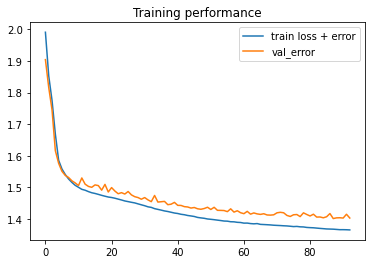

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

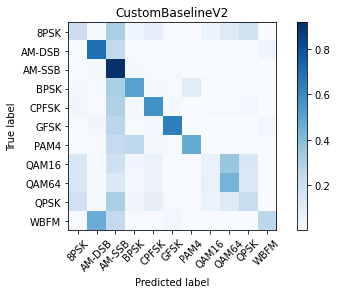

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08729569093610698


Overall Accuracy:  0.09057301293900184


Overall Accuracy:  0.0975609756097561


Overall Accuracy:  0.10470836261419536


Overall Accuracy:  0.12210982658959538


Overall Accuracy:  0.17579663444325097


Overall Accuracy:  0.28090290218559655


Overall Accuracy:  0.3793604651162791


Overall Accuracy:  0.44053958111466096
Overall Accuracy:  0.5808770668583753


Overall Accuracy:  0.6666666666666666


Overall Accuracy:  0.6880634691669671


Overall Accuracy:  0.6785578747628084


Overall Accuracy:  0.6753731343283582
Overall Accuracy:  0.6613832853025937


Overall Accuracy:  0.6700692672256653
Overall Accuracy:  0.6708626434653832


Overall Accuracy:  0.6588943211733734


Overall Accuracy:  0.680545320560059


Overall Accuracy:  0.6659498207885305


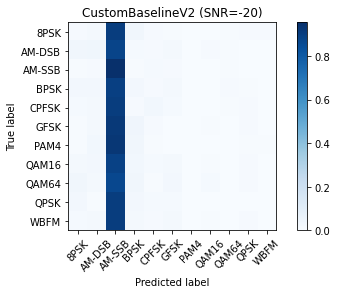

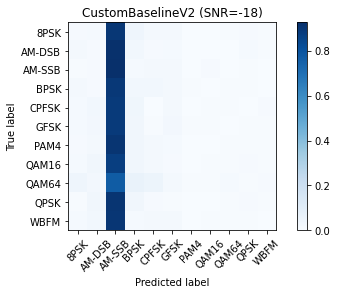

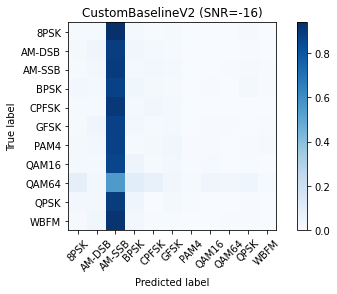

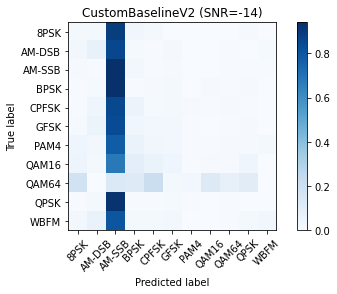

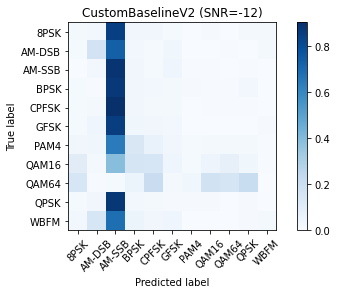

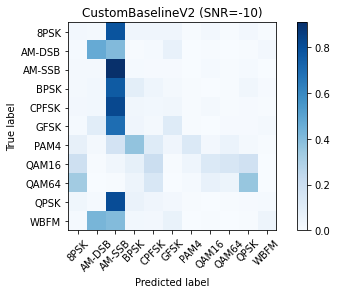

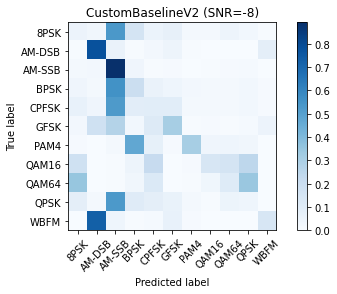

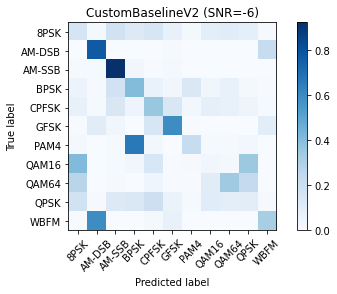

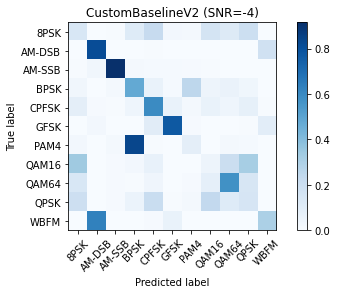

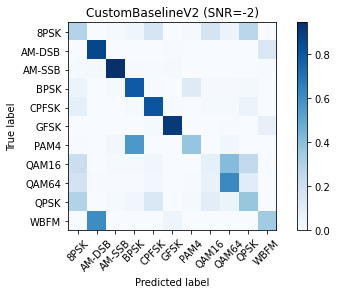

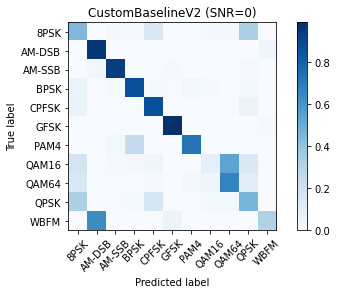

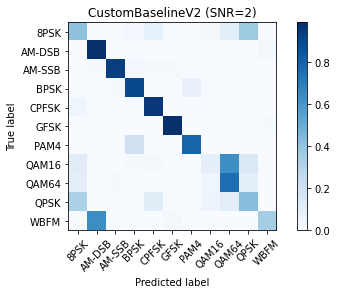

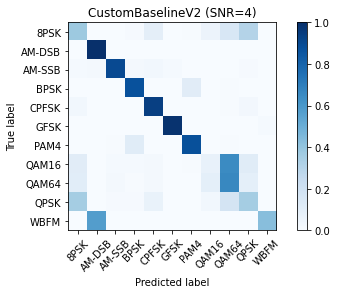

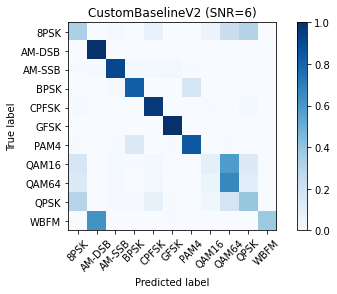

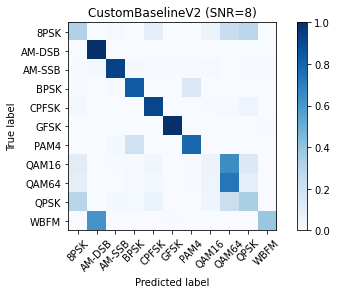

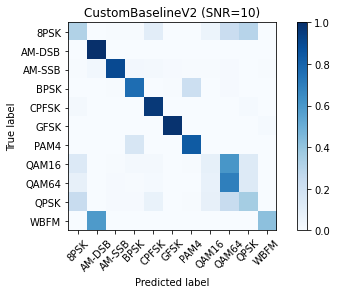

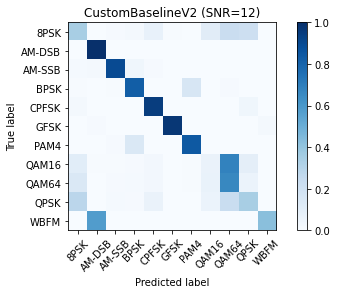

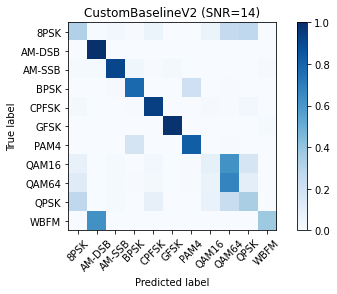

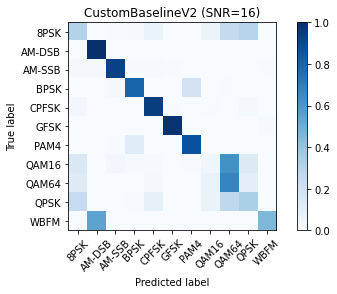

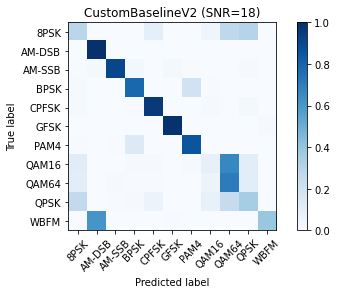

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,10,12,17,28,37,44,58,66,68,67,67,66,67,67,65,68,66


In [18]:
import statistics

statistics.mean(acc.values())

0.4538045160923612

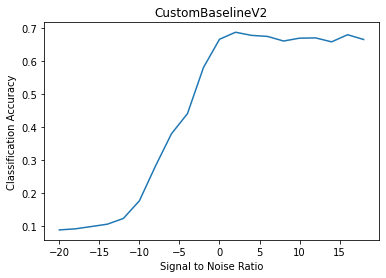

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)